In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import wasserstein_distance
import os, sys
import scipy.io as sio
import cv2


import keras
from keras.applications.resnet import preprocess_input
from keras.layers import Input, Dense, Lambda, Reshape, Flatten, Dropout
from keras.layers import Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import networkx as nx
from sklearn.decomposition import PCA

Using TensorFlow backend.


## Load the customer picture 

In [2]:
test_img_path = './library_Pic'

In [3]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = image_gen.flow_from_directory(
    batch_size=1,
    directory=test_img_path,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='sparse',
    seed = 42
)
test_img ,label = test_gen.next()
test_img ,label = test_gen.next()

Found 1 images belonging to 1 classes.


## Get the feature and encoder 

In [6]:
model_ft = load_model('./model/{}/FineTuneResNet101.h5'.format('AWA2'))

In [4]:
class Scaler(keras.layers.Layer):
    def __init__(self, tau=0.5, **kwargs):
        super(Scaler, self).__init__(**kwargs)
        self.tau = tau
    
    def build(self, input_shape):
        super(Scaler, self).build(input_shape)
        self.scale = self.add_weight(
            name='scale', shape=(input_shape[-1],), initializer='zeros'
        )
    
    def call(self, inputs, mode='positive'):
        if mode == 'positive':
            scale = self.tau + (1 - self.tau) * K.sigmoid(self.scale)
        
        else:
            scale = (1 - self.tau) * K.sigmoid(-self.scale)
        
        return inputs * K.sqrt(scale)
    
    def get_config(self):
        config = {'tau': self.tau}
        base_config = super(Scaler, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class Sampling(keras.layers.Layer):
    def __init__(self, latent_dim=128, **kwargs):
        super(Sampling, self).__init__(**kwargs)
        self.latent_dim = latent_dim

    def build(self, input_shape):
        super(Sampling, self).build(input_shape)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim))

        return z_mean + K.exp(z_log_var / 2) * epsilon

    def get_config(self):
        base_config = super(Sampling, self).get_config()
        config = {'latent_dim': self.latent_dim}
        return dict(list(base_config.items()) + list(config.items()))
encoder = load_model('./model/{}/encoder_{}_{}.h5'.format('AWA2','ft','cms'), custom_objects={'Scaler': Scaler, 'Sampling': Sampling})





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [7]:
after_predict = model_ft.predict(test_img)
attr = encoder.predict(after_predict)

In [8]:
mean = np.mean(attr,axis = 1)
std = np.std(attr,axis = 1)
for i in range(len(attr)):
    attr[i] = (attr[i] - mean[i]) / std[i]

## Plot the attr 

In [9]:
attr = attr.squeeze()

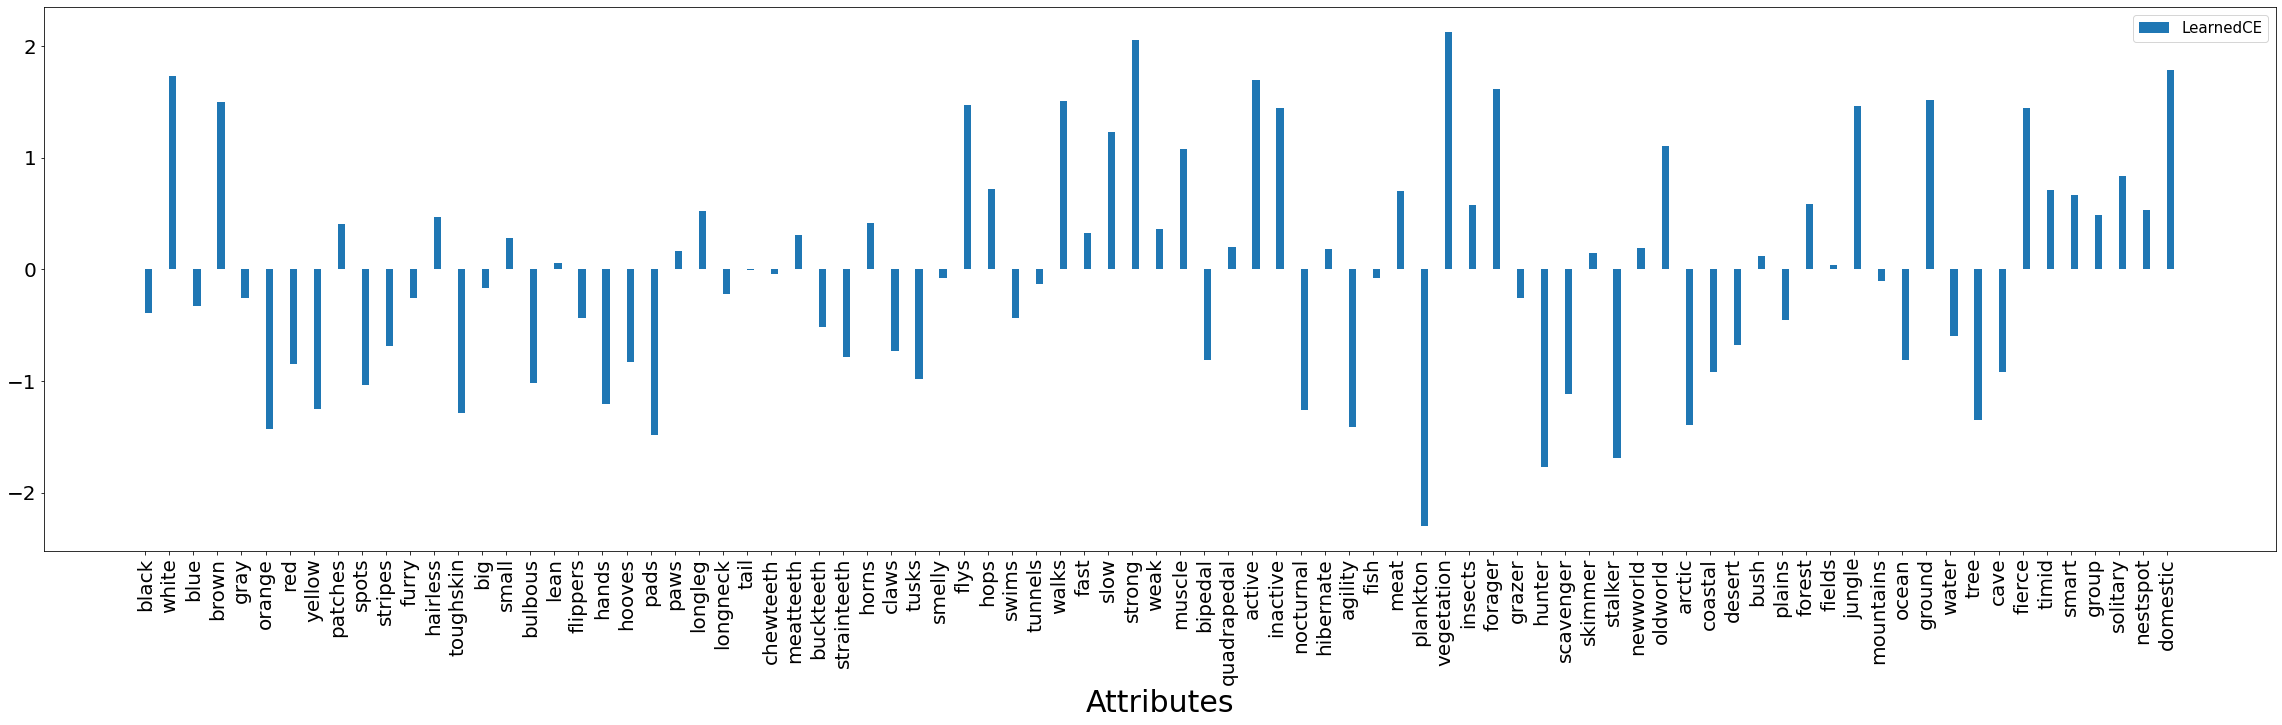

In [10]:
attributes_name = pd.read_csv('./data/{}/predicates.txt'.format('AWA2'),header=None,sep='\t')


plt.figure(figsize=(40,10))
plt.bar(attributes_name[1],height=attr.squeeze(),align='edge',label = 'LearnedCE',width = 0.3)
plt.legend(fontsize=15) #要使用label要加這行
plt.xlabel('Attributes',fontsize=30) # 設定x軸標題
plt.xticks(fontsize=20,rotation='vertical')
plt.yticks(fontsize=20)
plt.show()

## Calculate the wasserstein distance 

In [126]:
data = sio.loadmat('./data/AWA2/mat/ft_cms/att_splits.mat')

In [127]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trainval_loc', 'test_seen_loc', 'test_unseen_loc', 'att', 'train_loc', 'val_loc'])

In [128]:
tmp = sio.loadmat('../Downloads/att_splits.mat')
tmp.keys()

dict_keys(['__header__', '__version__', '__globals__', 'allclasses_names', 'att', 'original_att', 'test_seen_loc', 'test_unseen_loc', 'train_loc', 'trainval_loc', 'val_loc'])

In [129]:
attr = tmp['original_att'].T

In [121]:
attr[0]

array([-1.  , -1.  , -1.  , -1.  , 12.34,  0.  ,  0.  ,  0.  , 16.11,
        9.19,  0.  , 38.09,  4.44, 28.55, 38.75,  5.68, 17.07, 39.99,
        0.  ,  0.  , 67.08,  7.78,  0.  , 60.24, 16.8 , 40.59, 29.7 ,
        5.56,  2.47,  0.  , 87.43,  0.  ,  8.64,  9.04,  0.  ,  9.23,
        1.23,  0.  , 54.58, 70.86,  3.33, 33.56,  8.15, 26.14,  0.  ,
       67.85, 41.19,  7.36,  1.11,  6.94, 62.32,  0.  ,  4.44,  0.  ,
       57.76, 12.63, 33.24, 61.86,  0.  ,  0.  ,  0.  ,  0.  , 22.72,
       55.81,  5.9 ,  0.  ,  0.  , 19.88, 54.79,  4.94, 40.97,  0.  ,
       22.32,  0.  , 57.14,  0.  ,  0.  ,  1.23, 10.49, 39.24, 17.57,
       50.59,  2.35,  9.7 ,  8.38])

In [122]:
mean = np.mean(attr,axis=1)
std = np.std(attr,axis=1)
for idx in range(attr.shape[0]):
    attr[idx] = (attr[idx] - mean[idx])/std[idx]

In [123]:
class_name = tmp['allclasses_names']

In [124]:
attr[0]

array([-0.83993286, -0.83993286, -0.83993286, -0.83993286, -0.24997048,
       -0.79570779, -0.79570779, -0.79570779, -0.08324198, -0.38927944,
       -0.79570779,  0.88882497, -0.5993485 ,  0.46691784,  0.91801351,
       -0.54450942, -0.04078592,  0.9728526 , -0.79570779, -0.79570779,
        2.17090963, -0.45163678, -0.79570779,  1.86841018, -0.05272668,
        0.99938764,  0.51777667, -0.54981643, -0.68647188, -0.79570779,
        3.07088973, -0.79570779, -0.41360322, -0.3959132 , -0.79570779,
       -0.38751043, -0.74131096, -0.79570779,  1.61809631,  2.33808038,
       -0.64843832,  0.68848542, -0.43527351,  0.36033543, -0.79570779,
        2.20496294,  1.02592268, -0.47021131, -0.74661797, -0.48878584,
        1.96039832, -0.79570779, -0.5993485 , -0.79570779,  1.75873202,
       -0.23714521,  0.6743334 ,  1.94005479, -0.79570779, -0.79570779,
       -0.79570779, -0.79570779,  0.20908571,  1.67249314, -0.5347799 ,
       -0.79570779, -0.79570779,  0.08348652,  1.62738357, -0.57

In [130]:
path = '../Documents/CADA-VAE-PyTorch/data/AWA2/att_splits.mat'

sio.savemat(path, {
                   'att': attr.transpose(),
                   'test_seen_loc': data['test_seen_loc'],
                   'test_unseen_loc': data['test_unseen_loc'],
                   'train_loc': data['train_loc'],  ##non used in code
                   'trainval_loc': data['trainval_loc'],
                   'val_loc': data['val_loc']})    ##non used in code

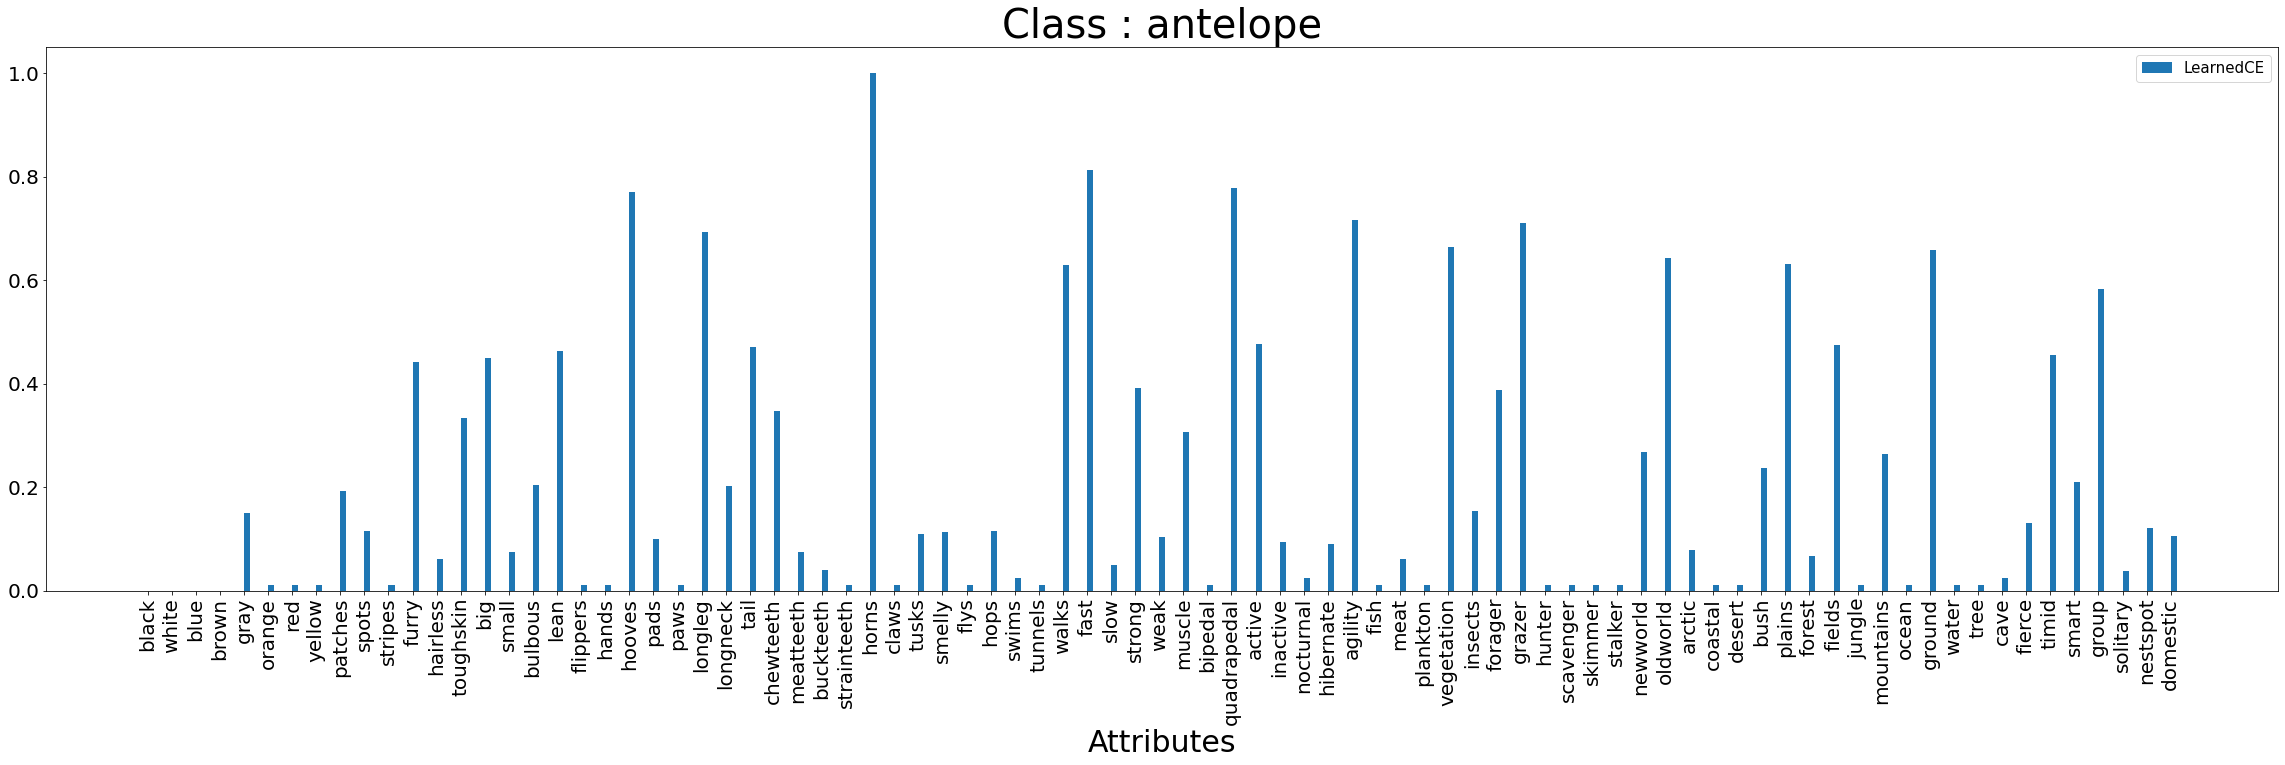

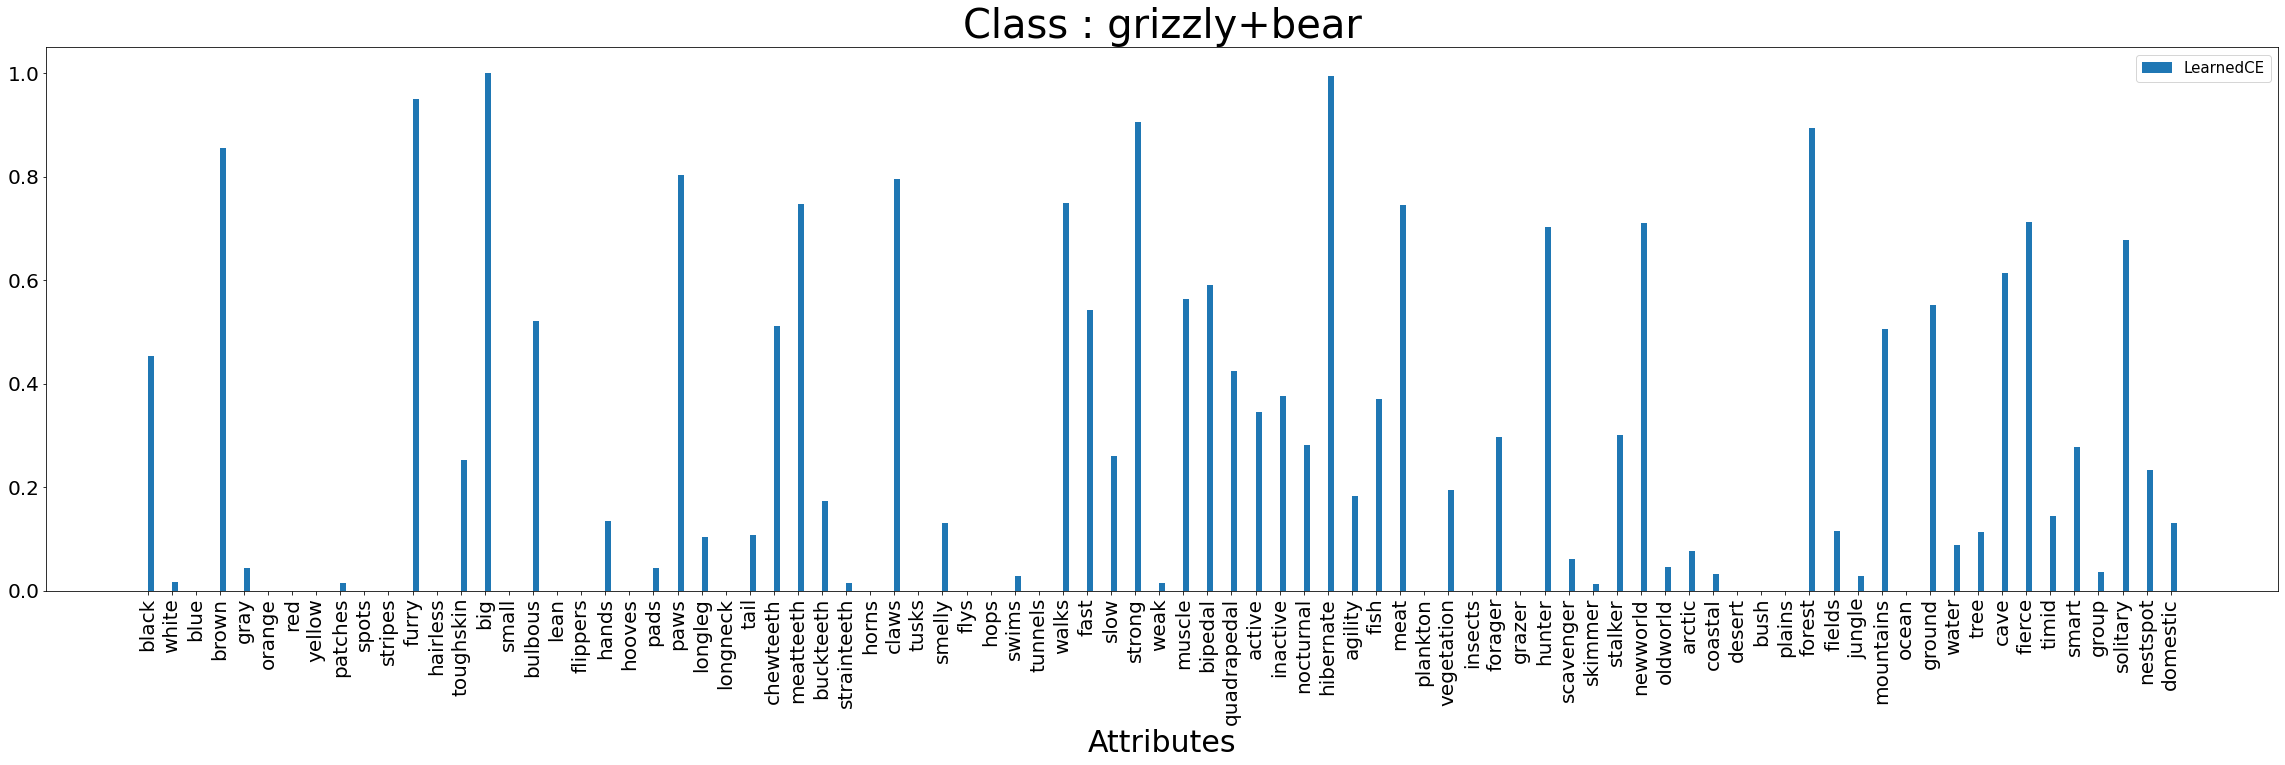

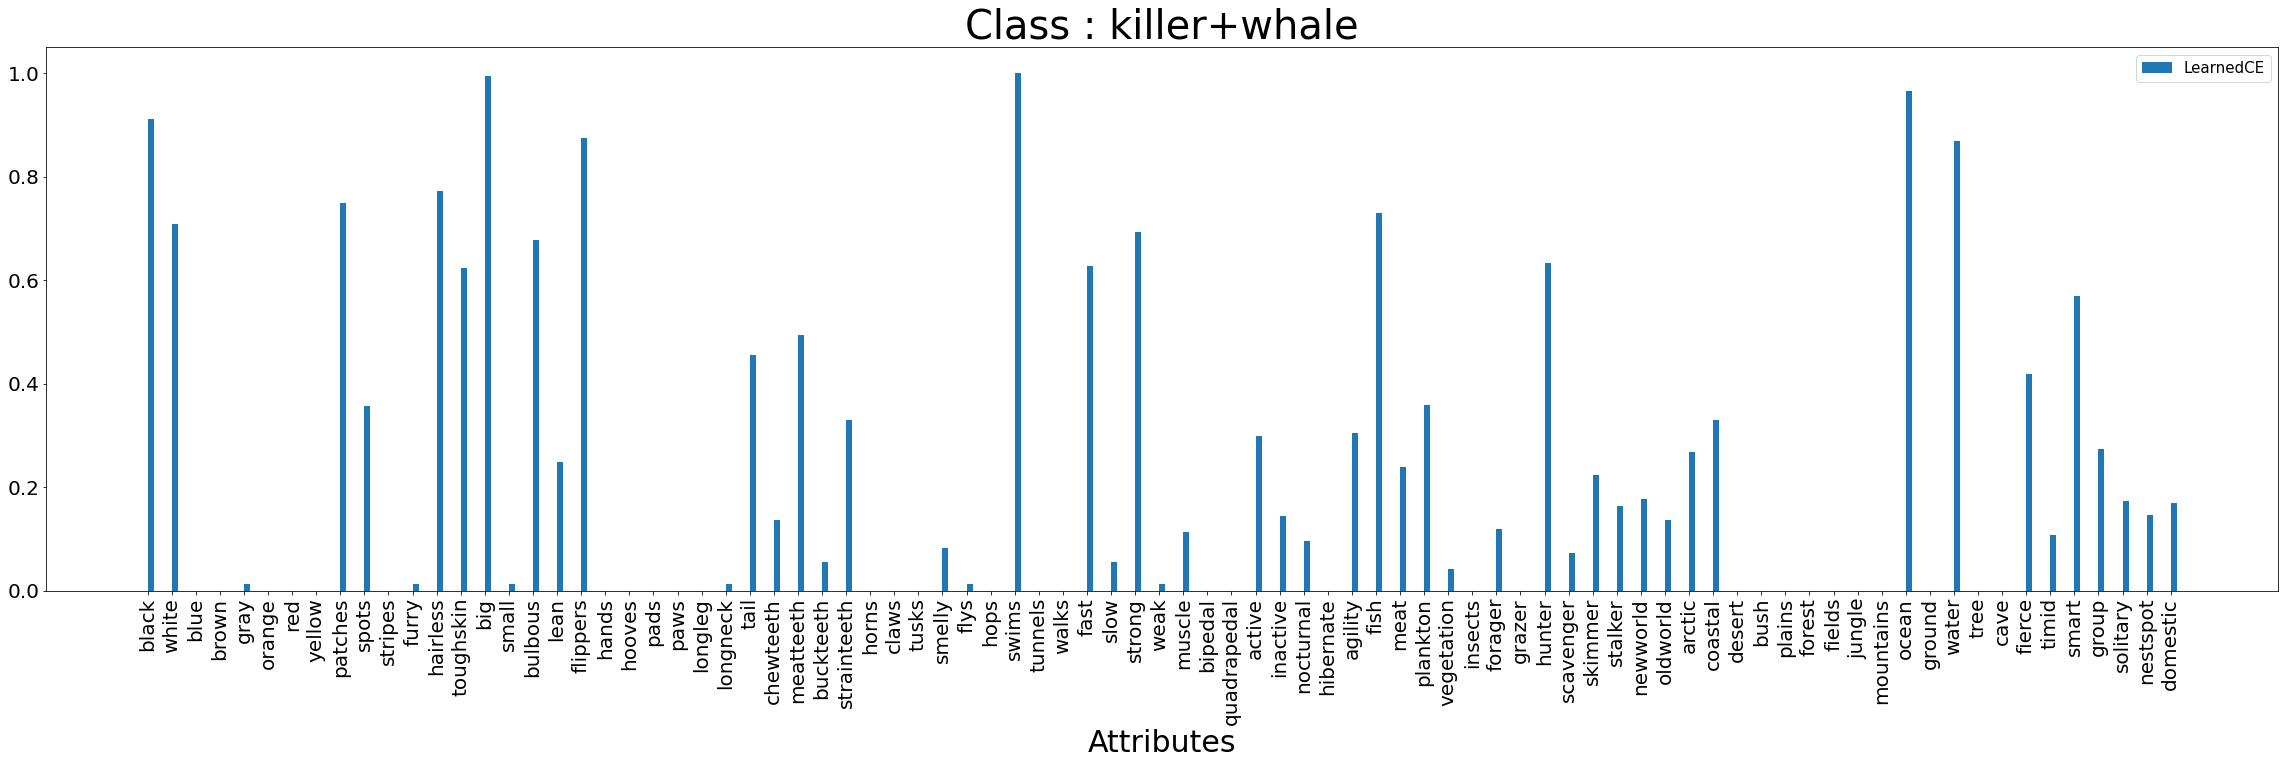

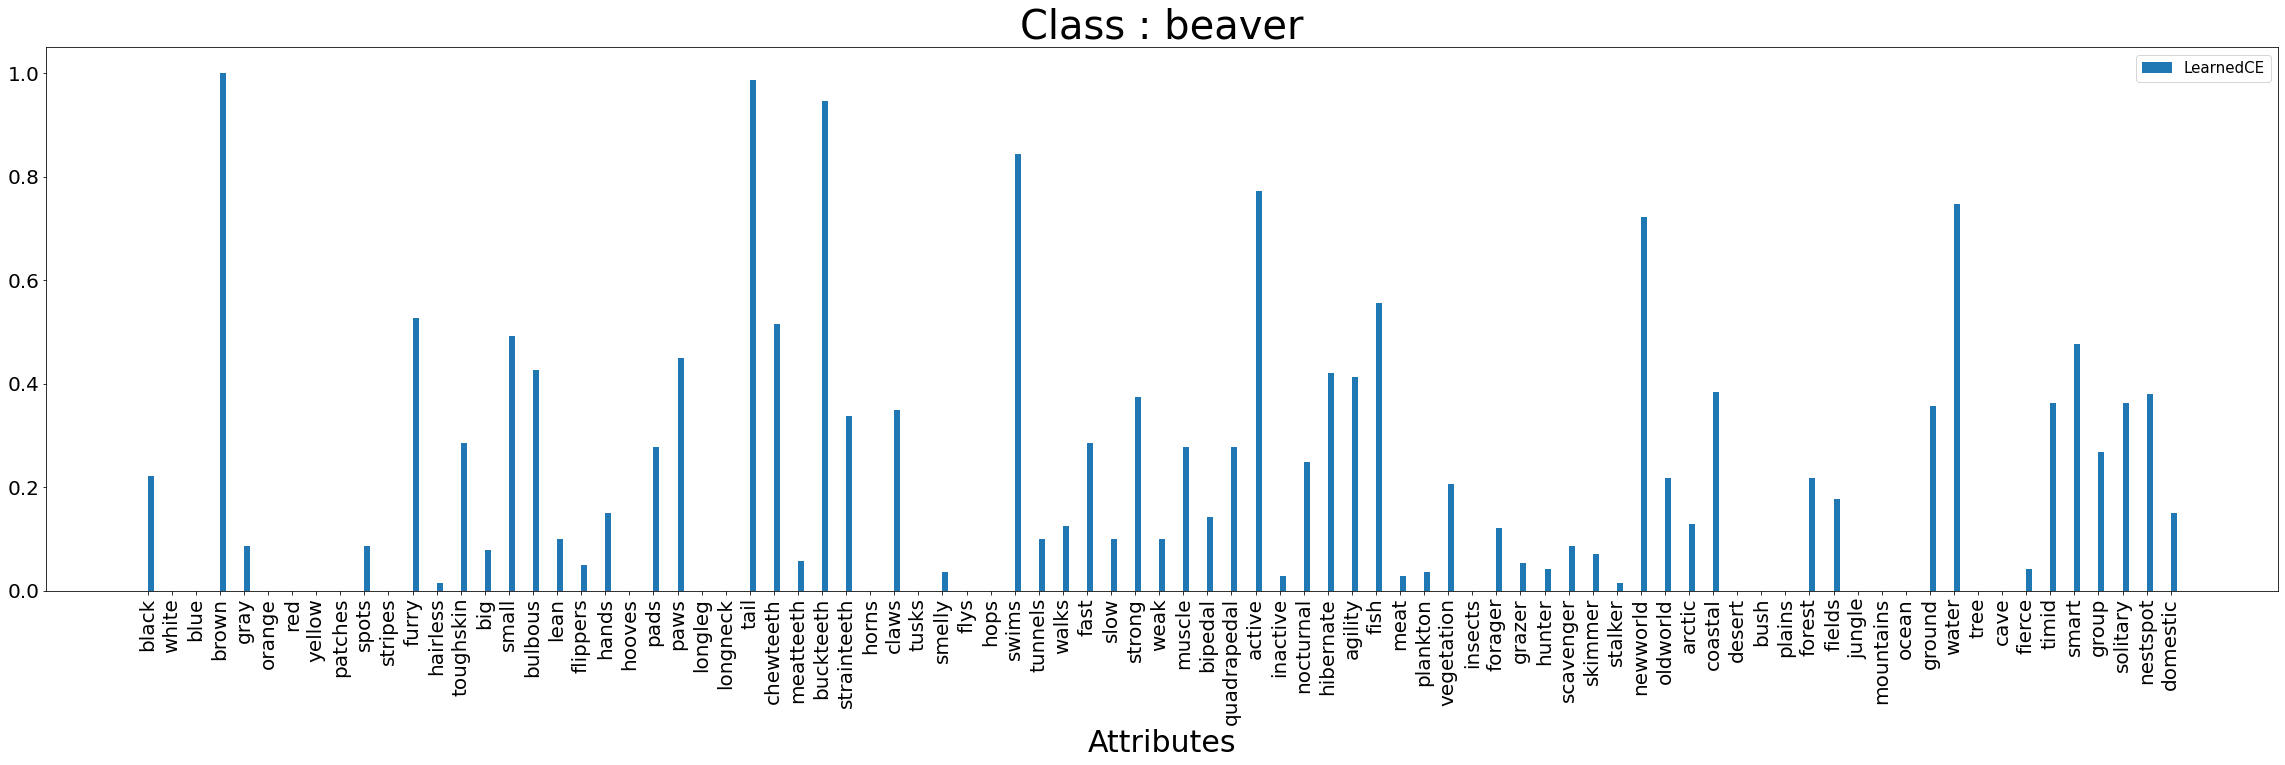

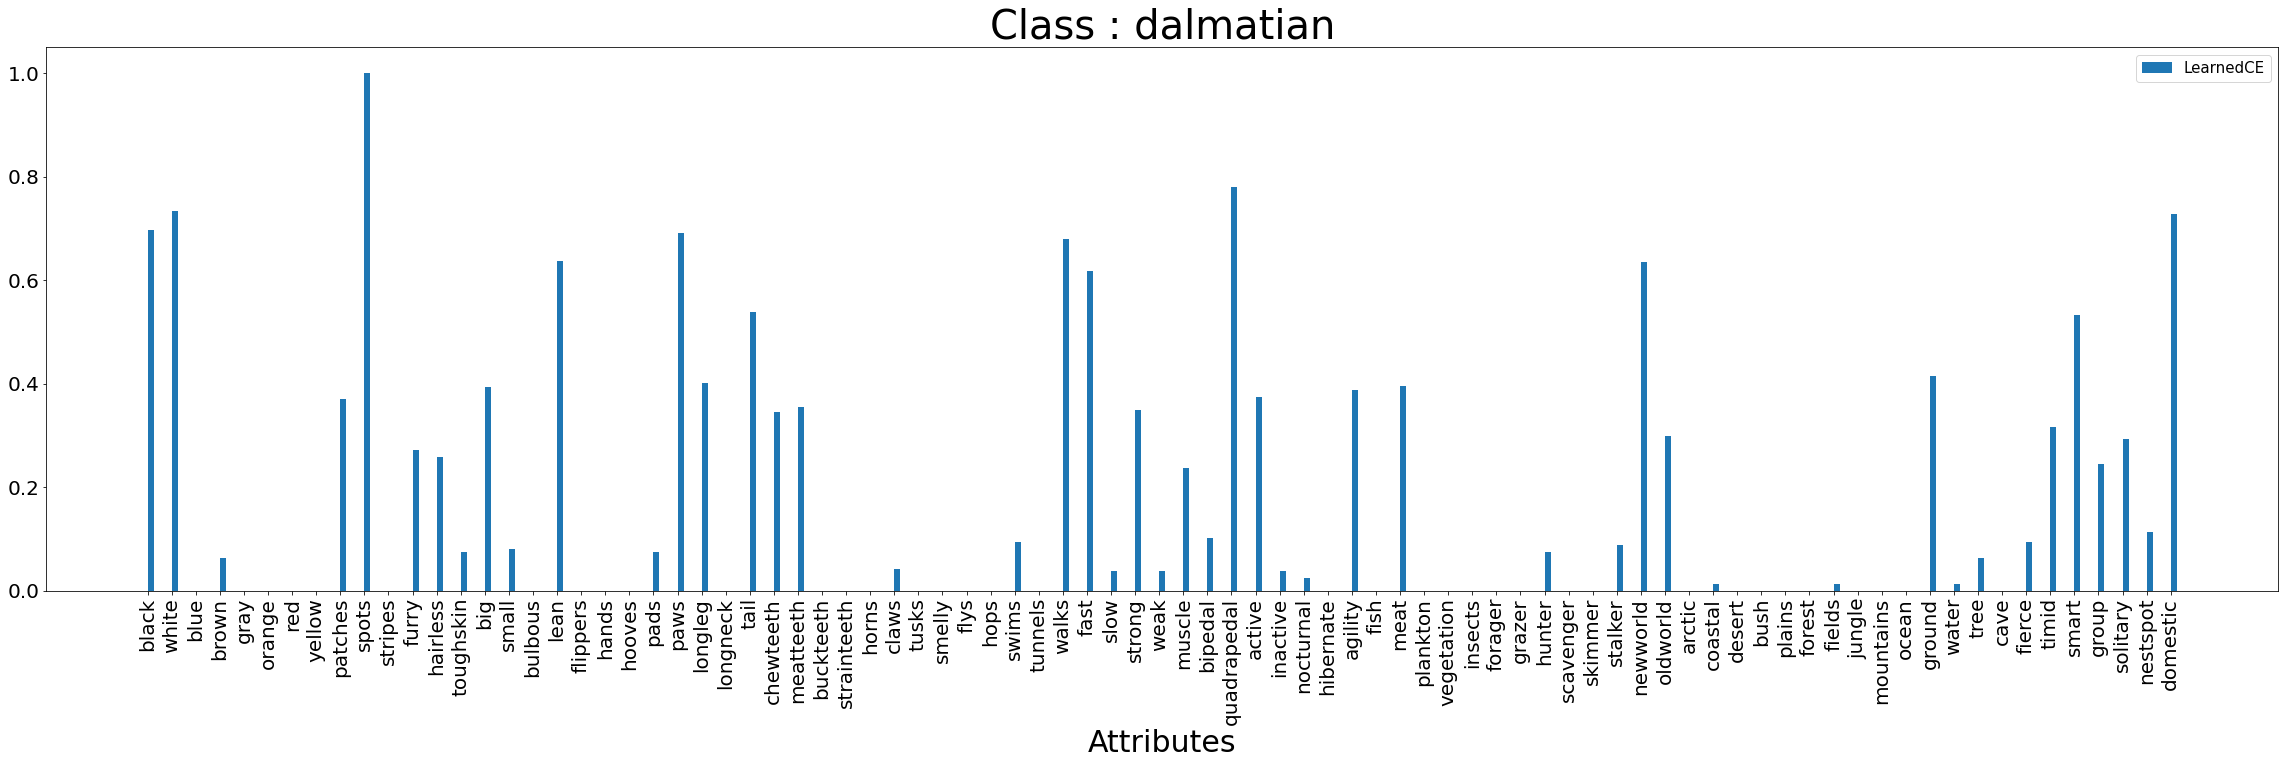

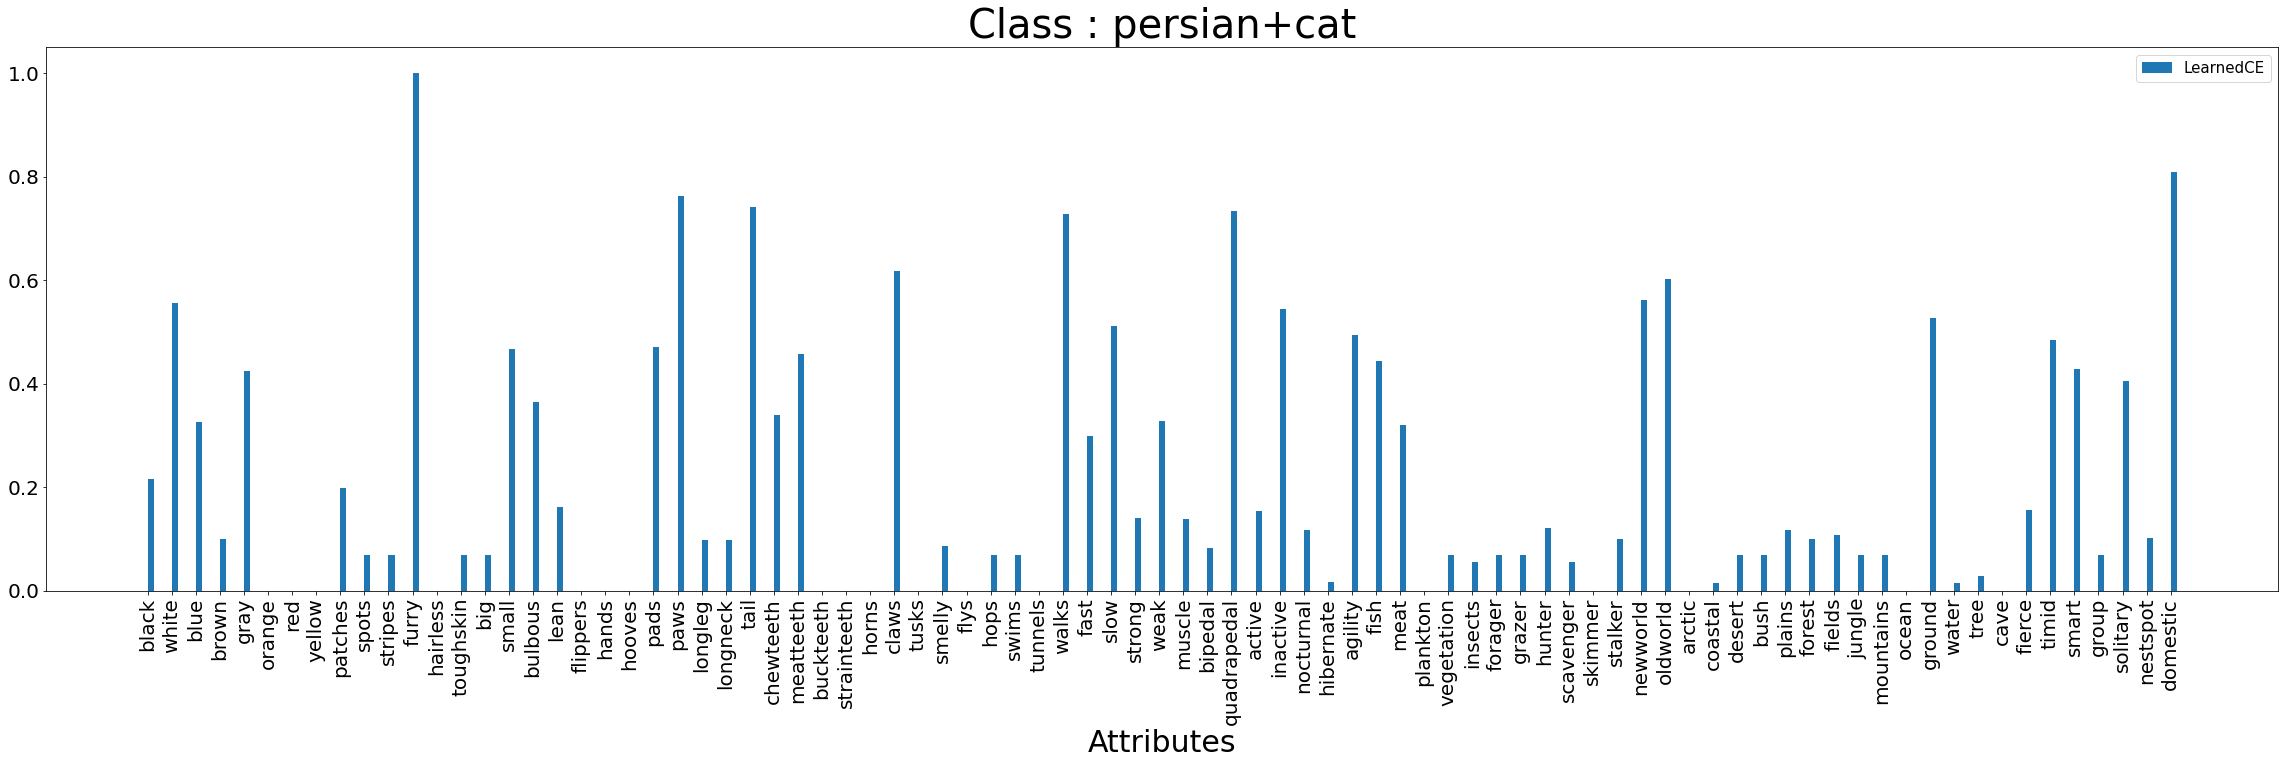

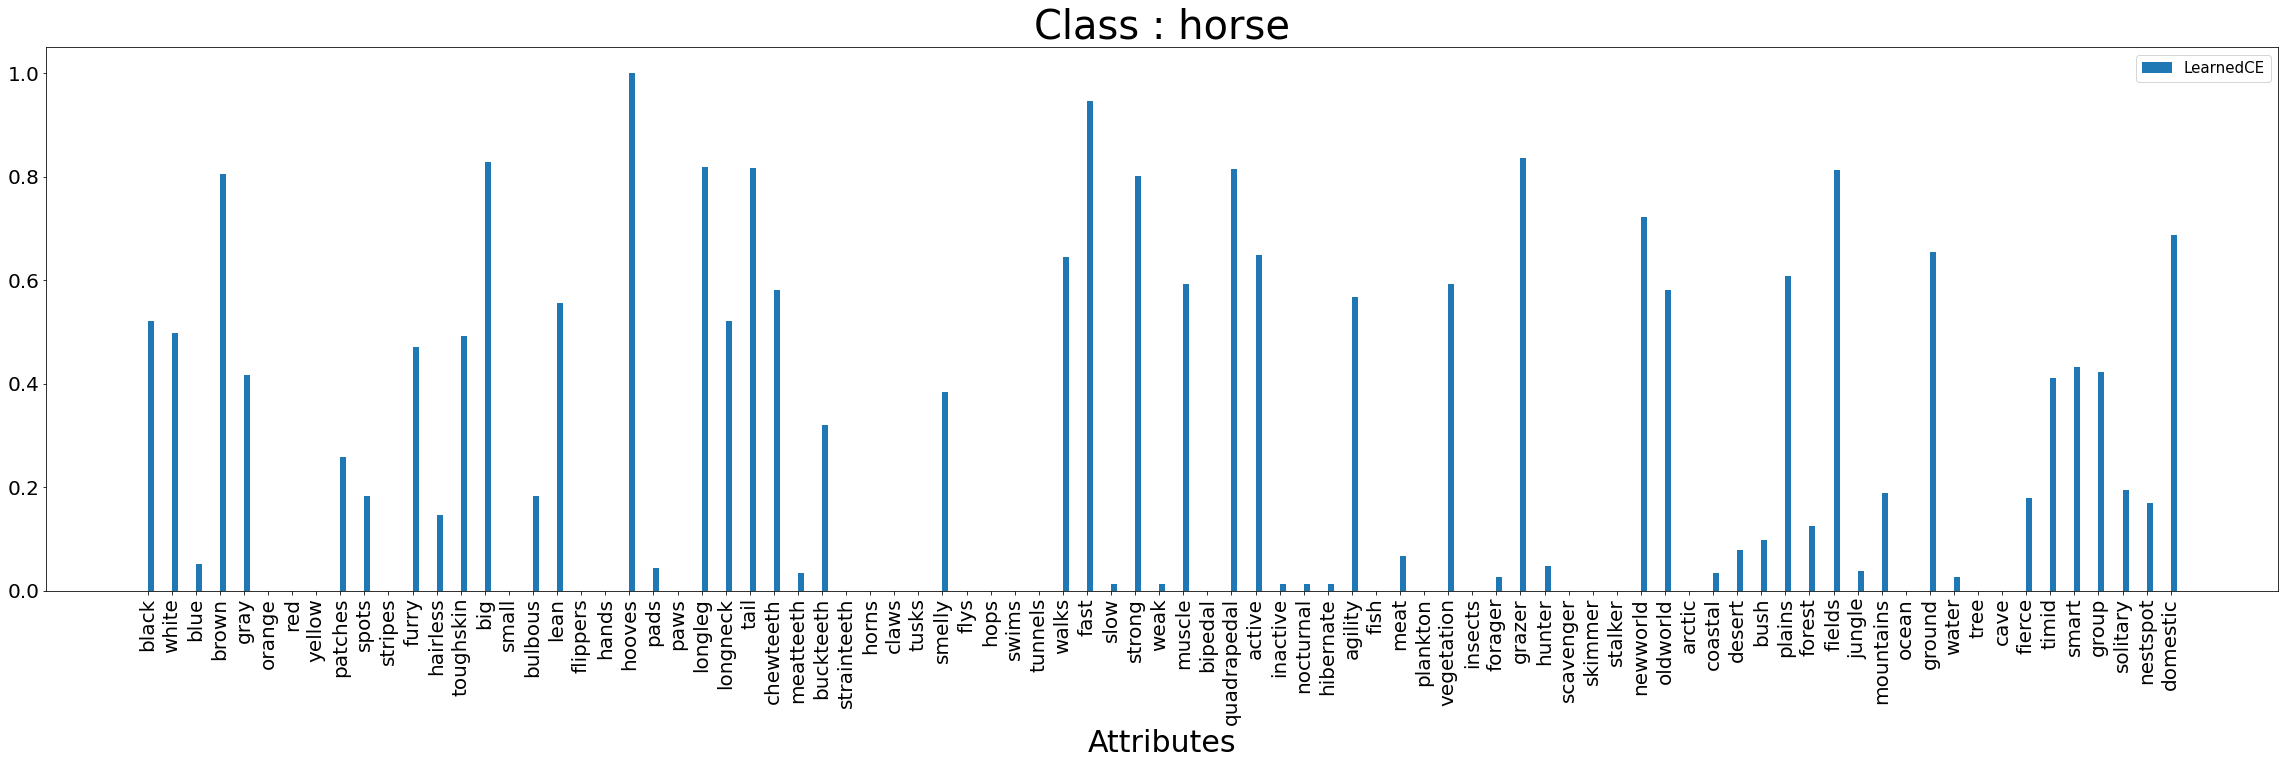

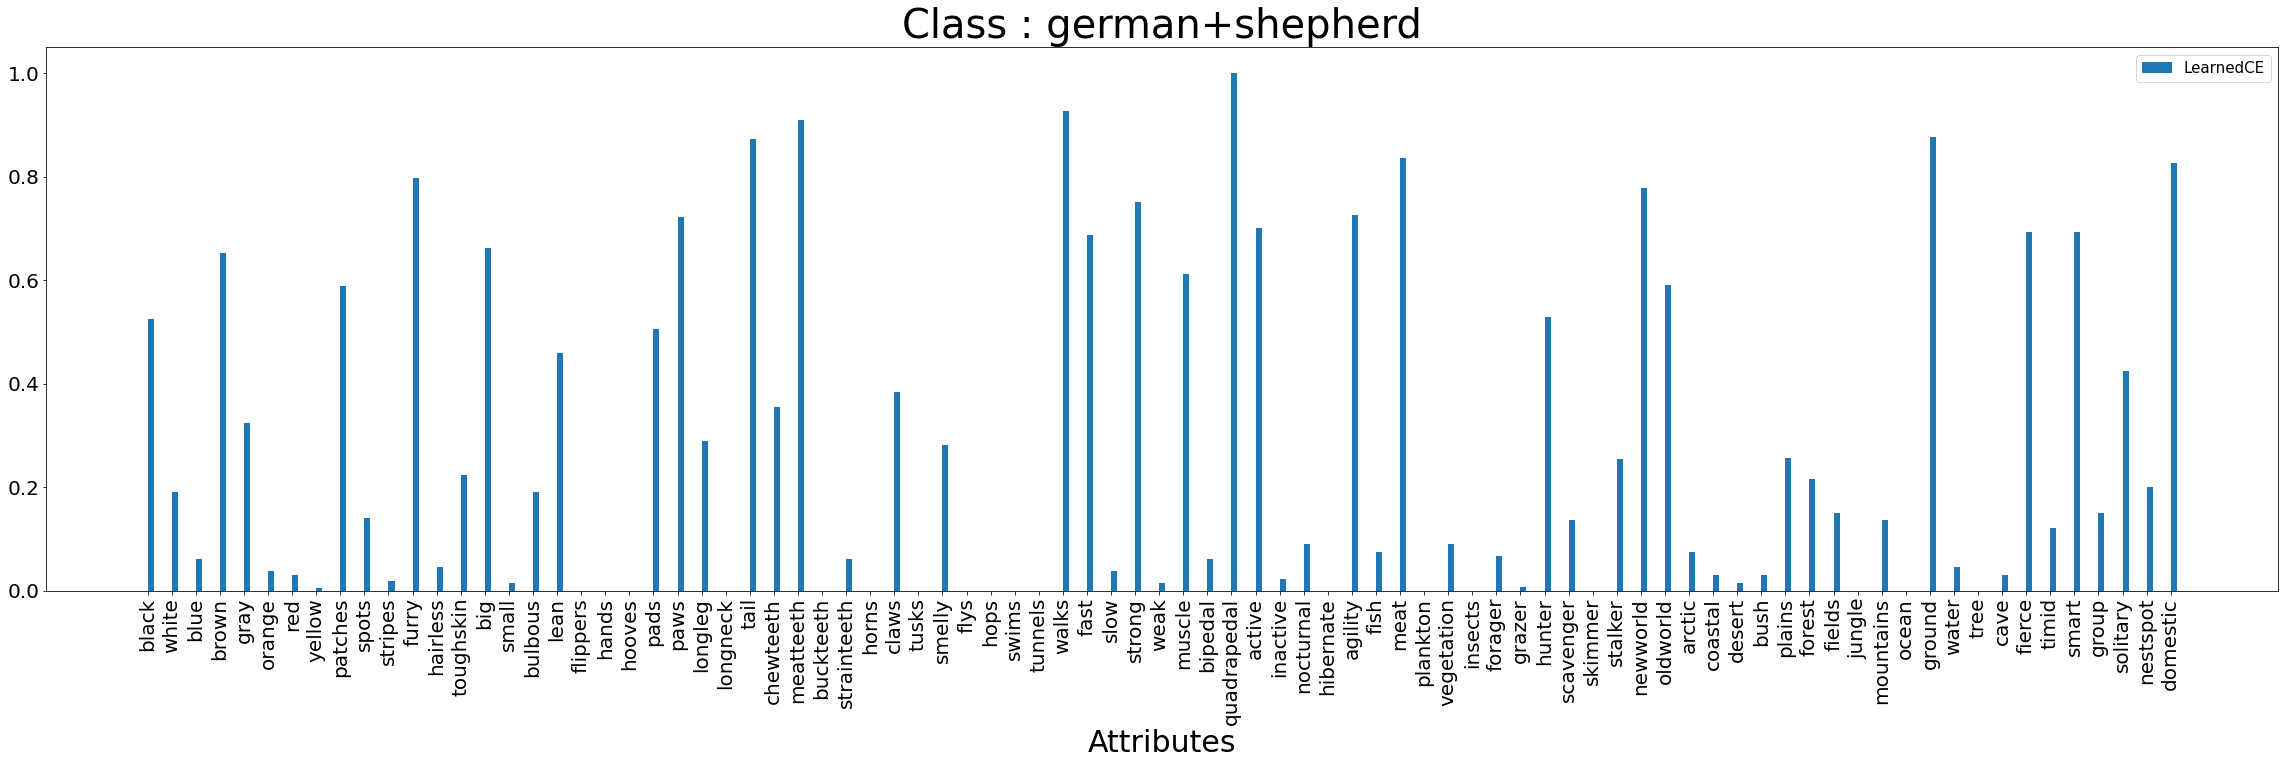

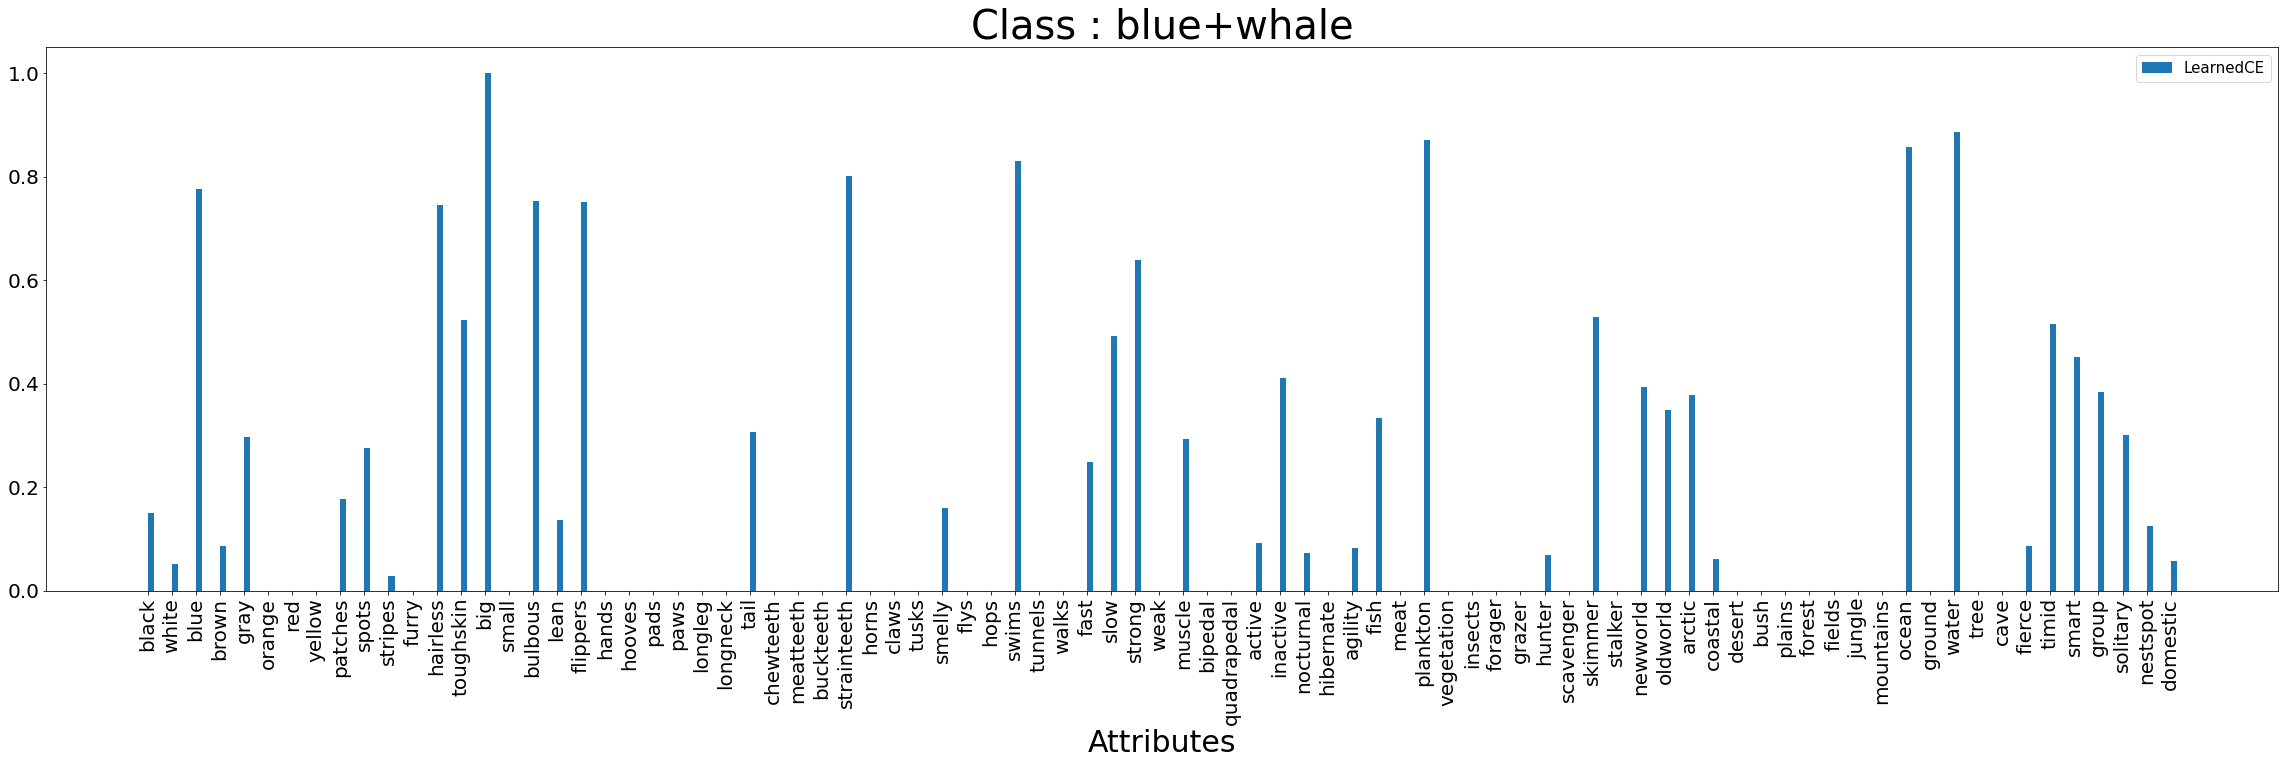

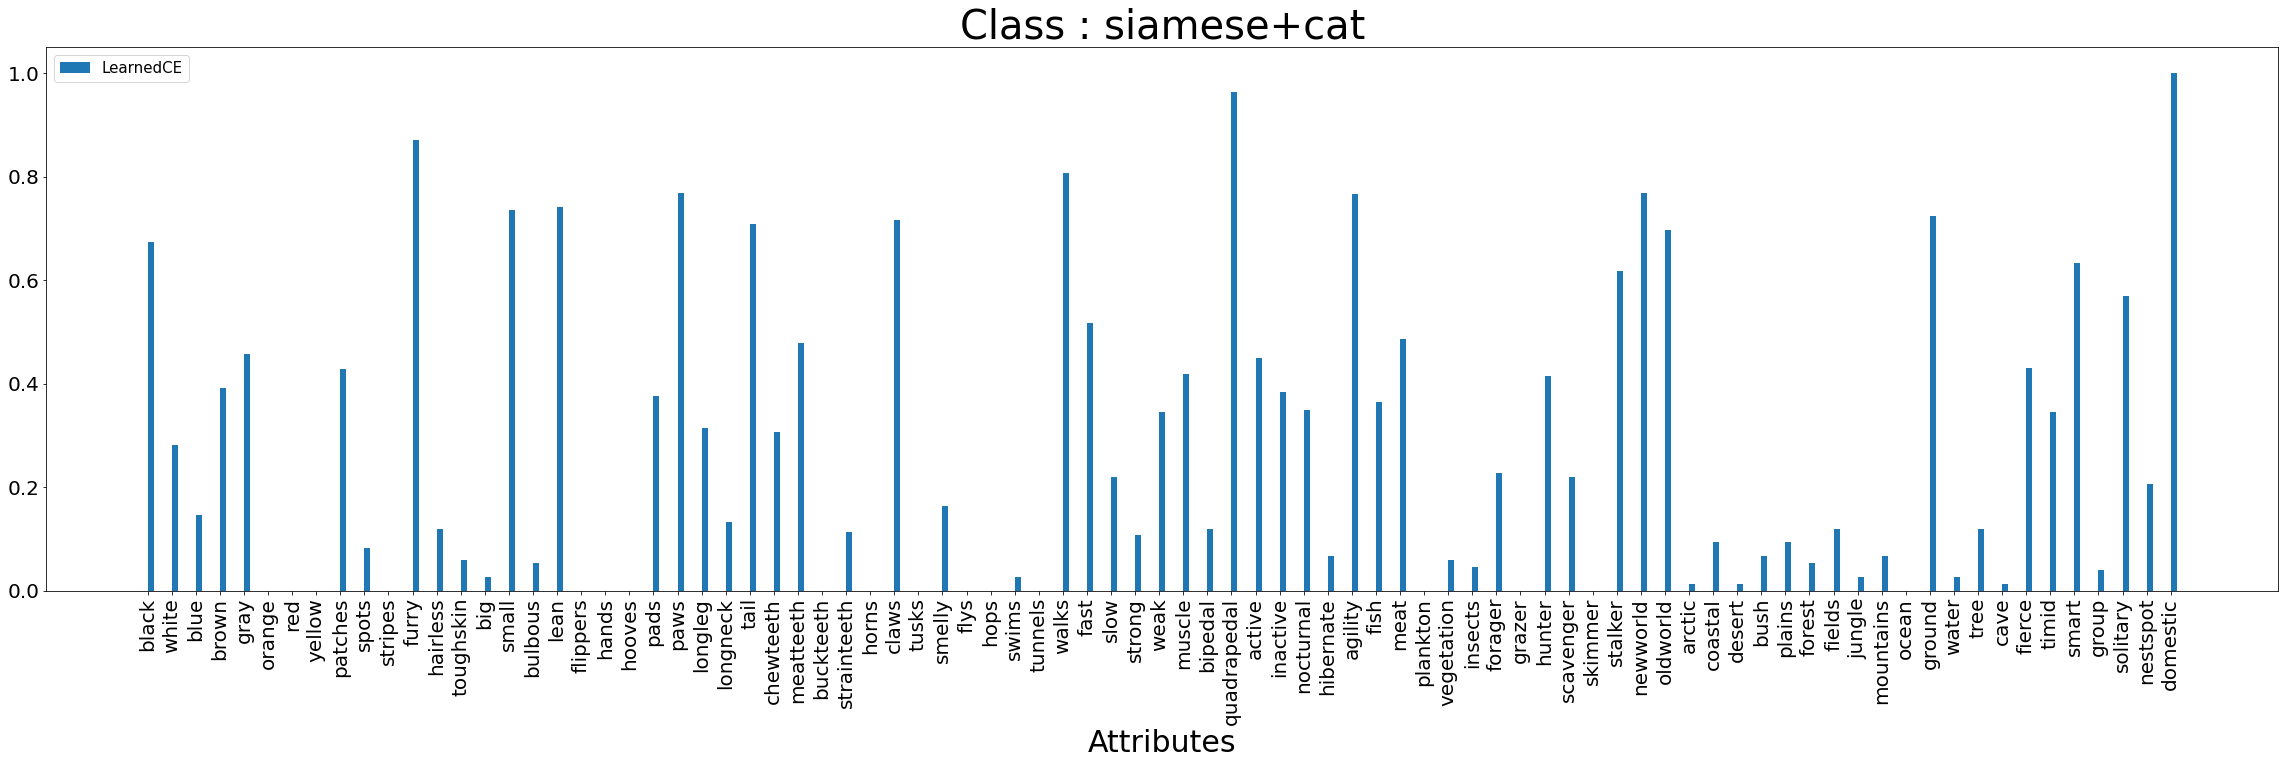

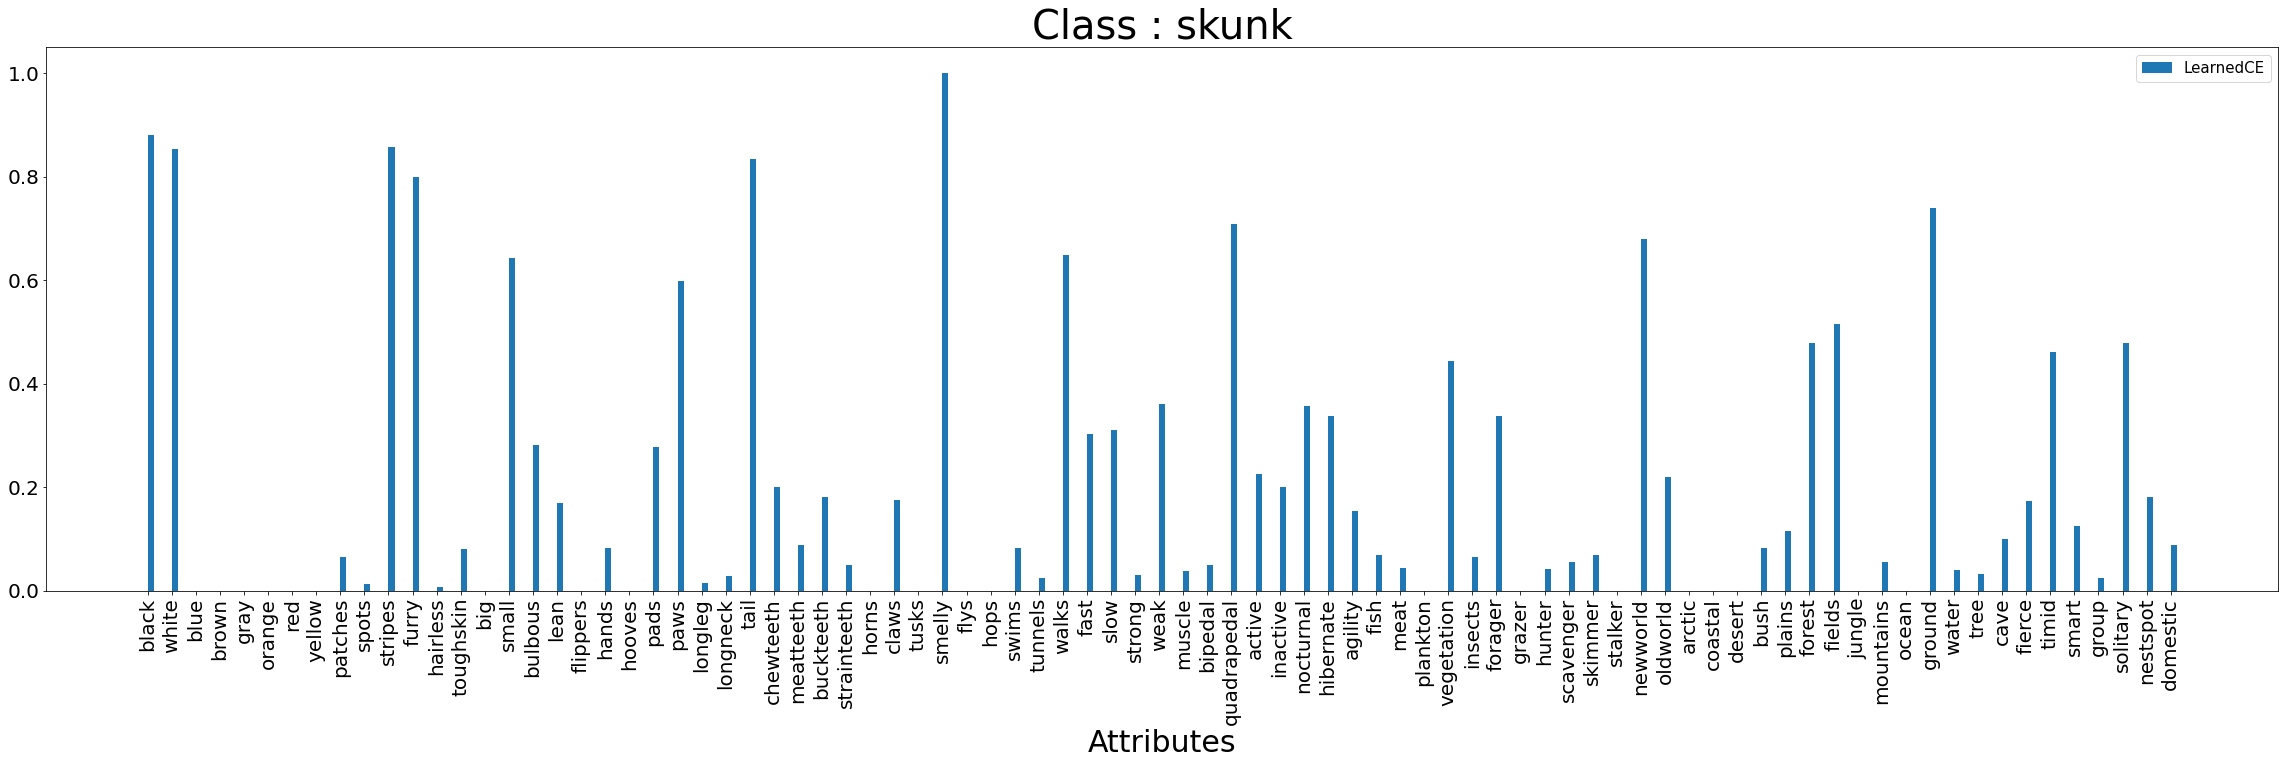

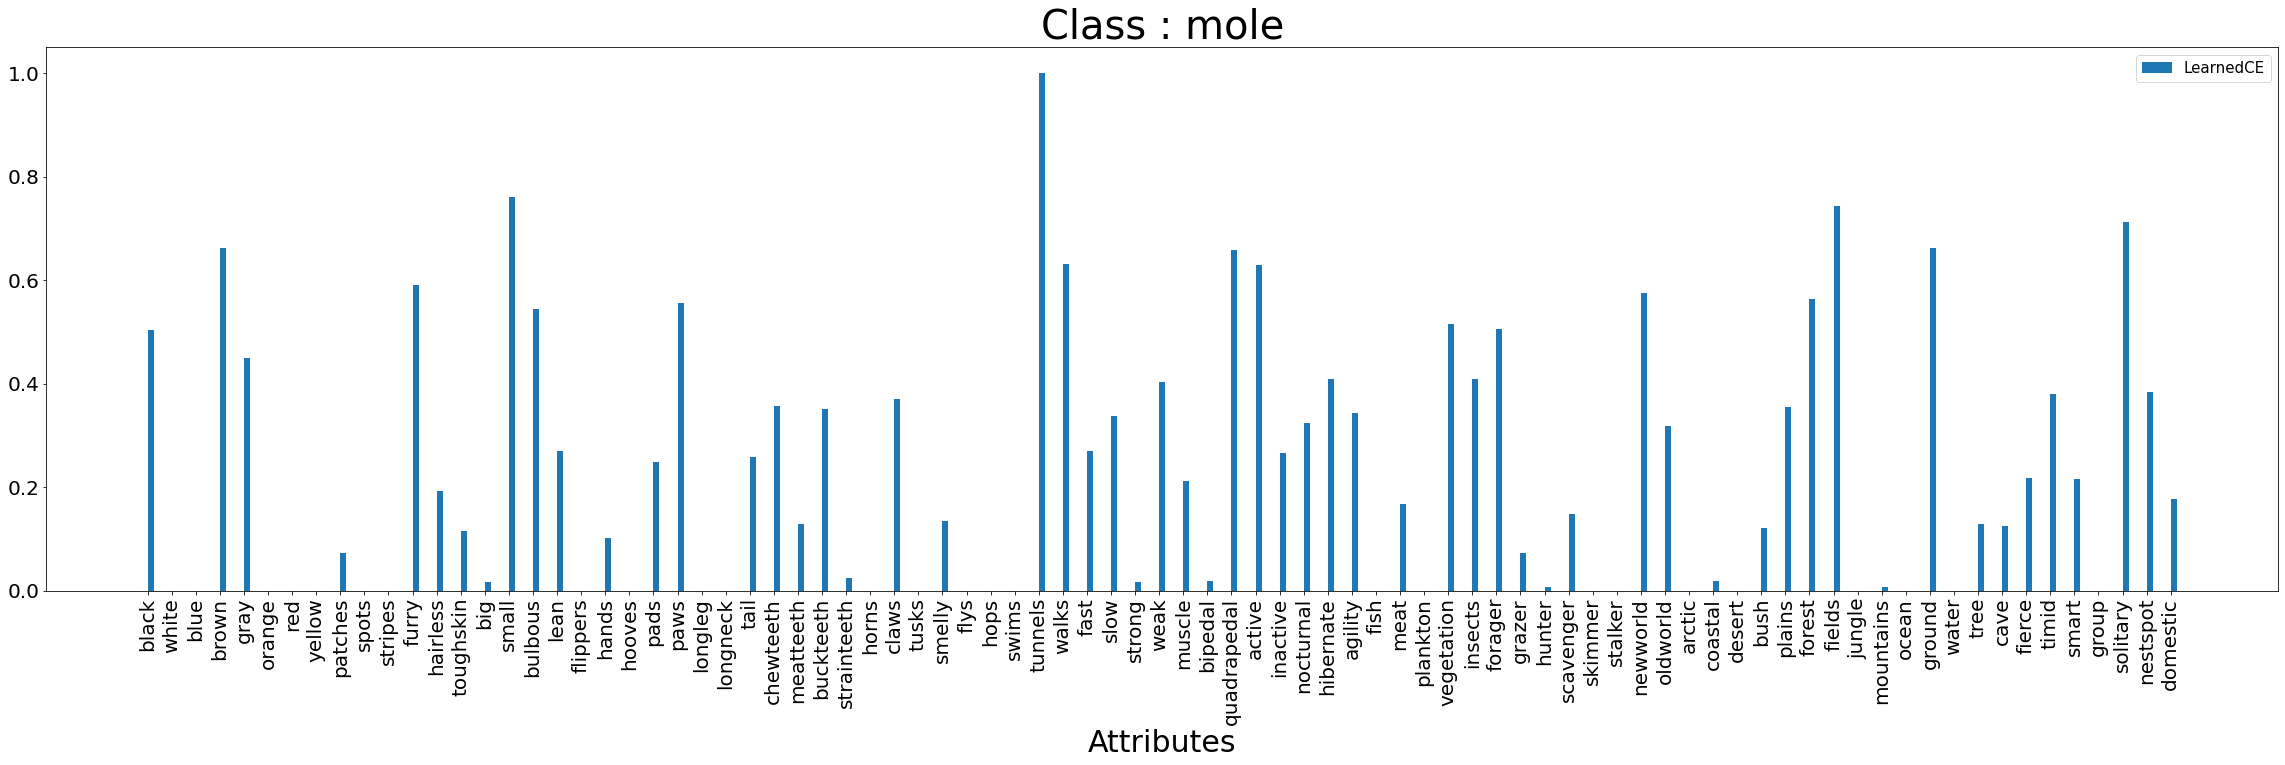

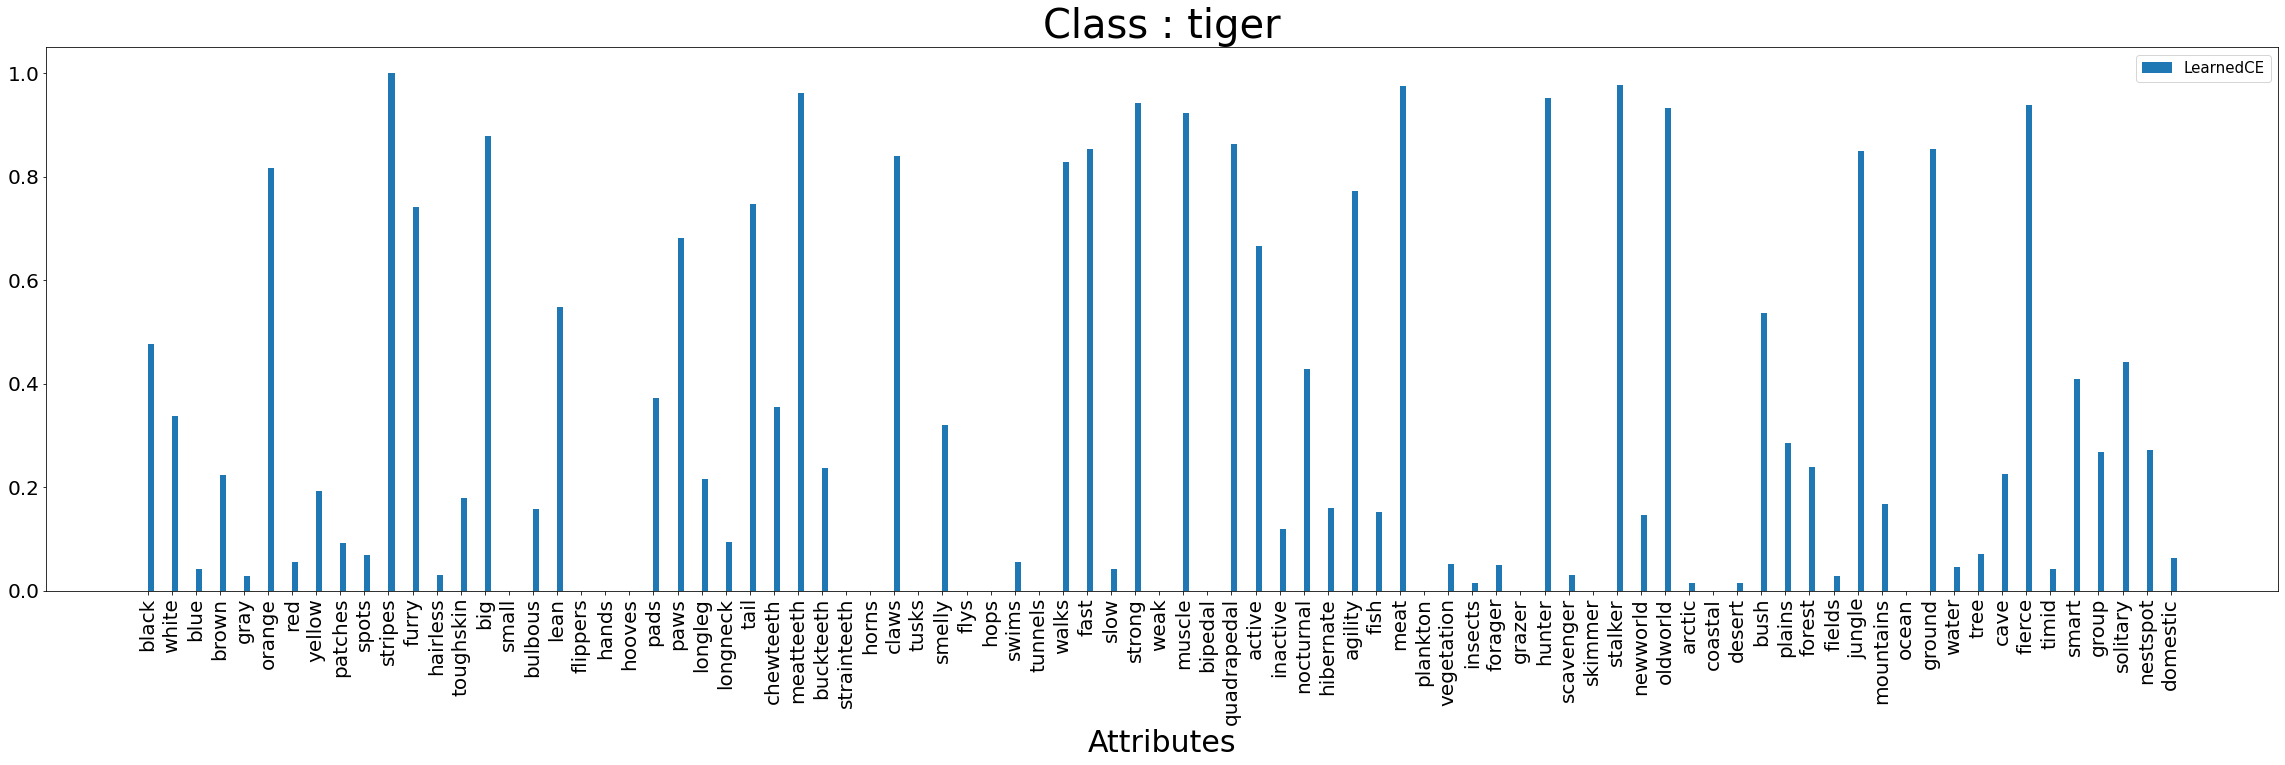

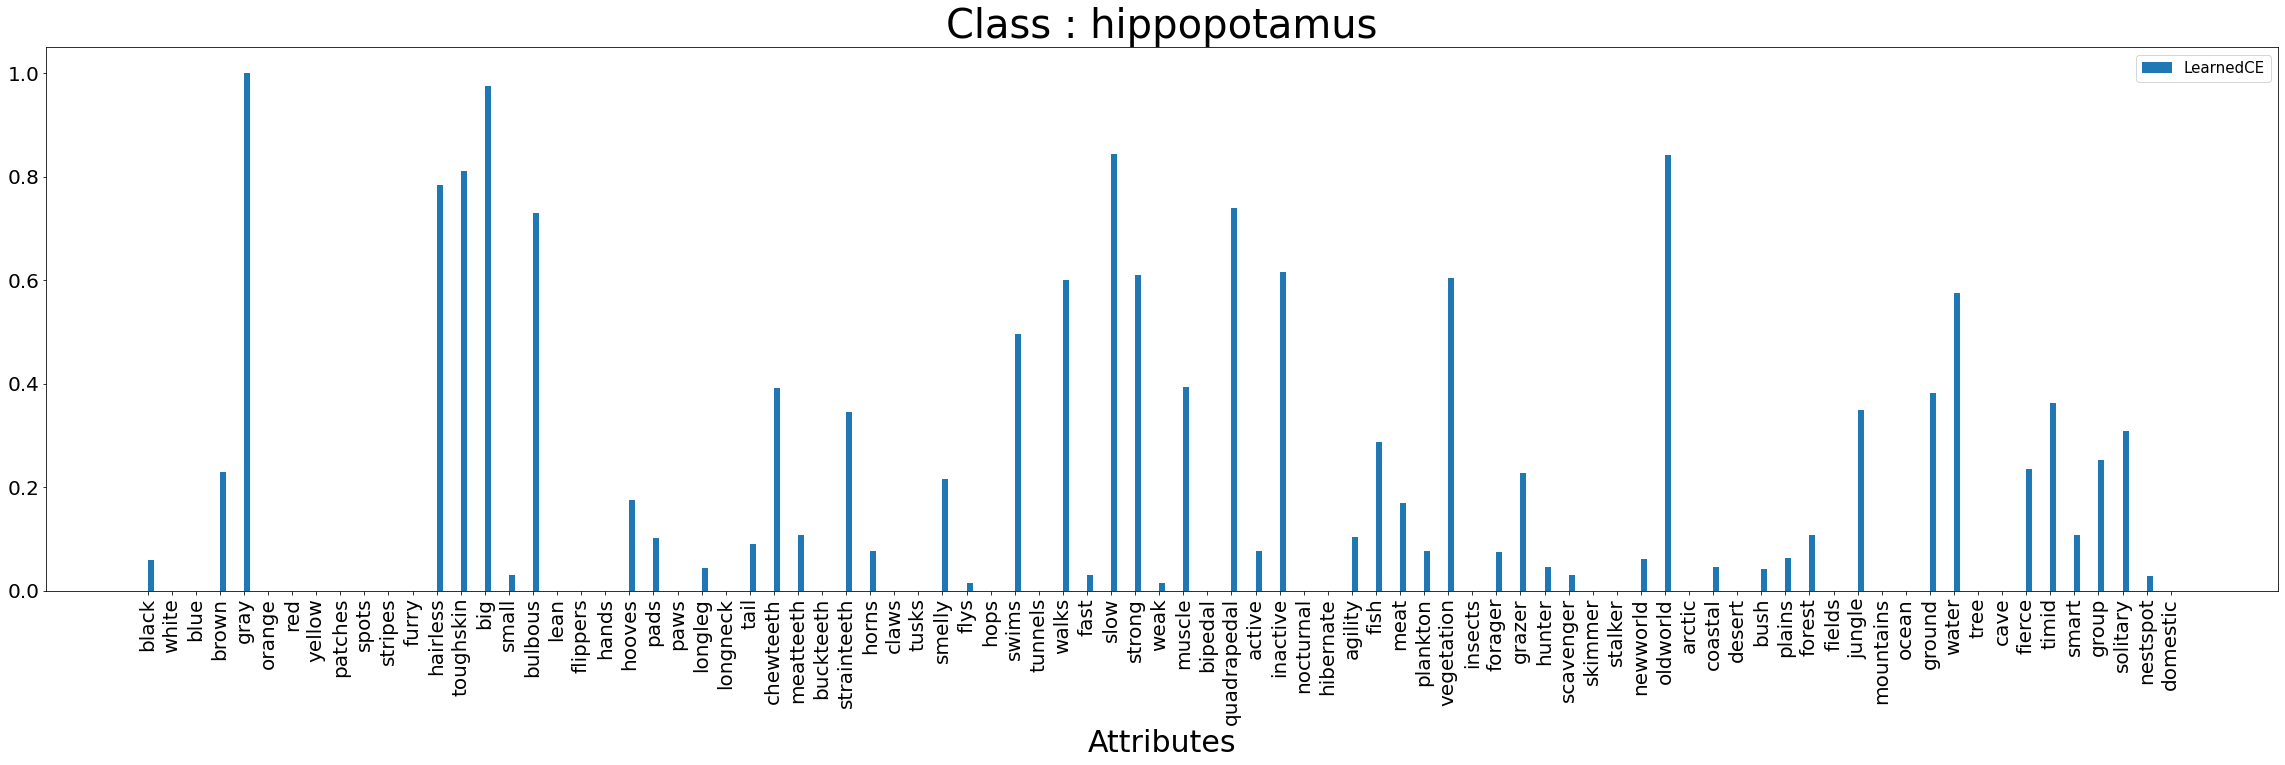

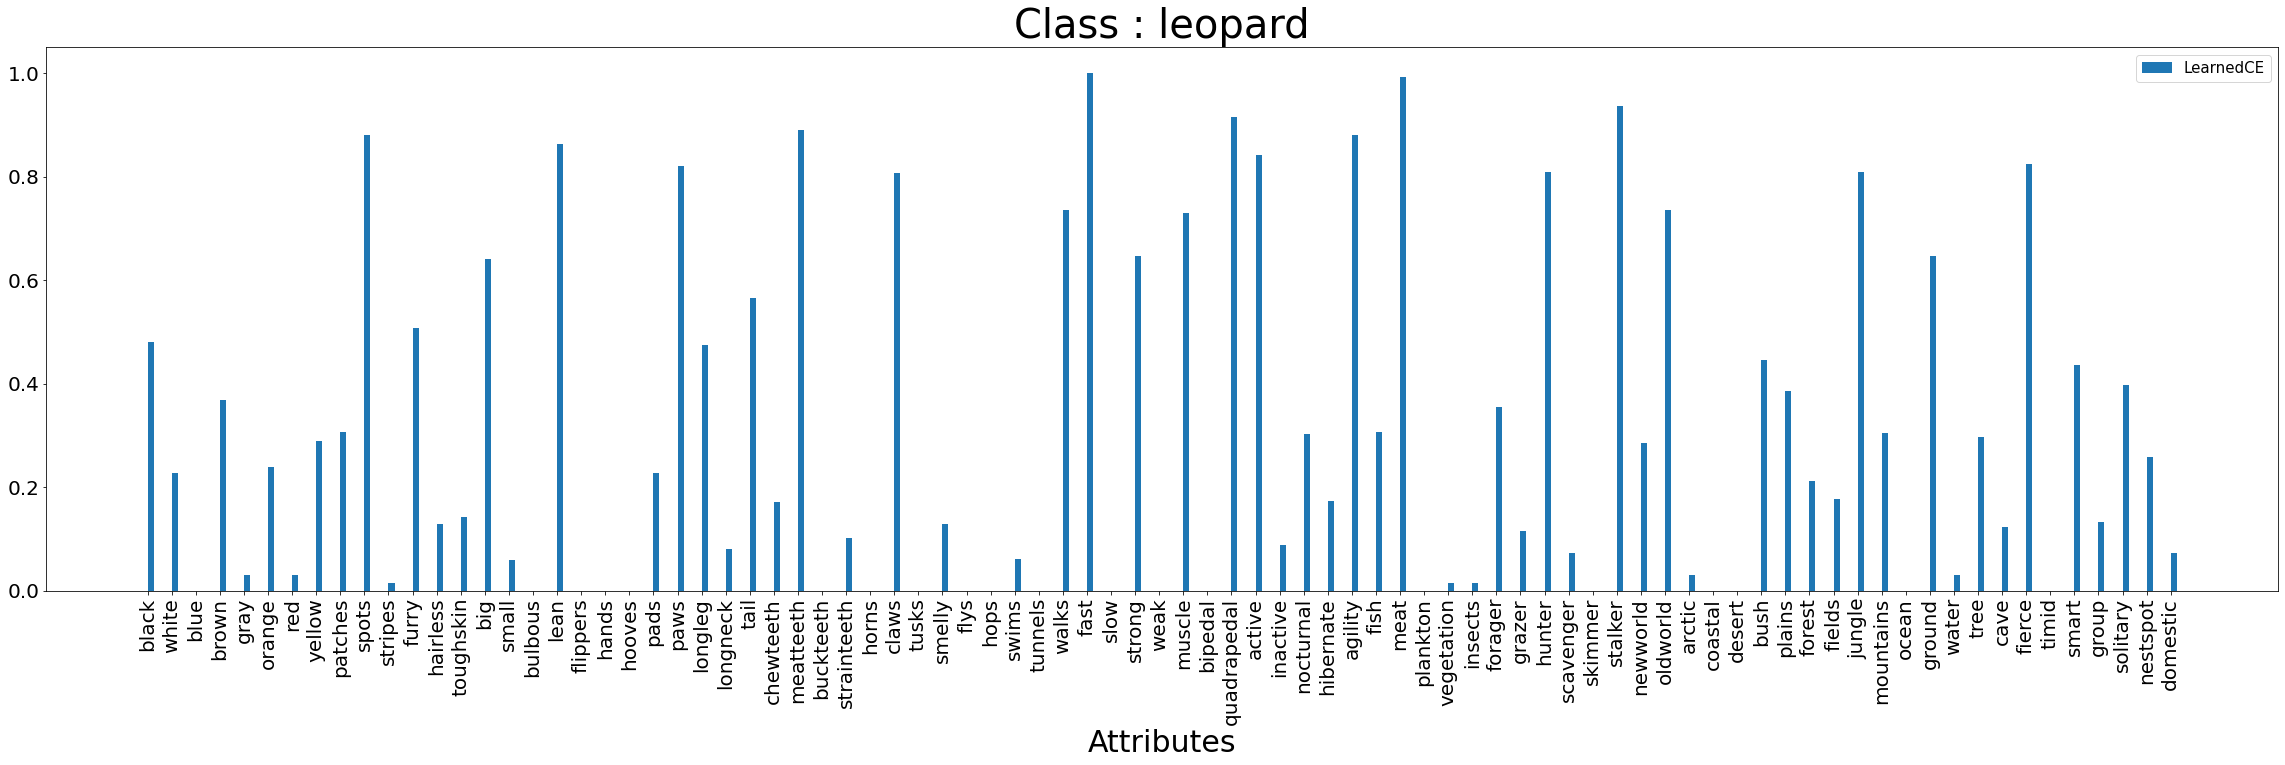

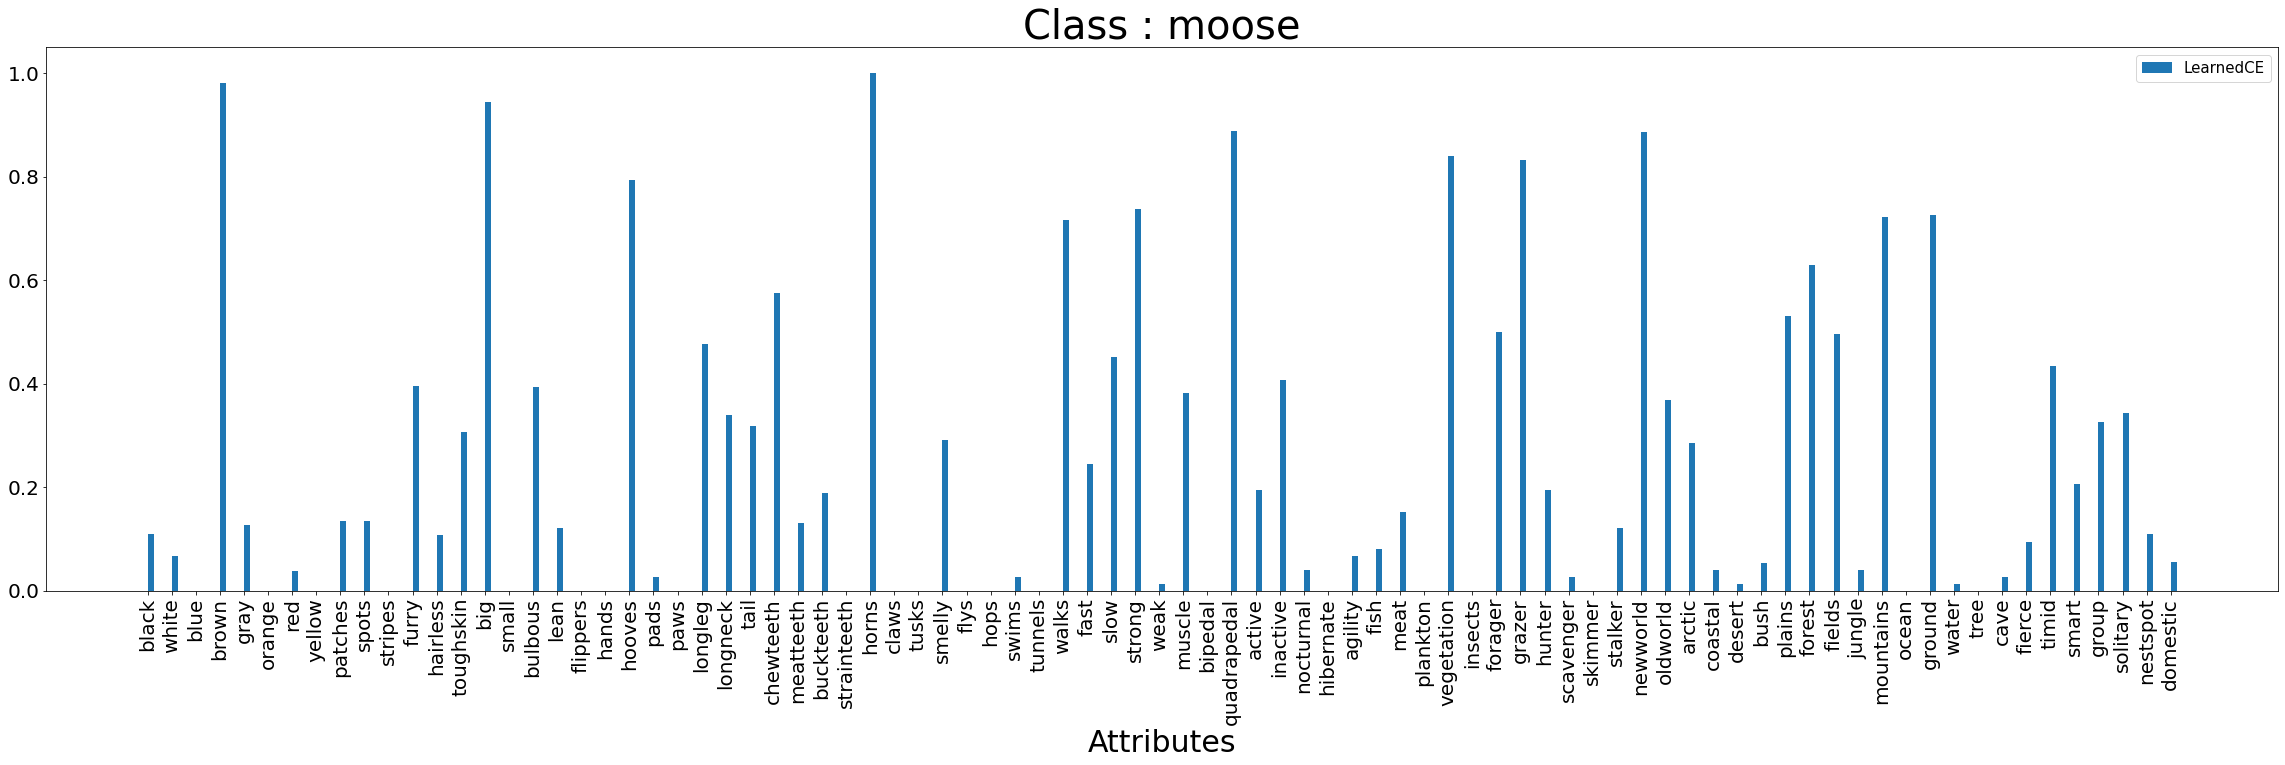

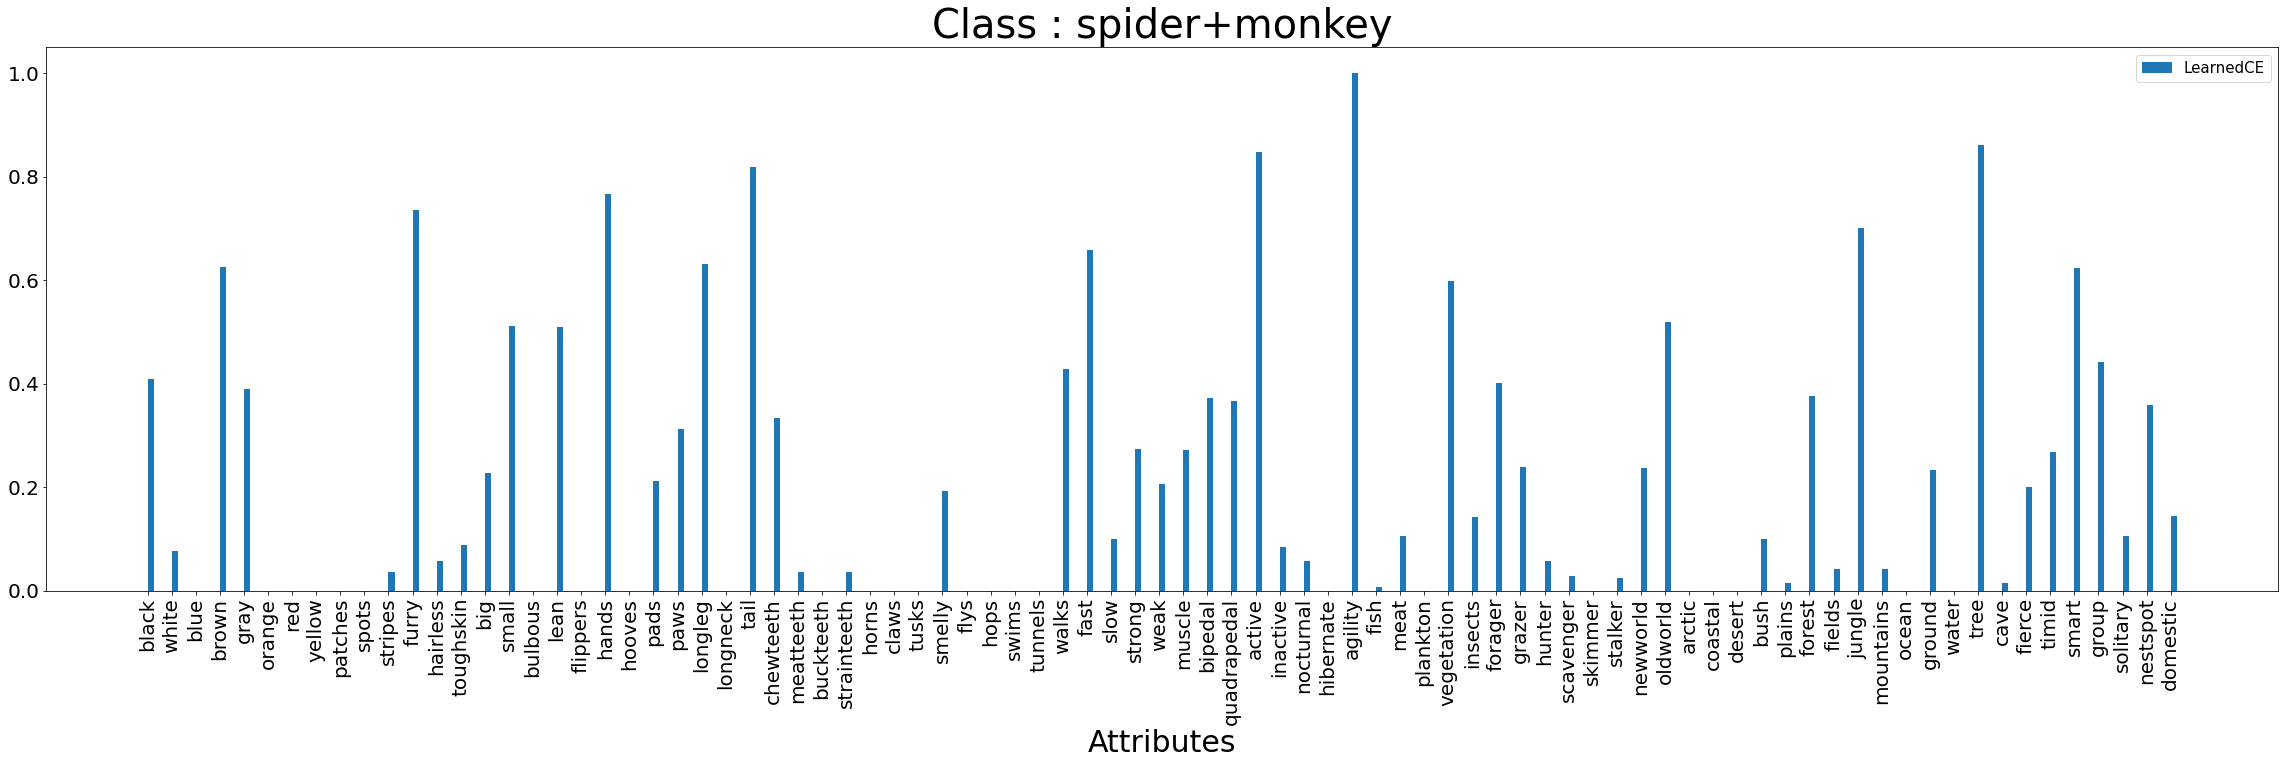

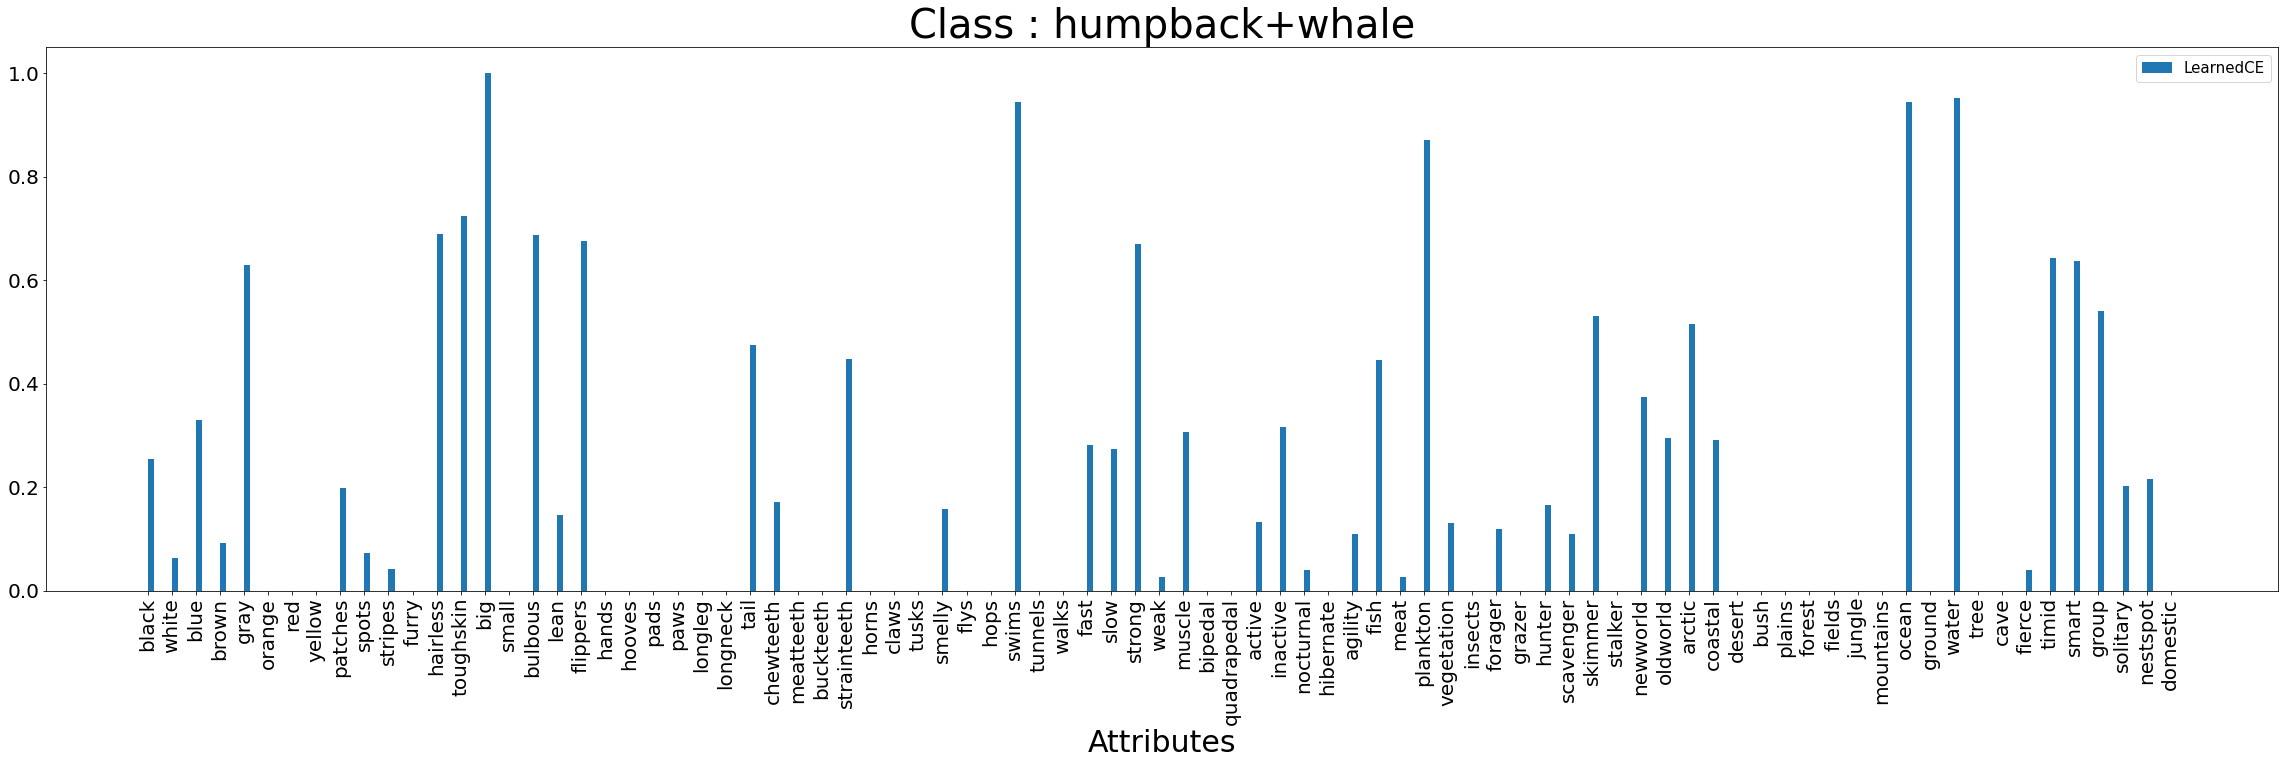

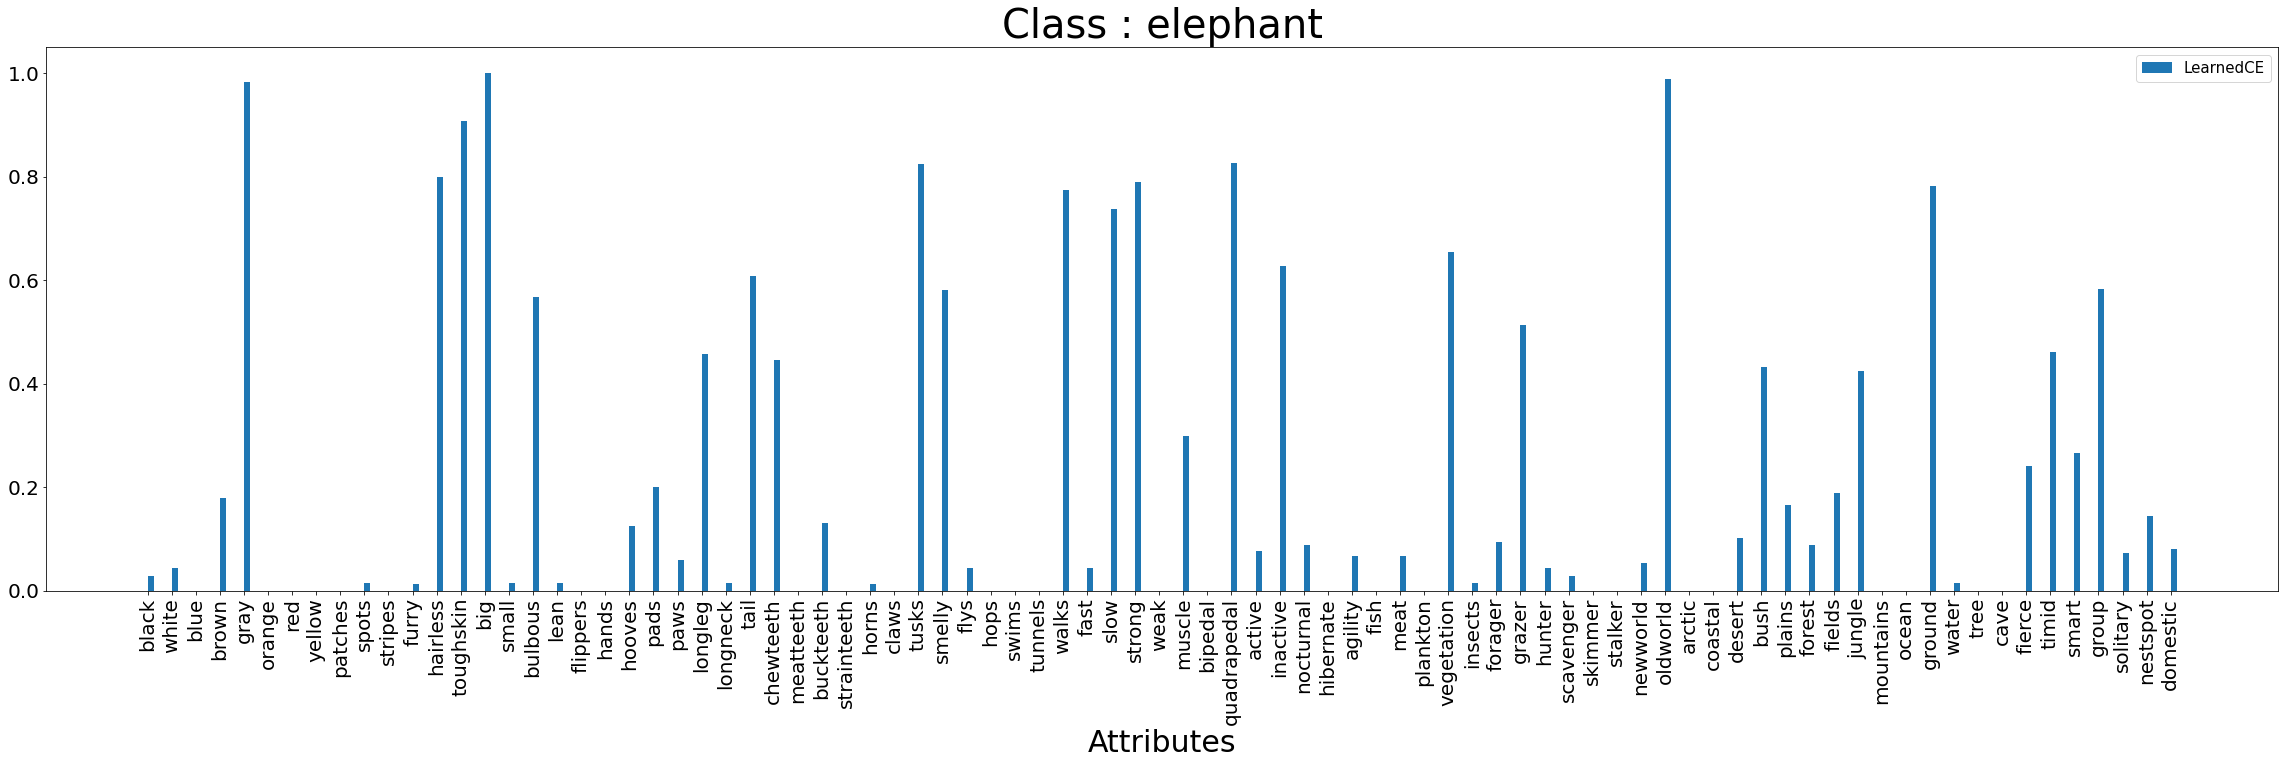

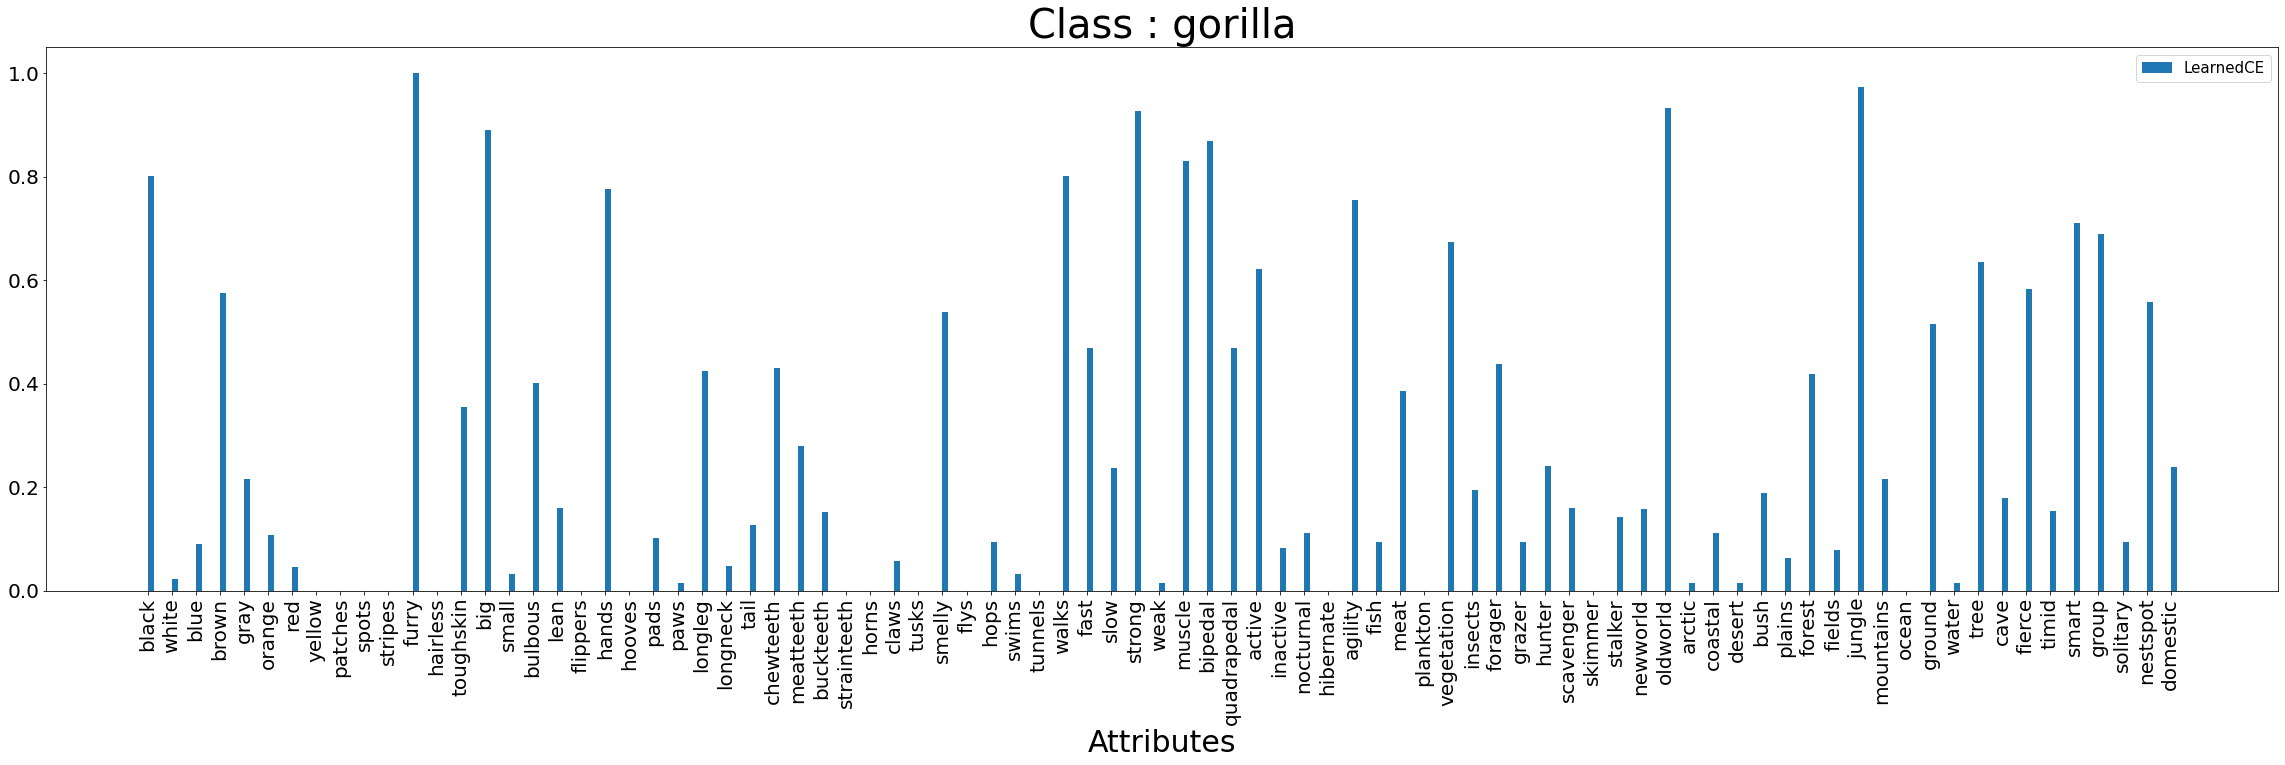

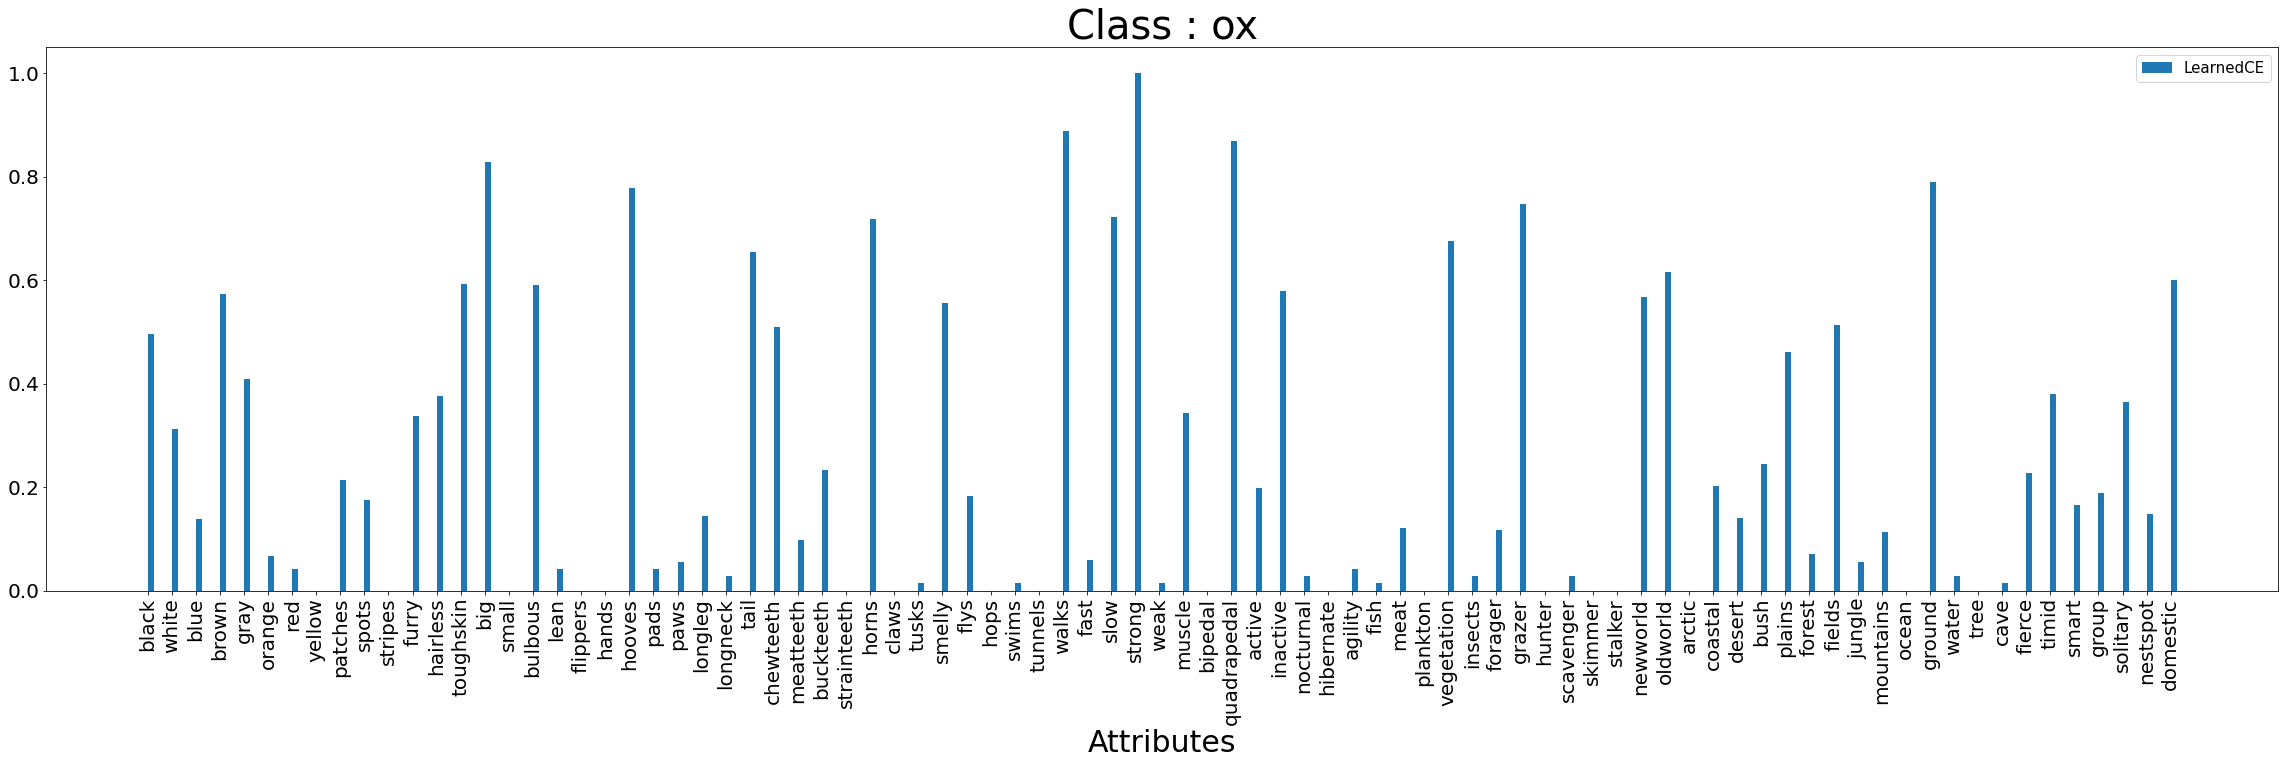

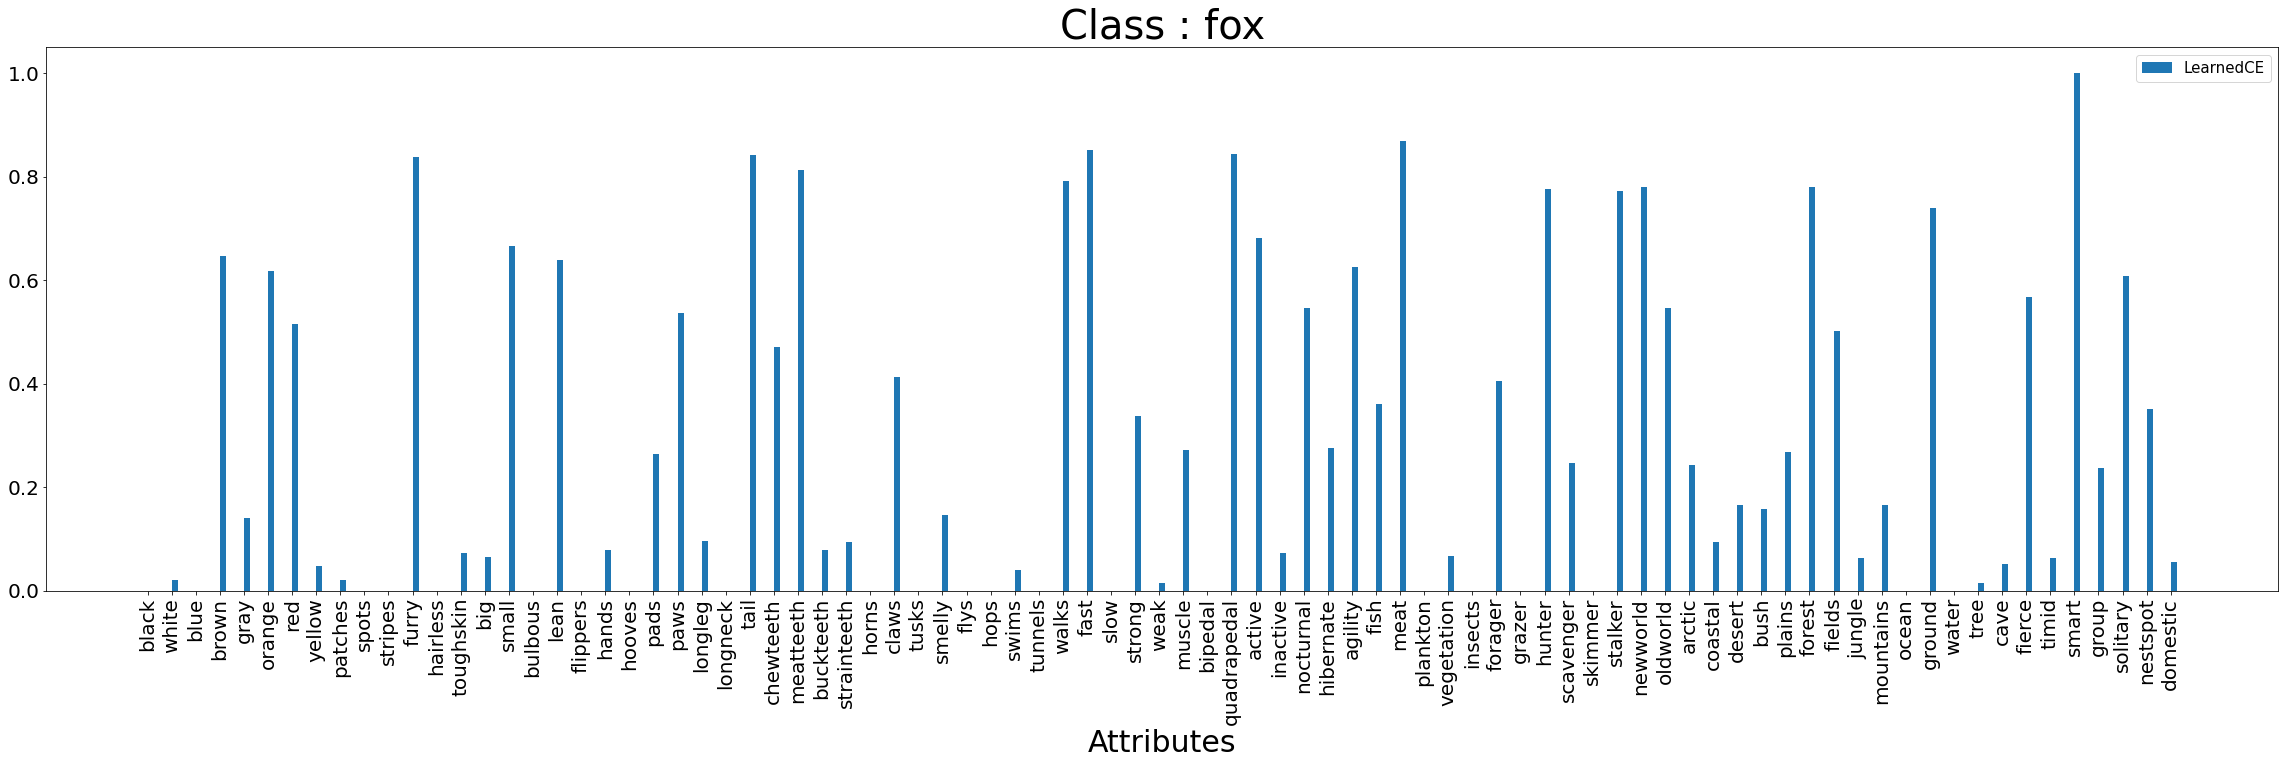

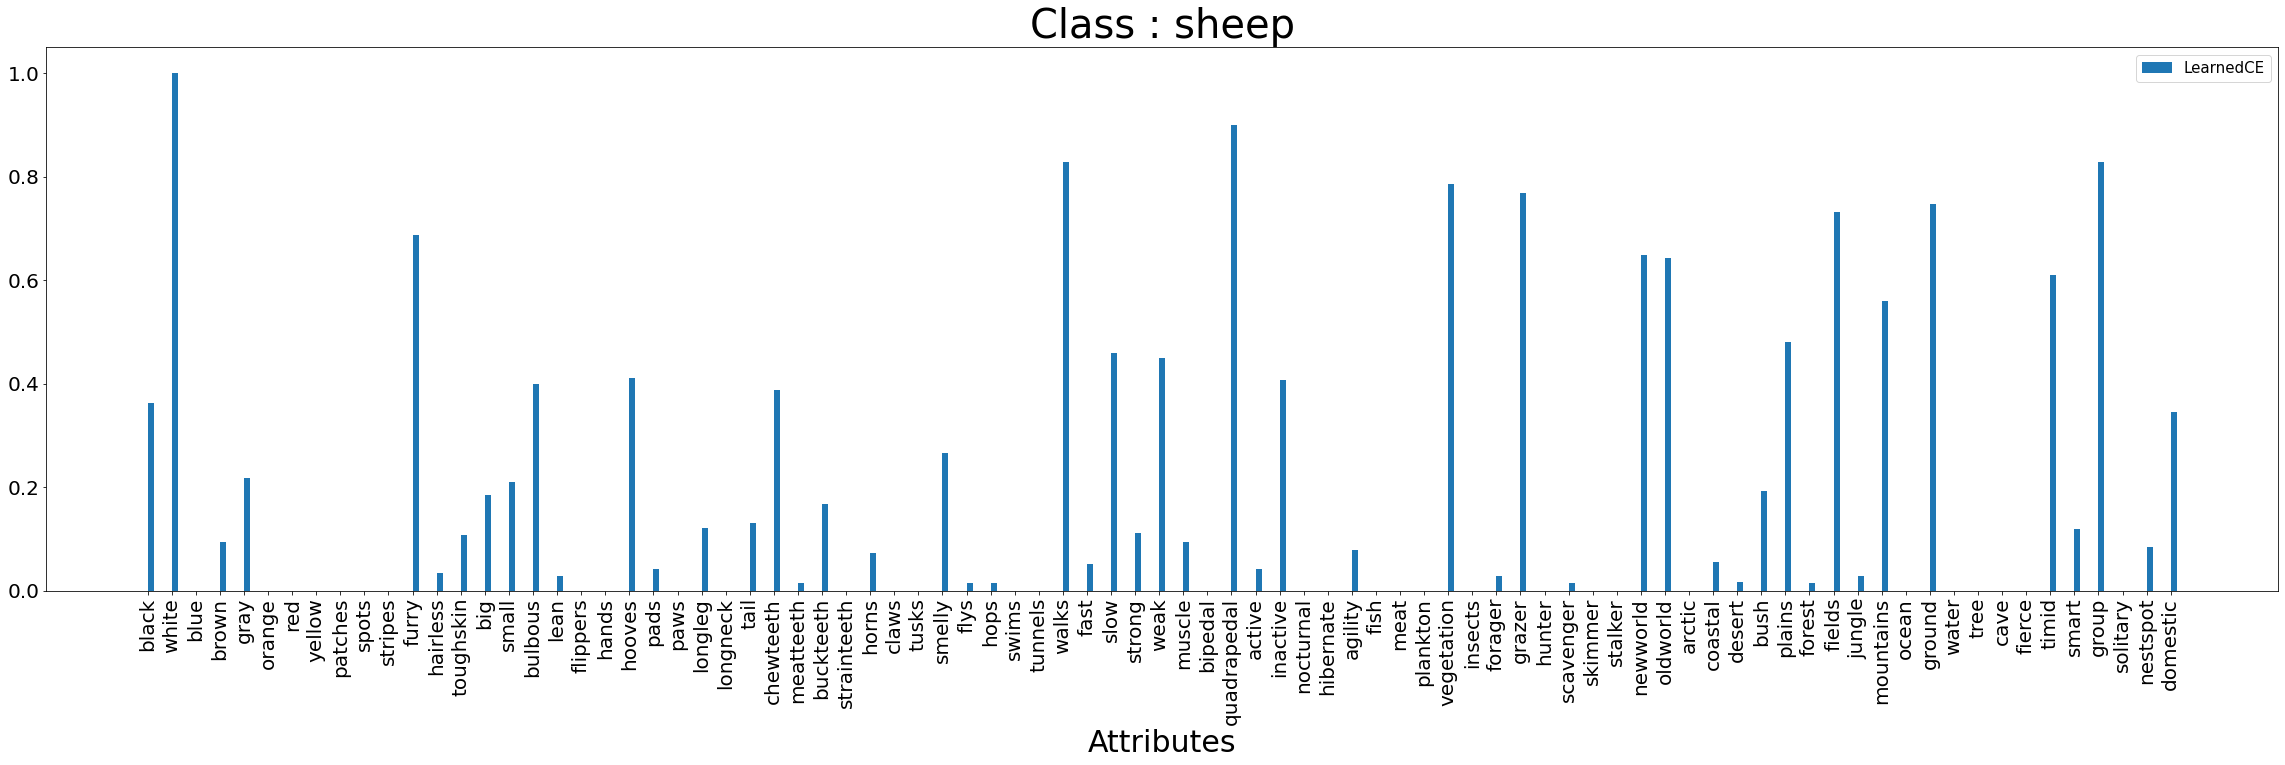

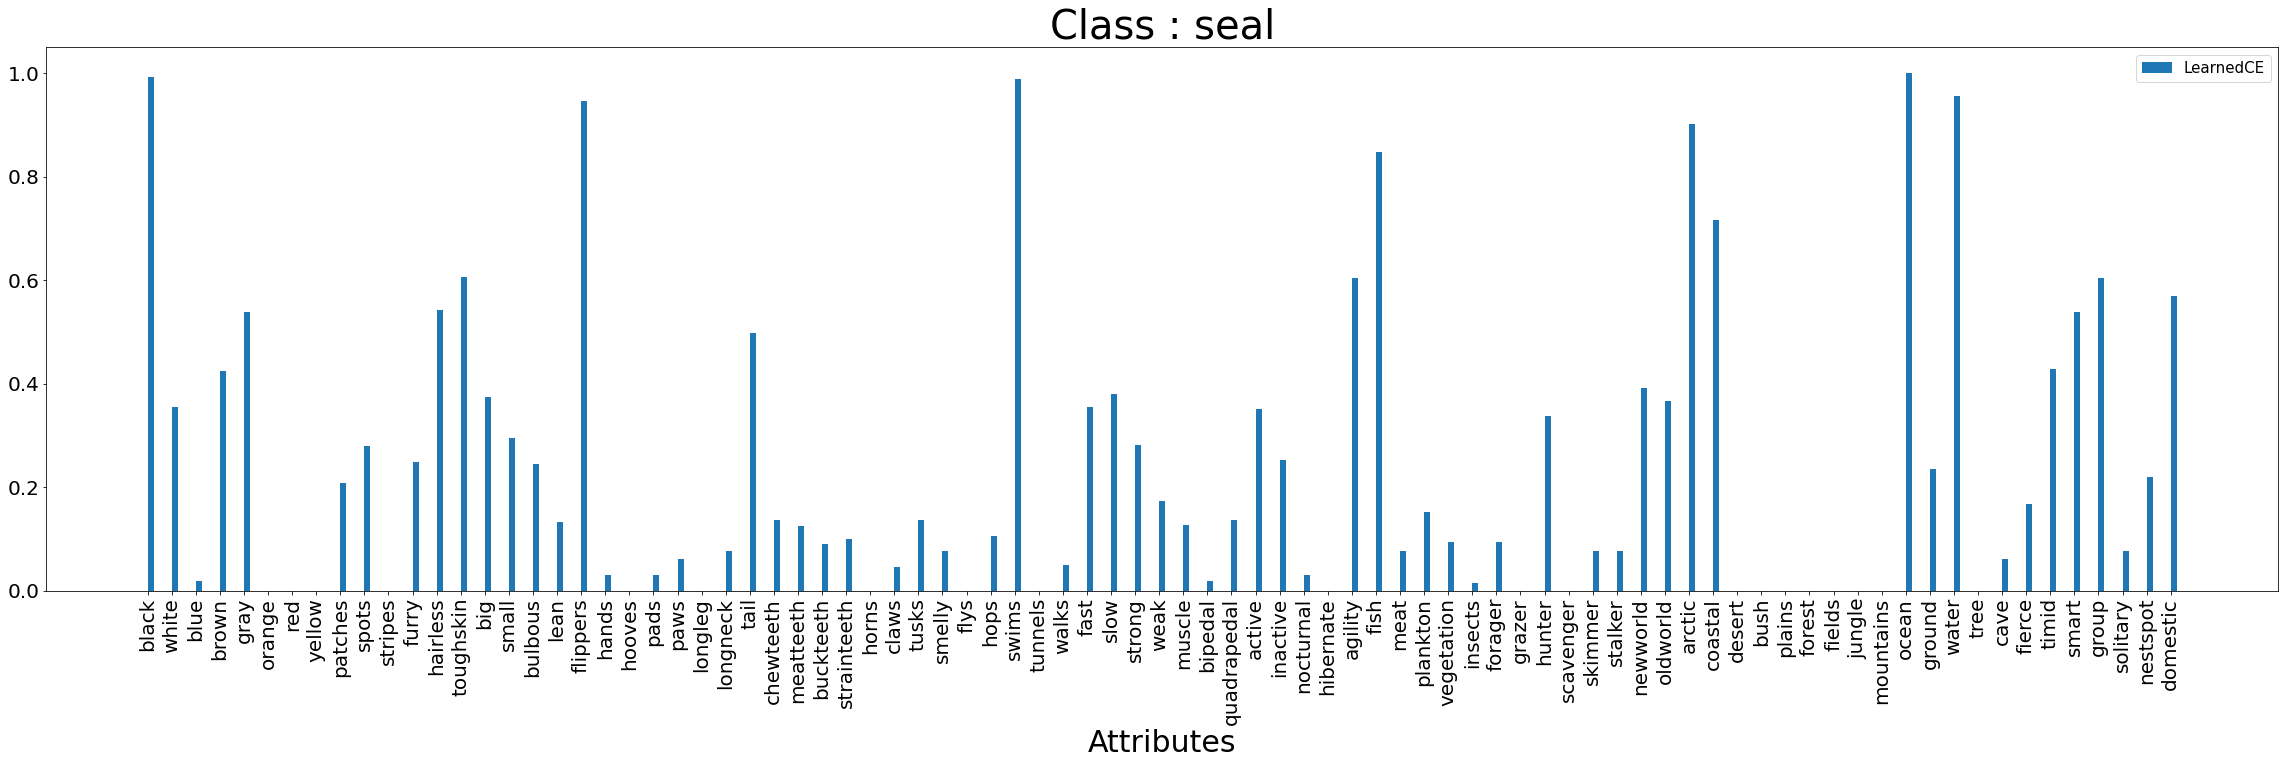

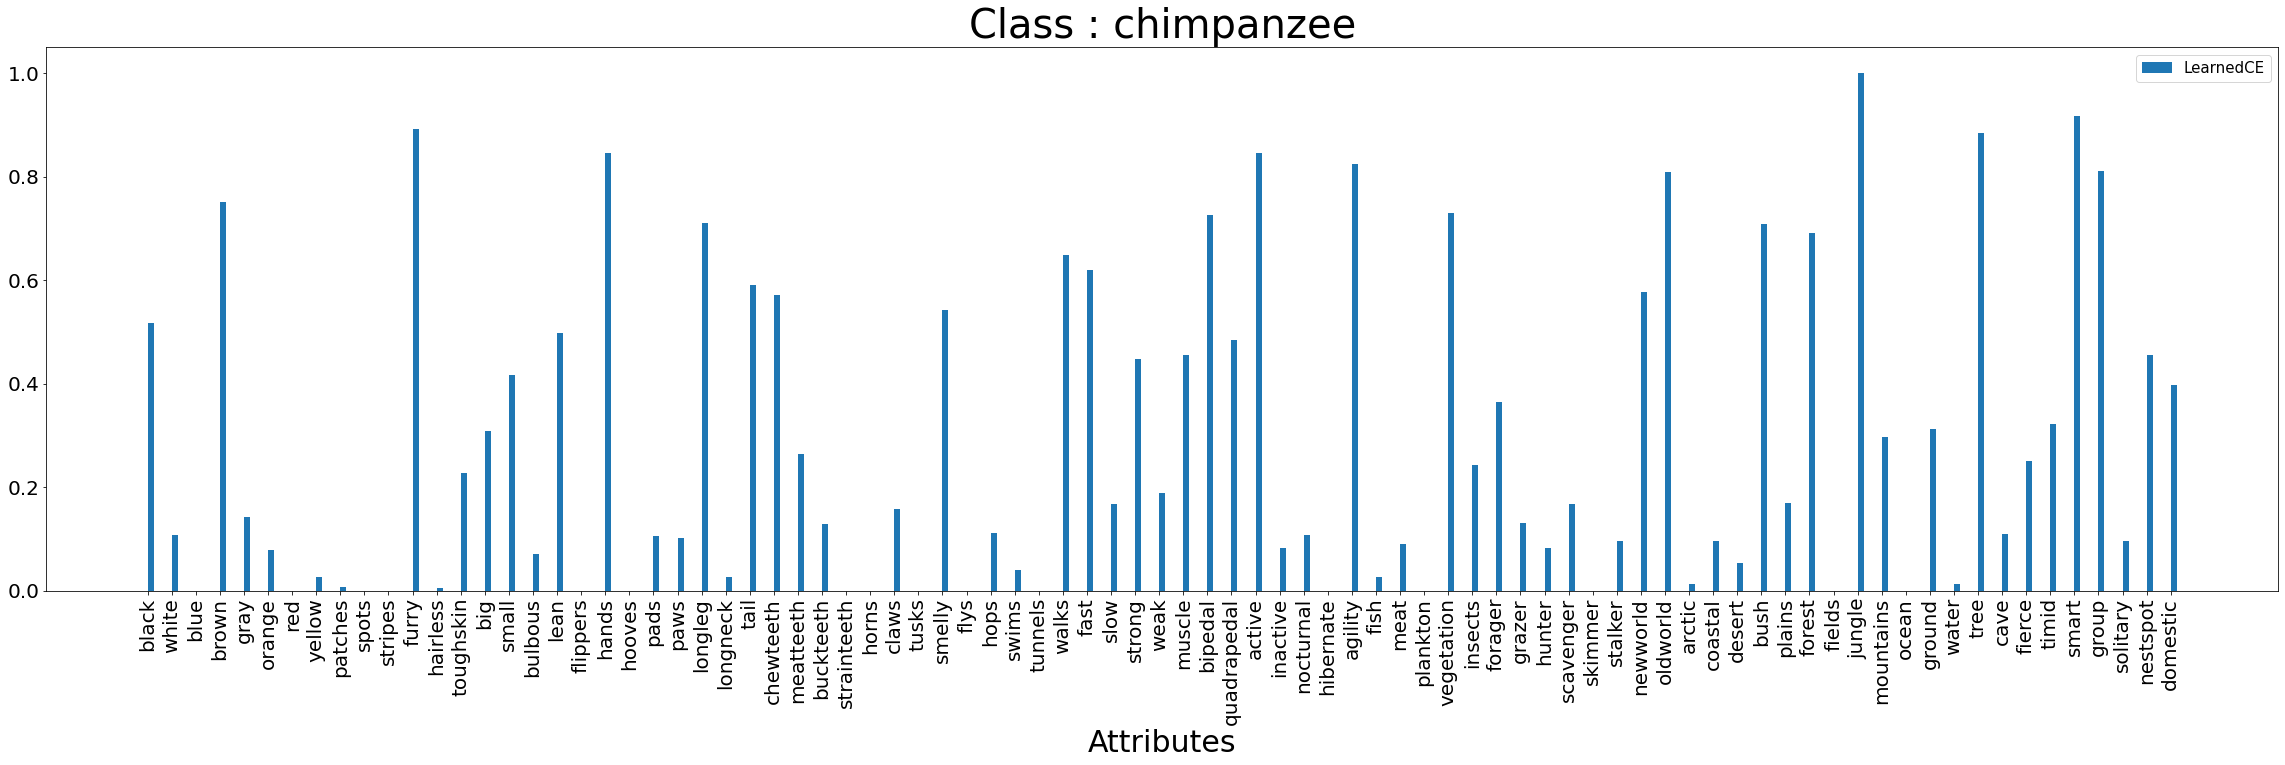

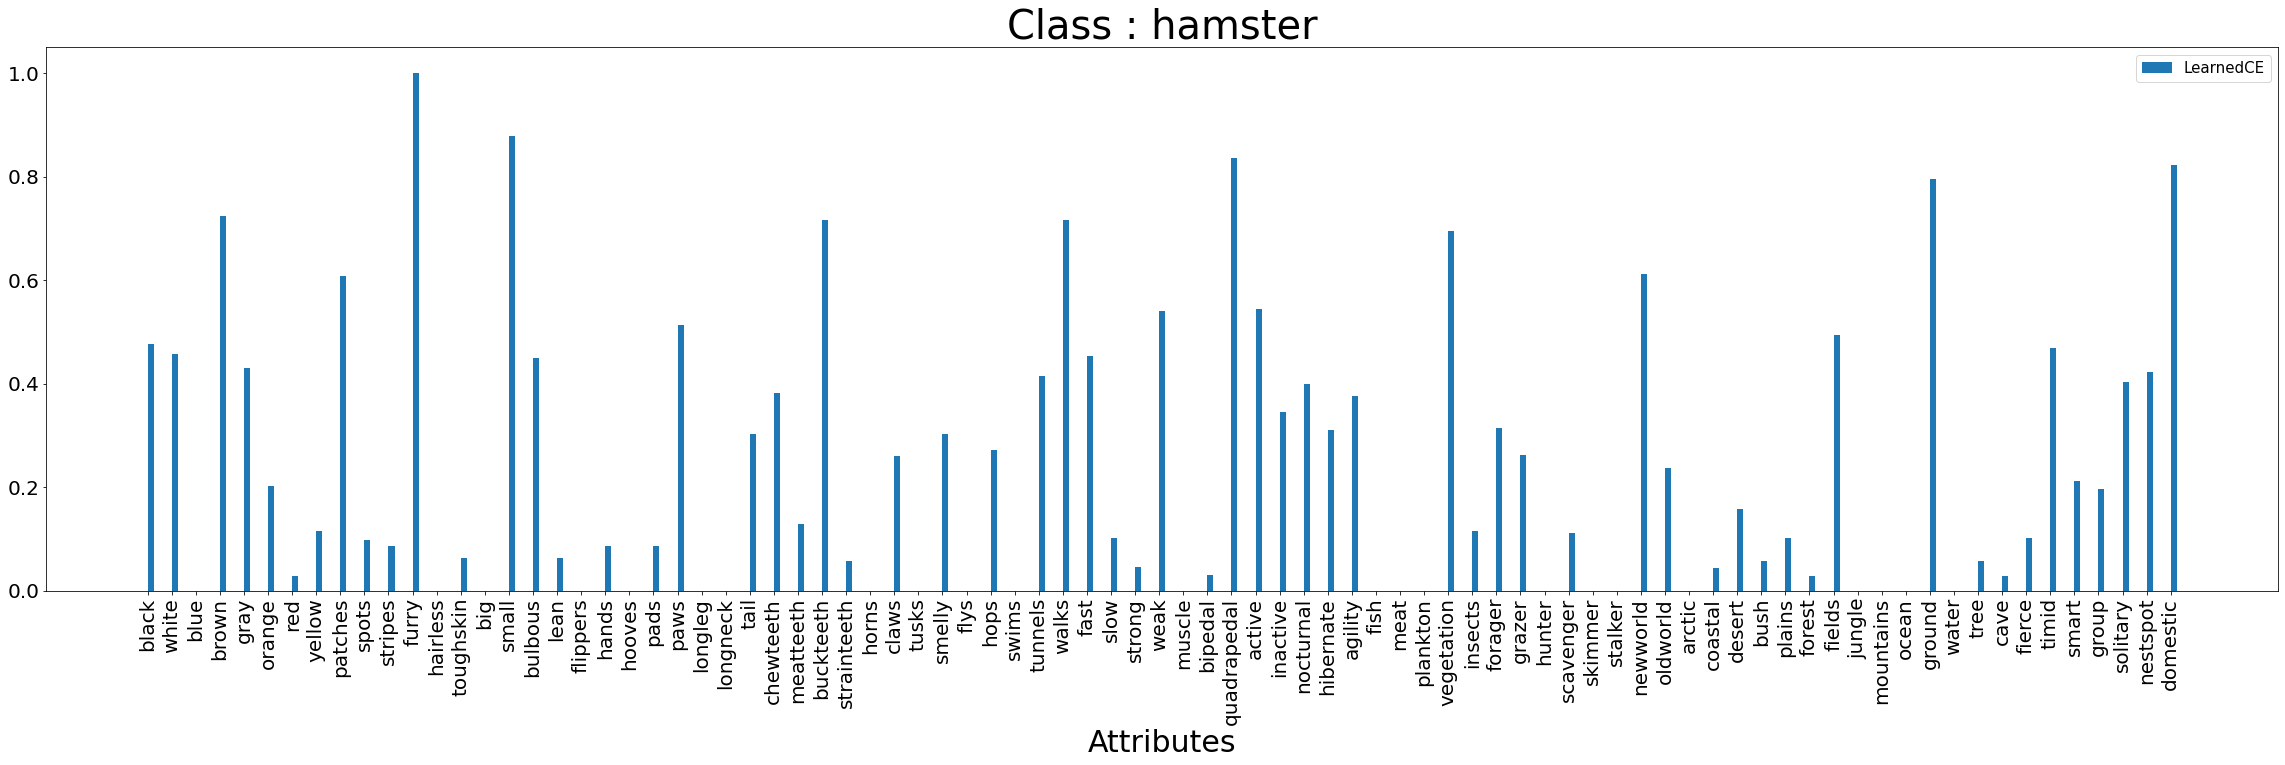

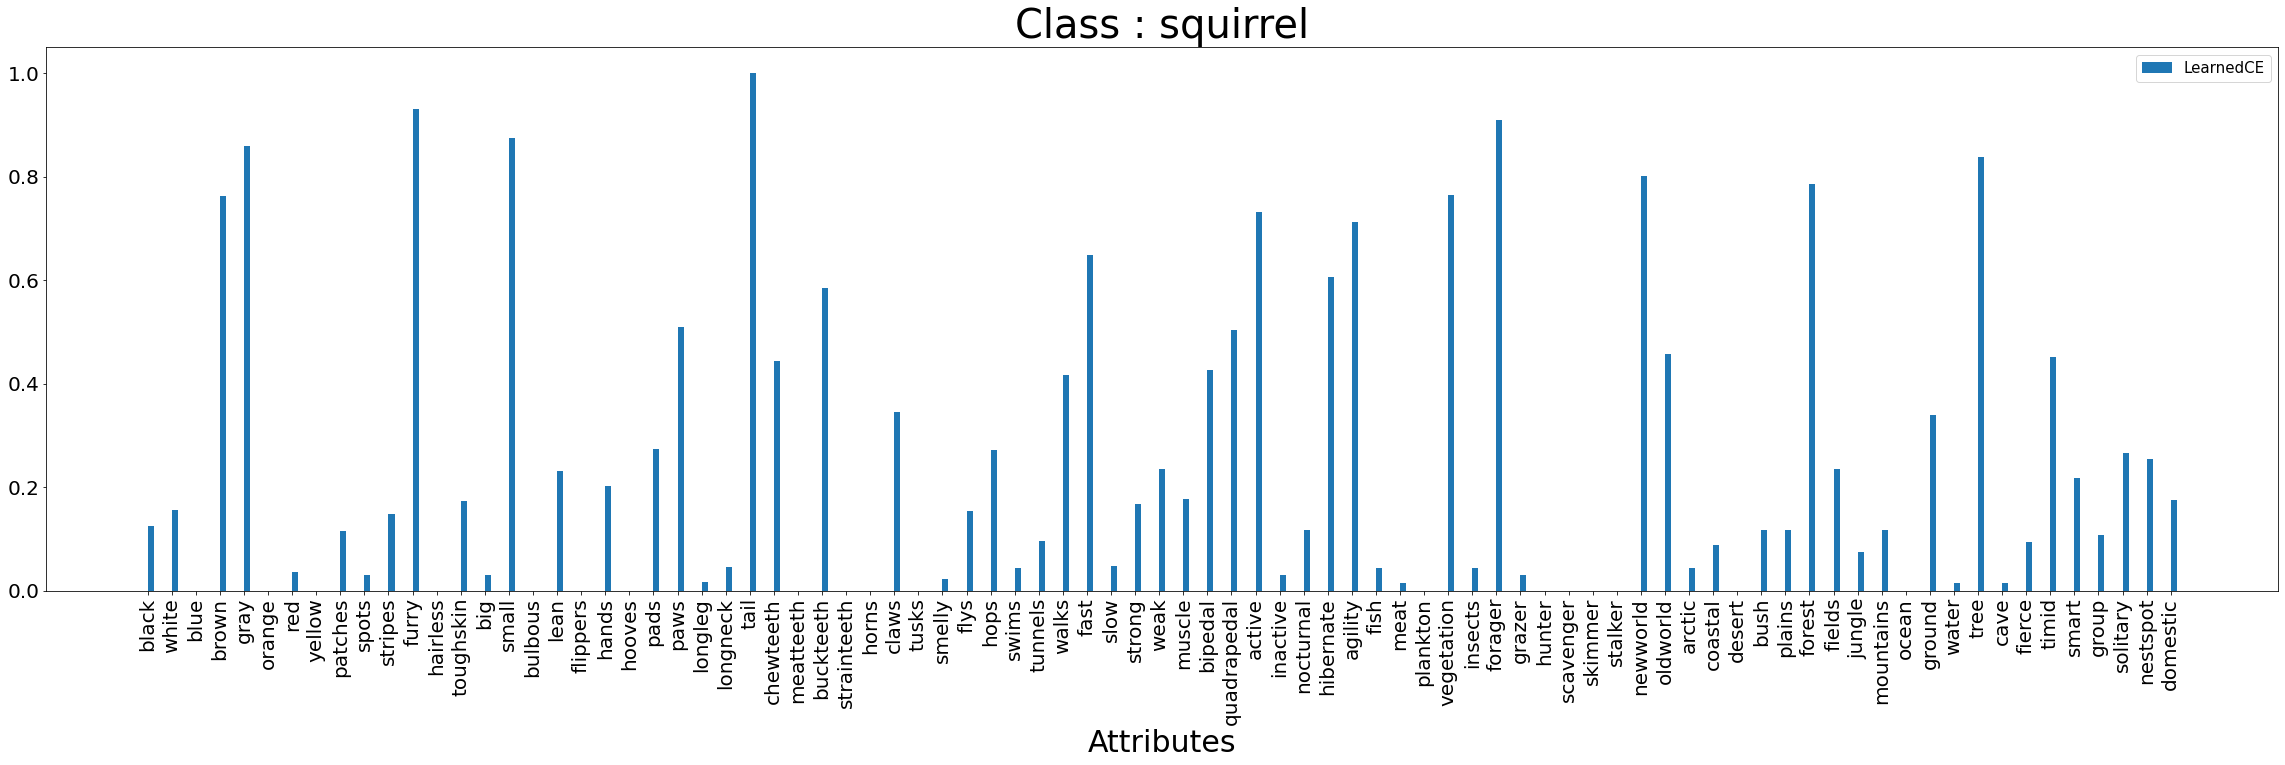

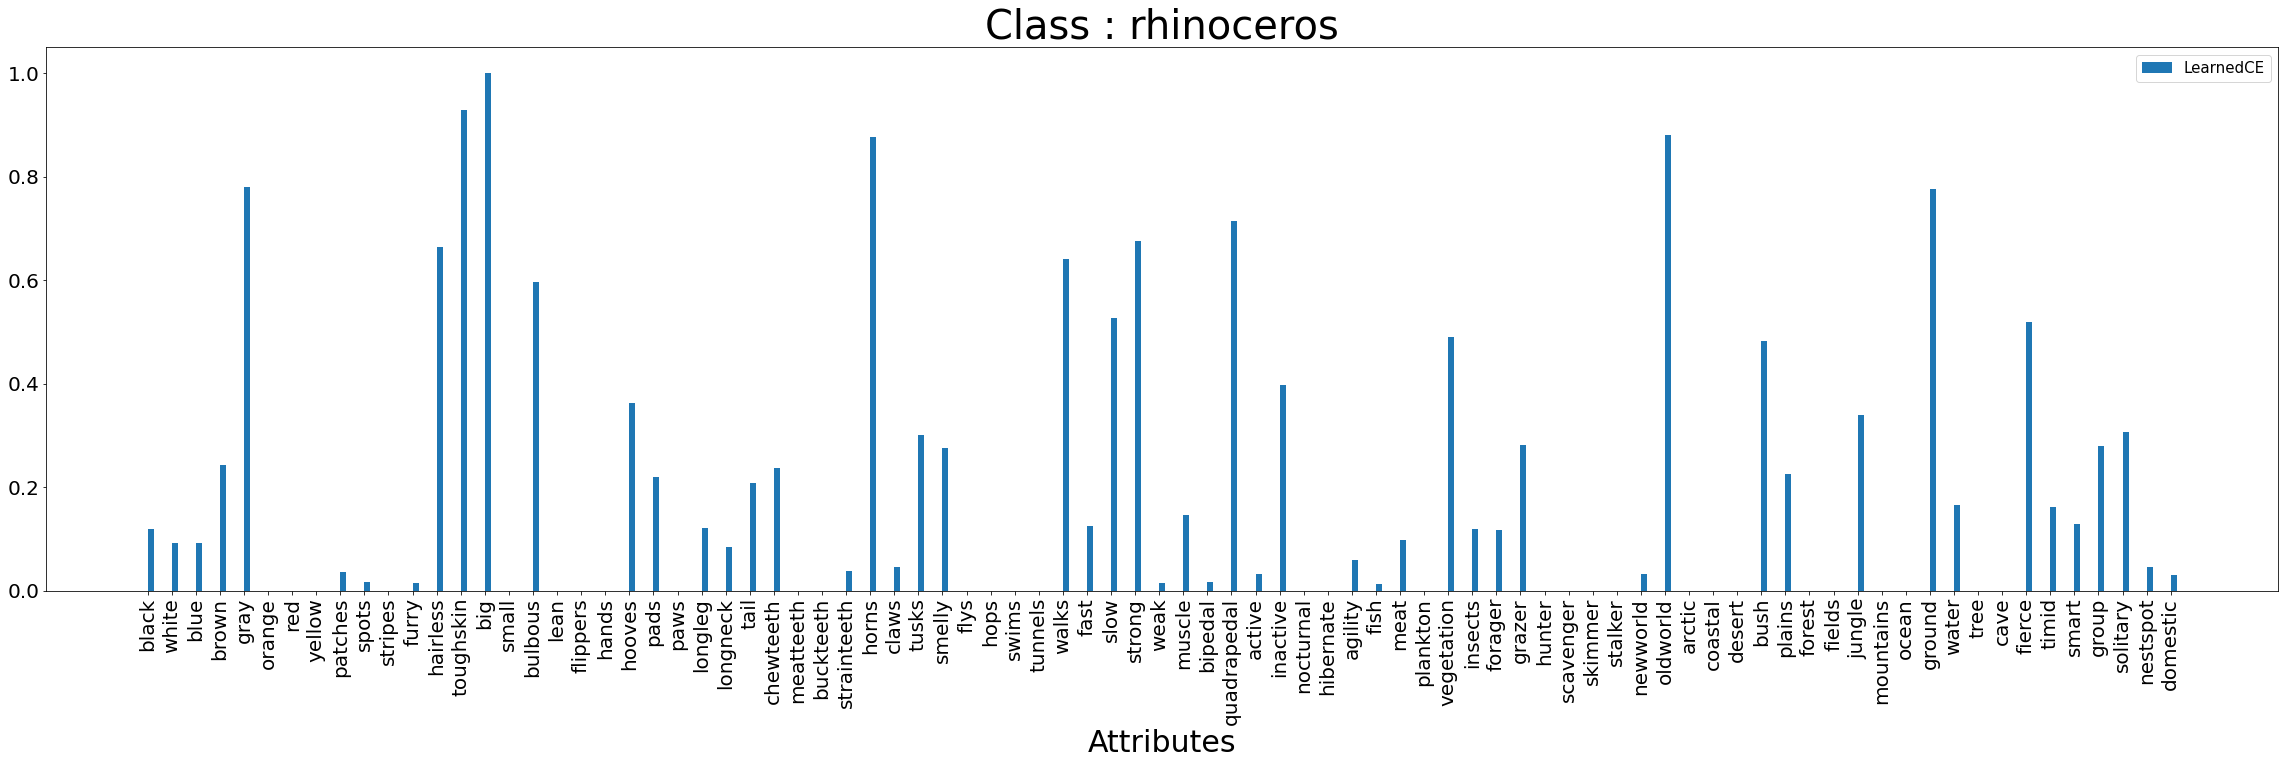

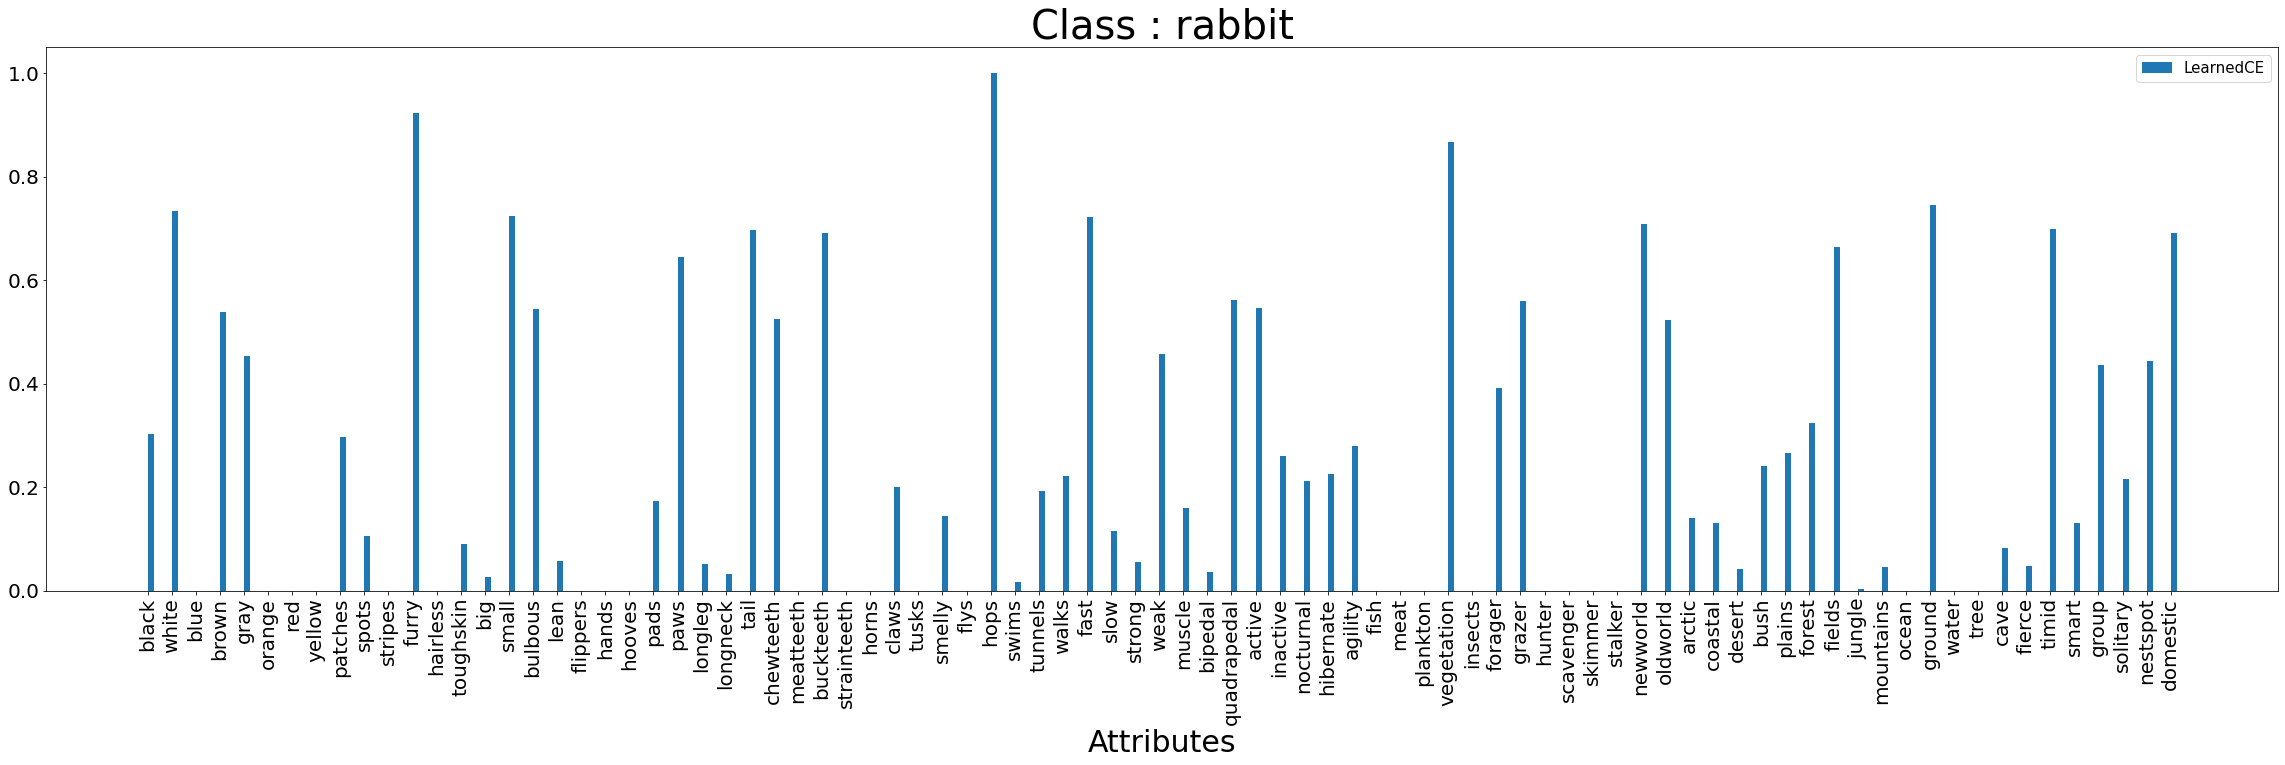

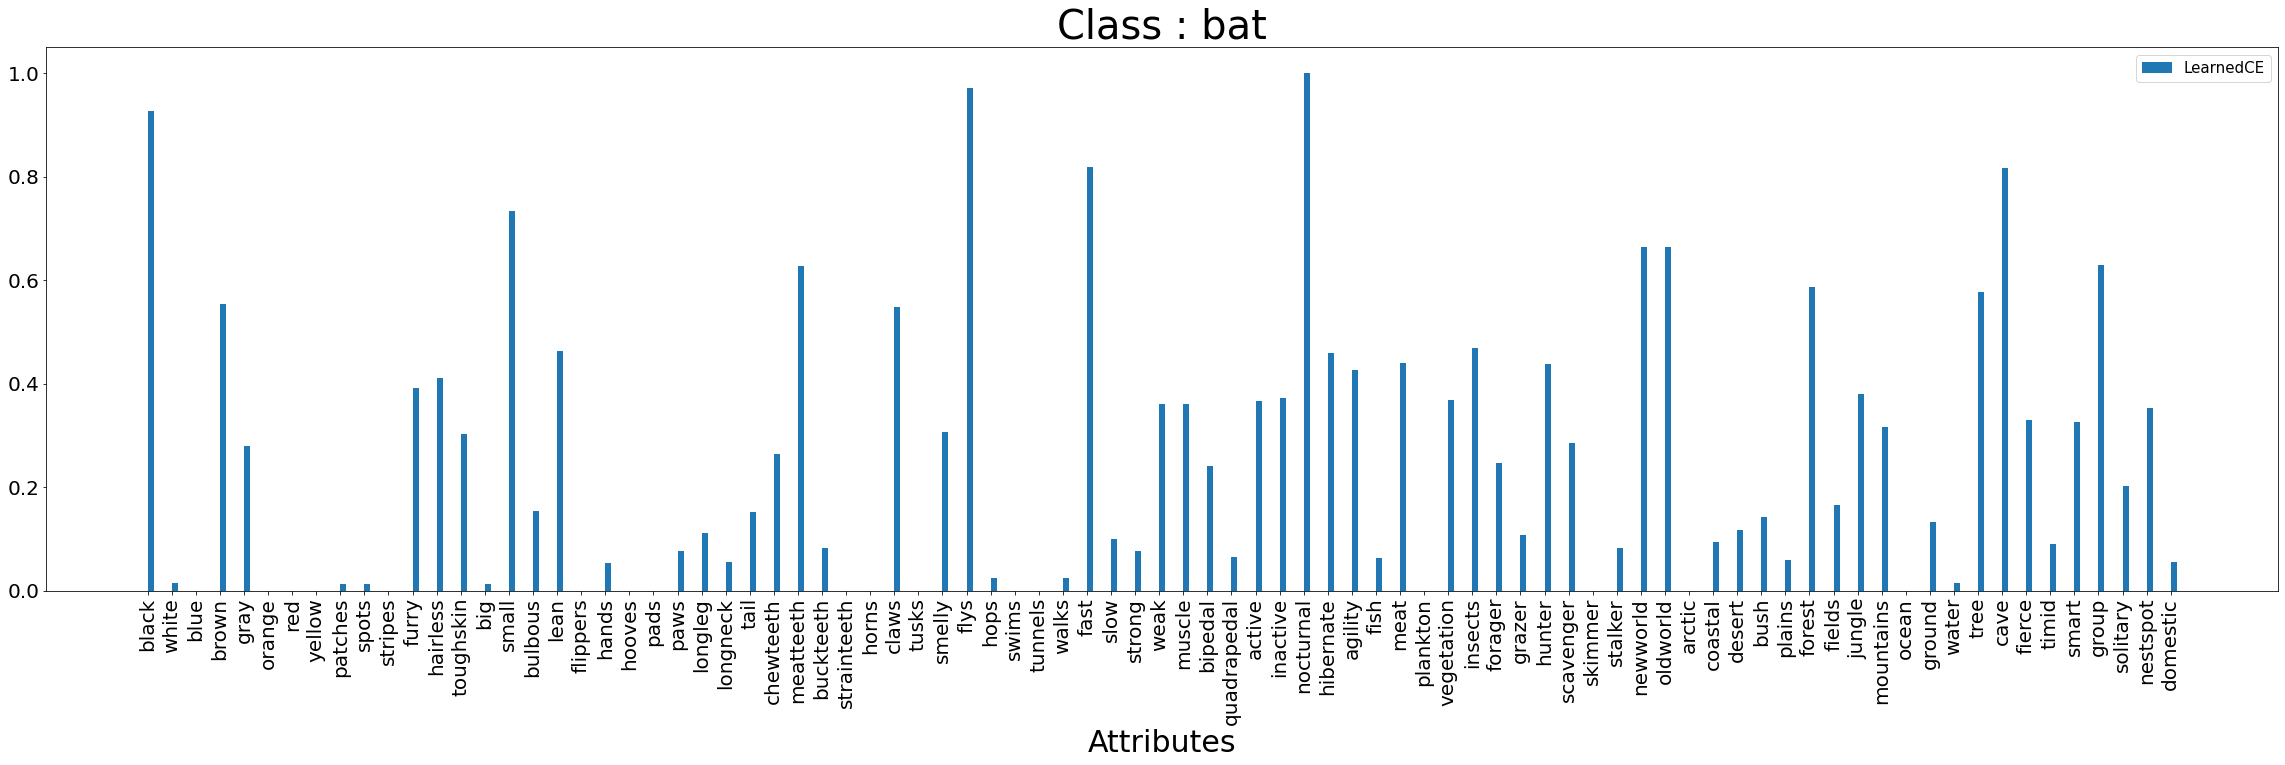

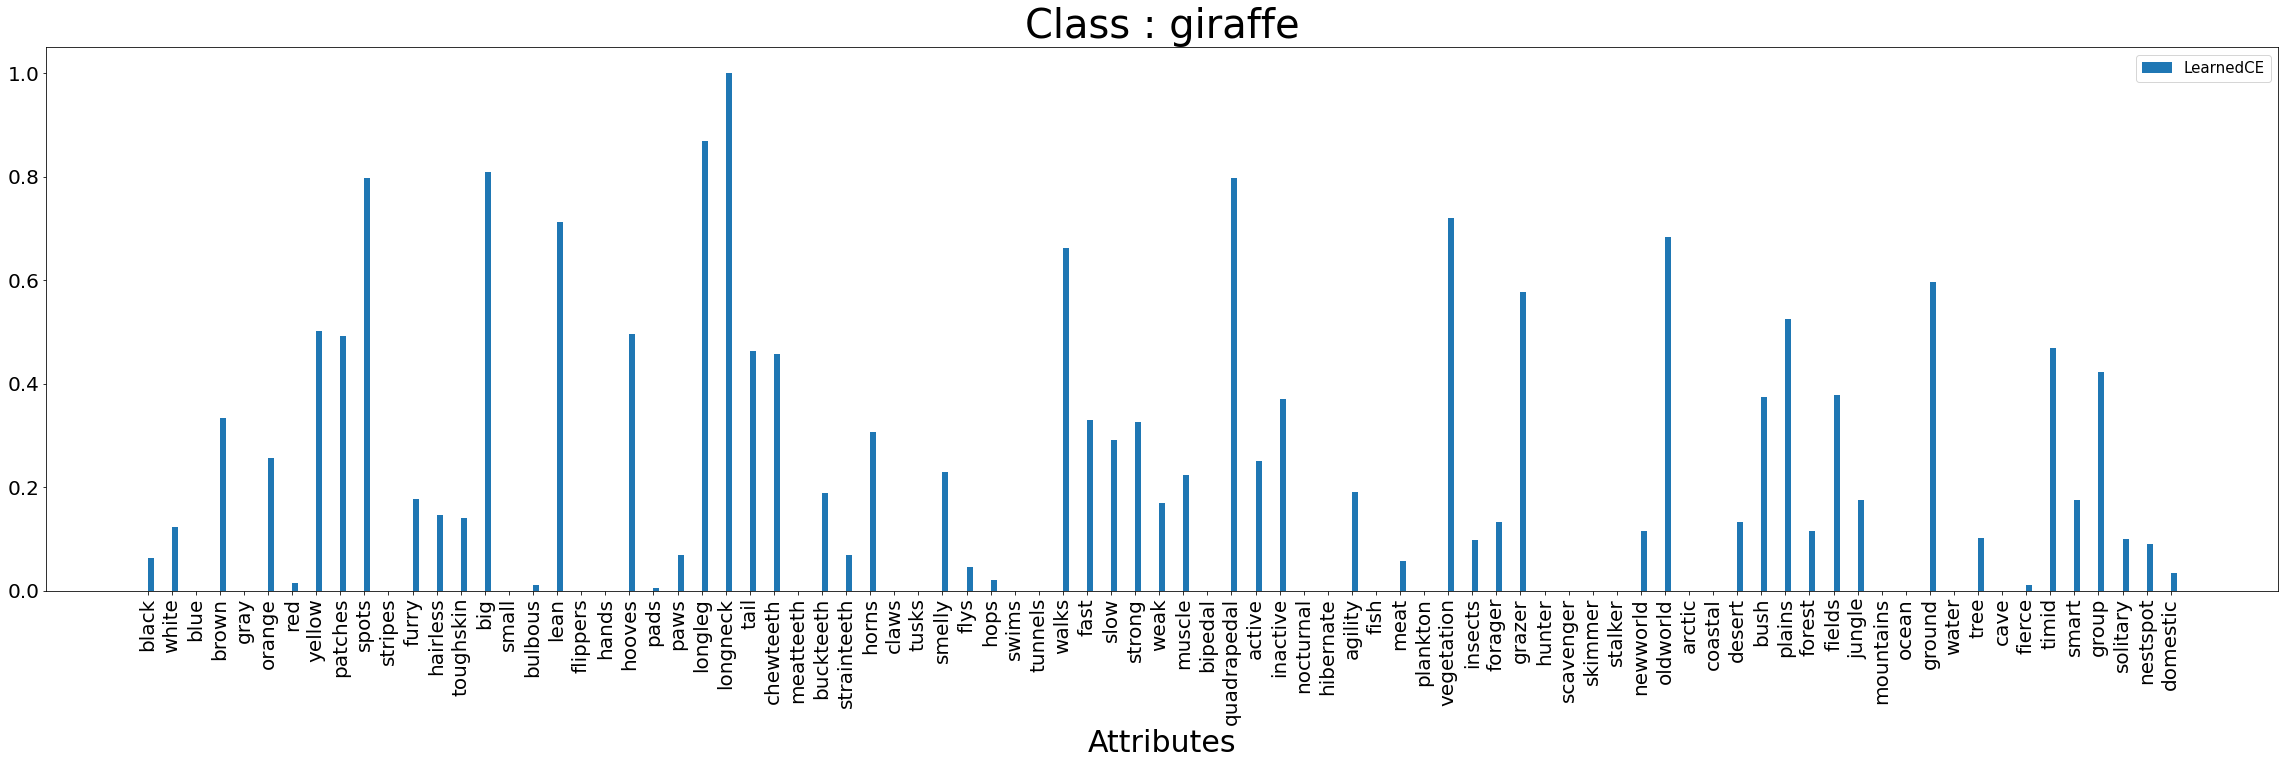

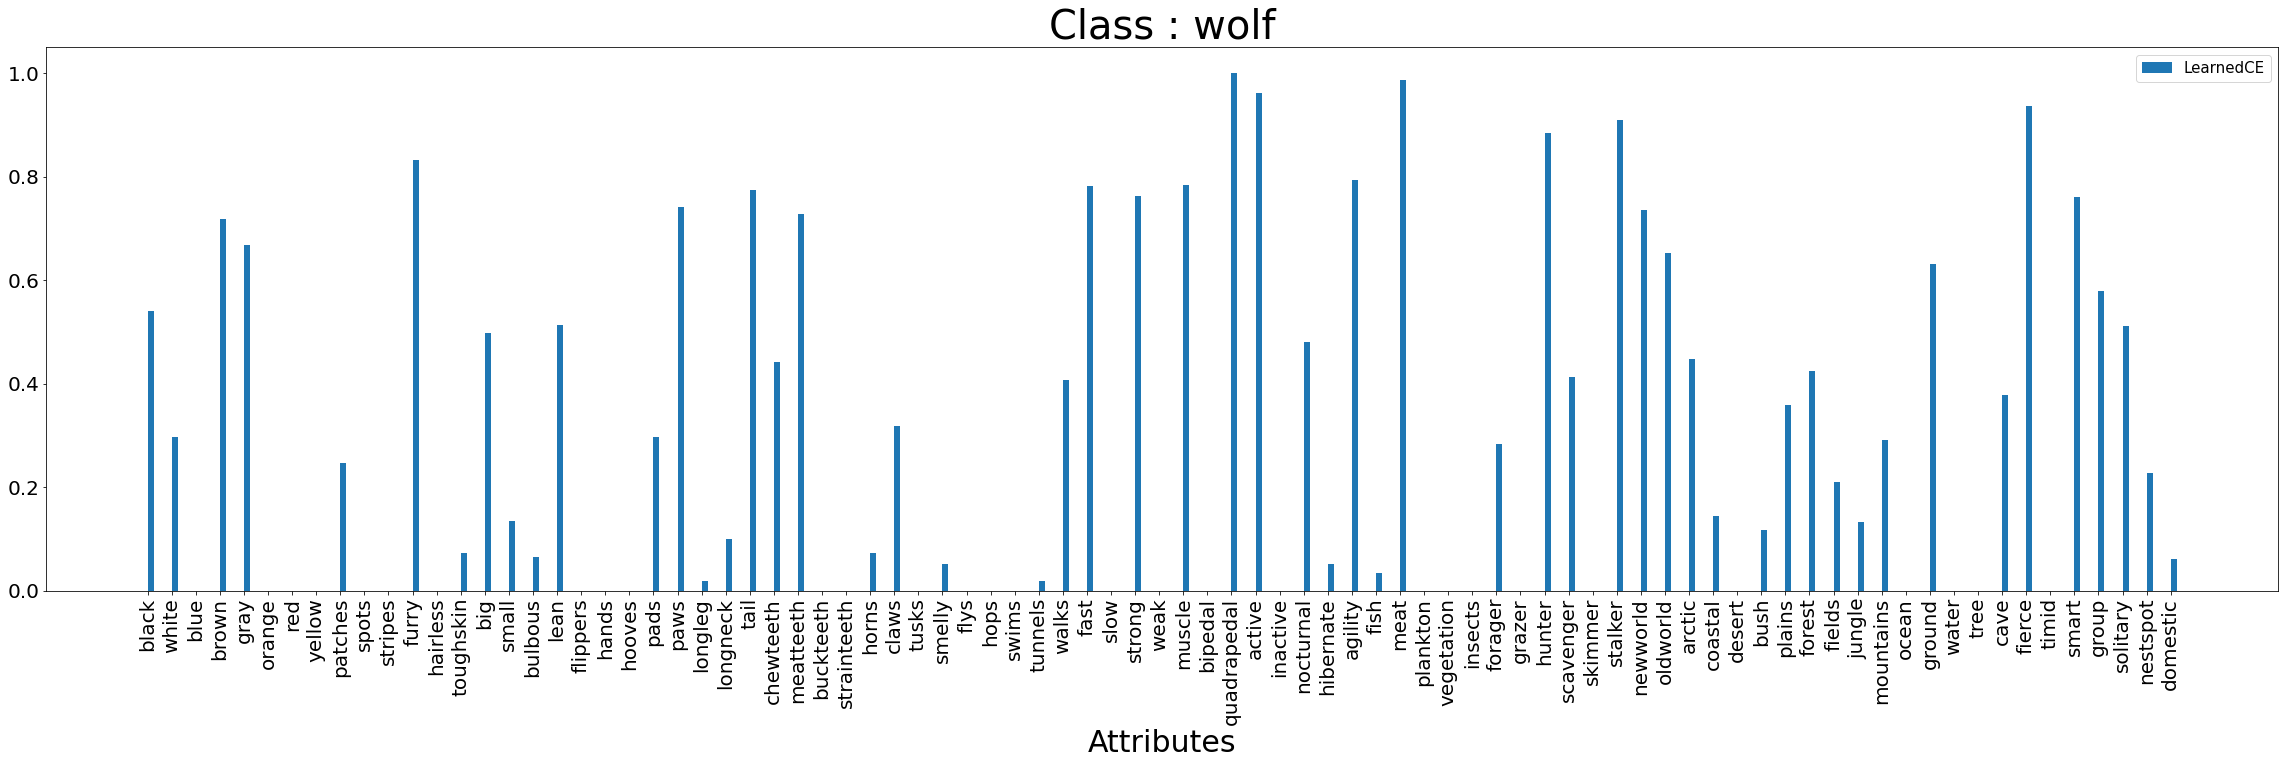

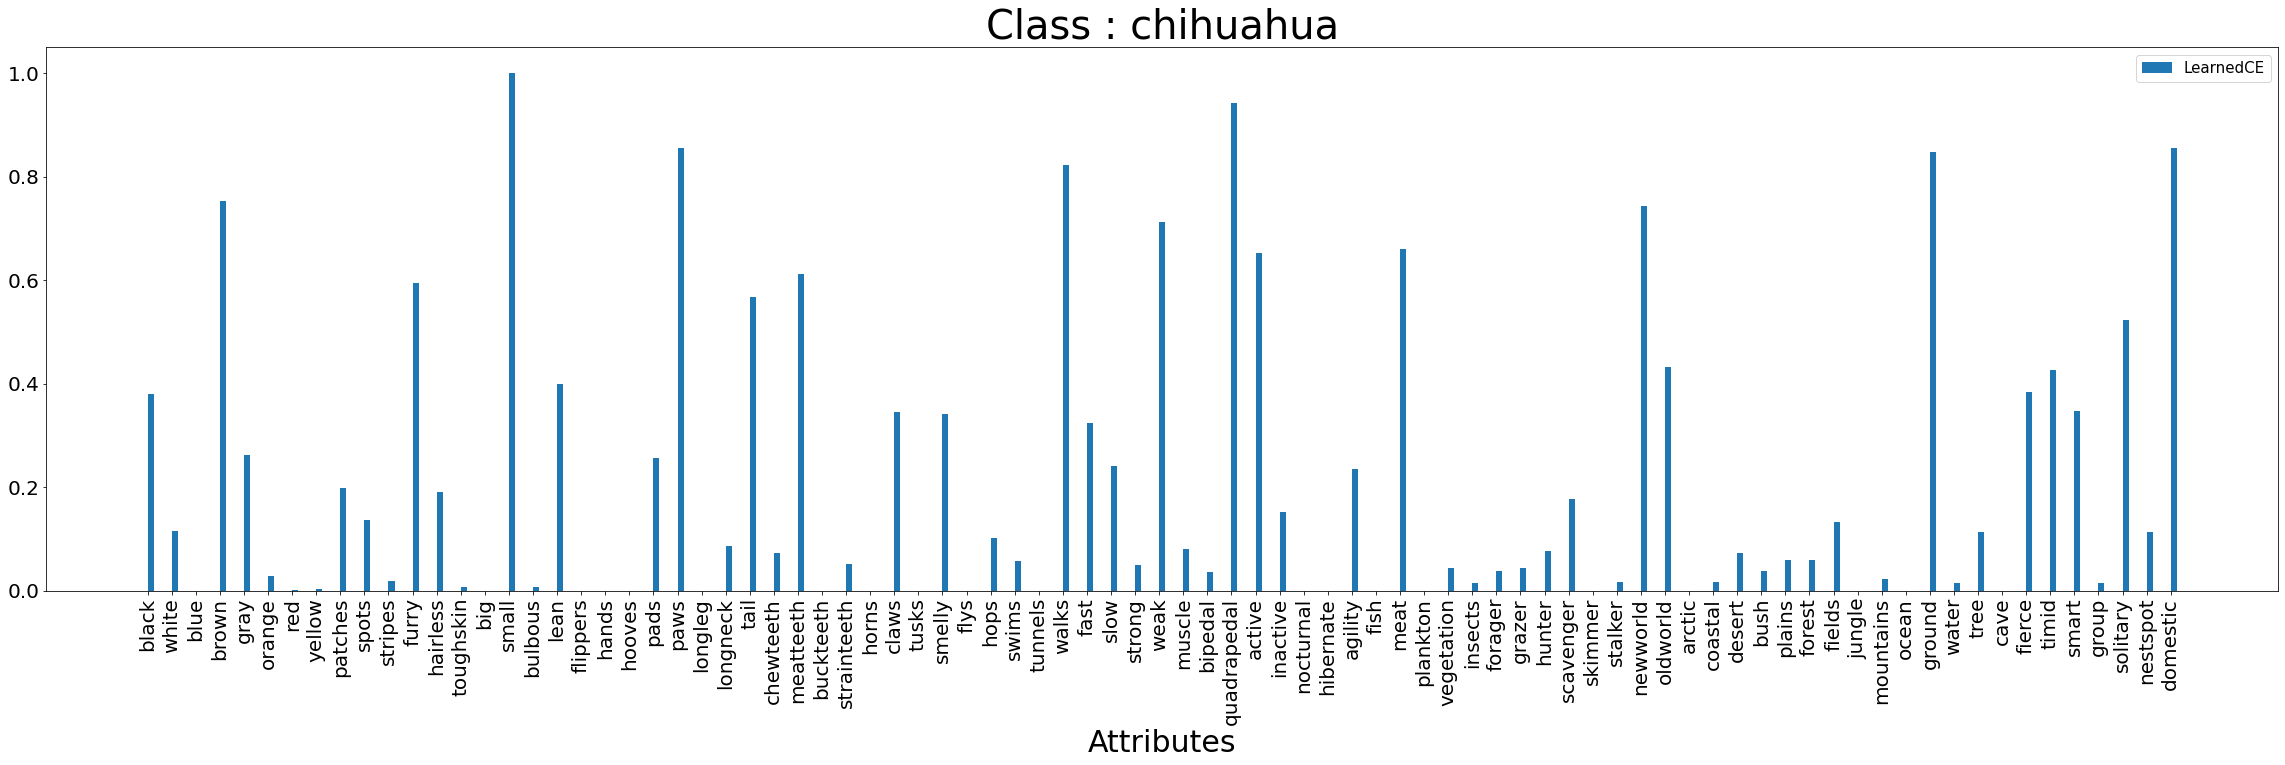

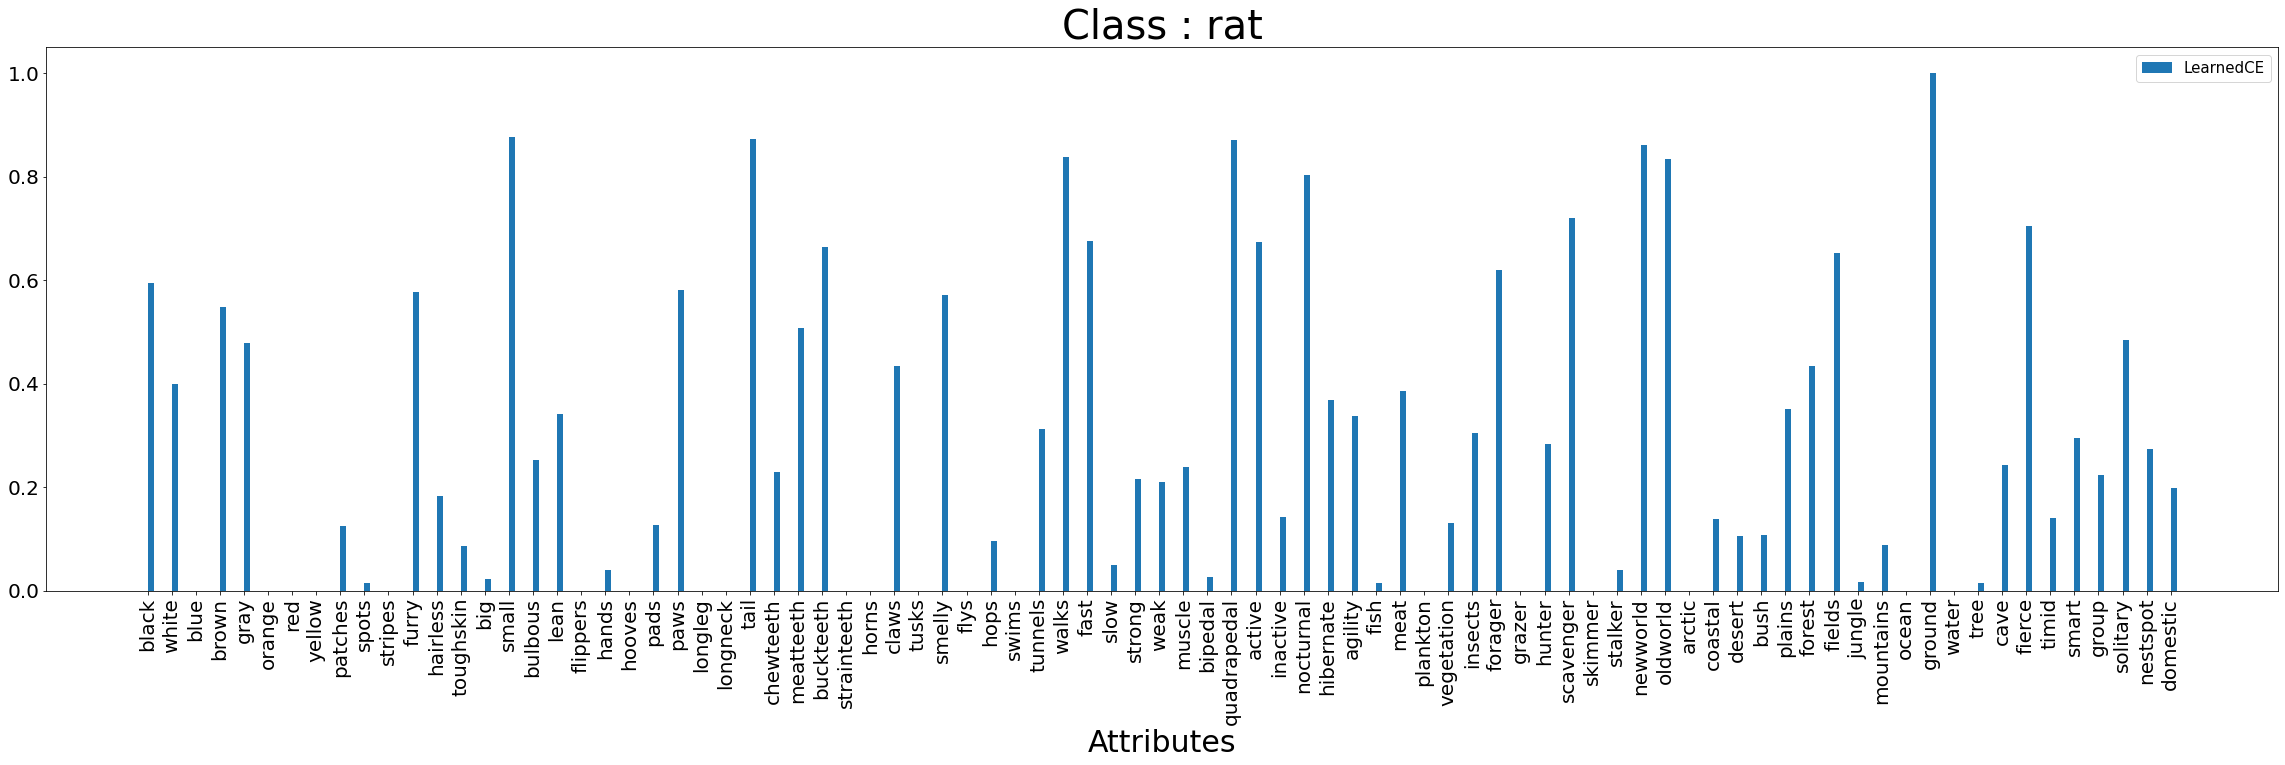

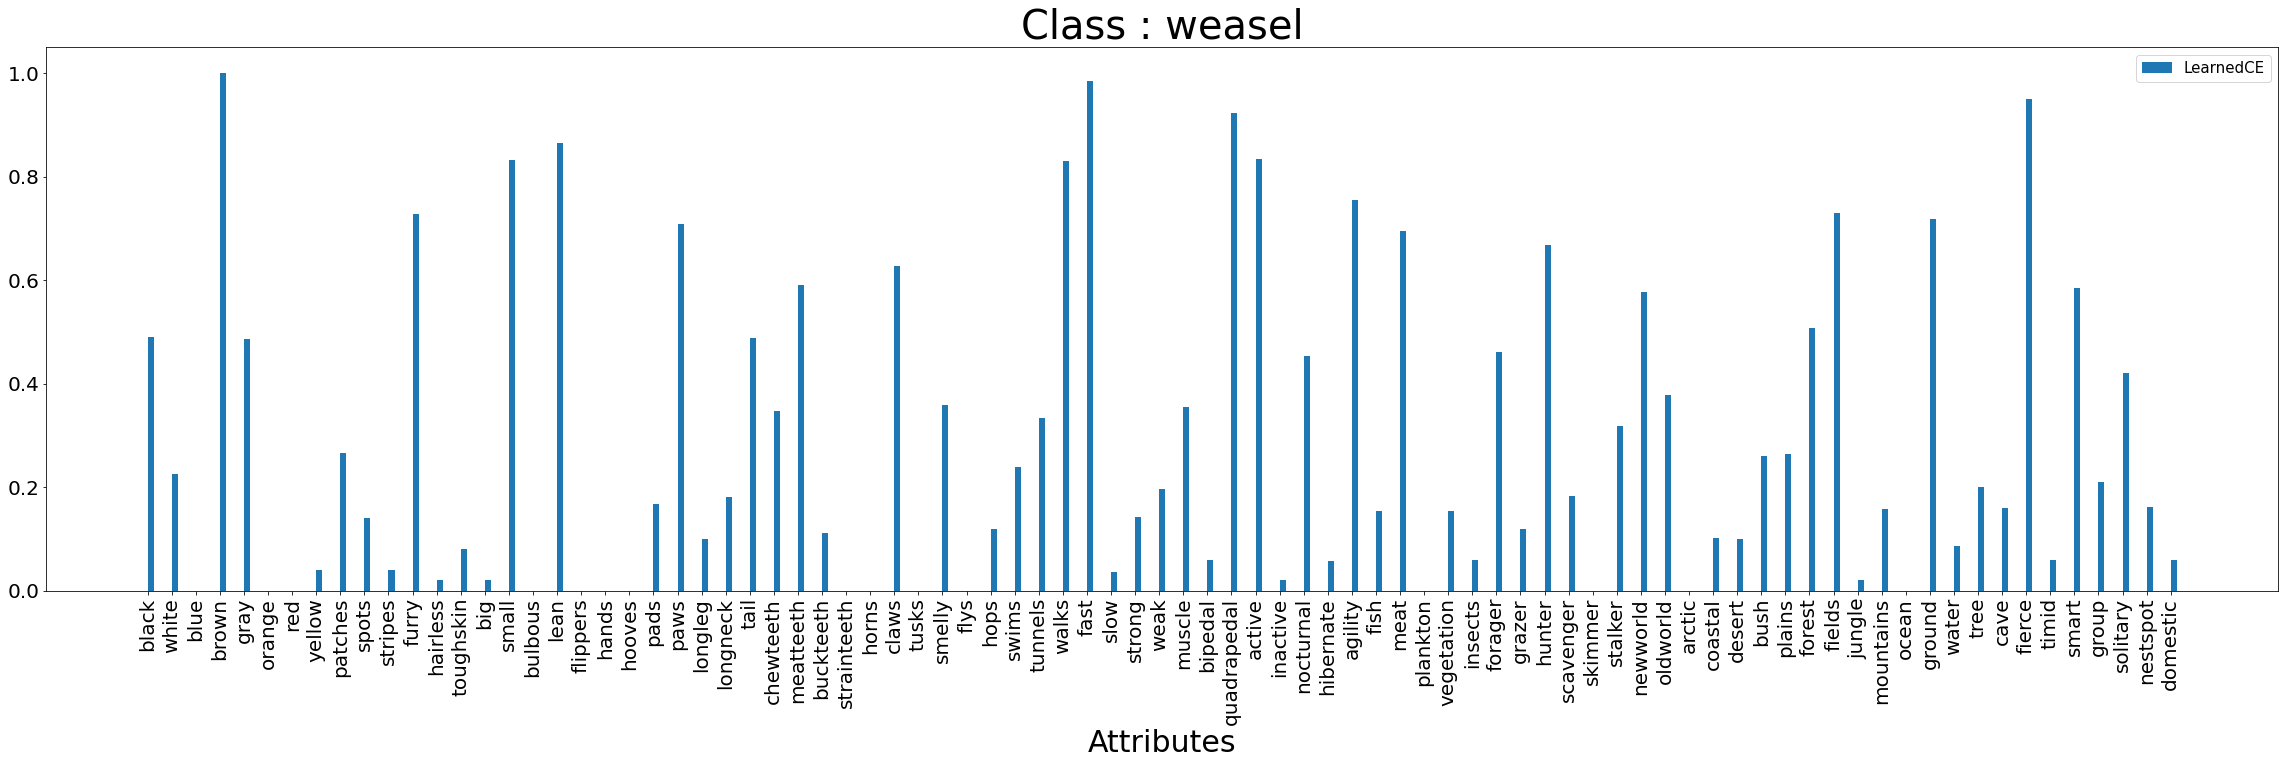

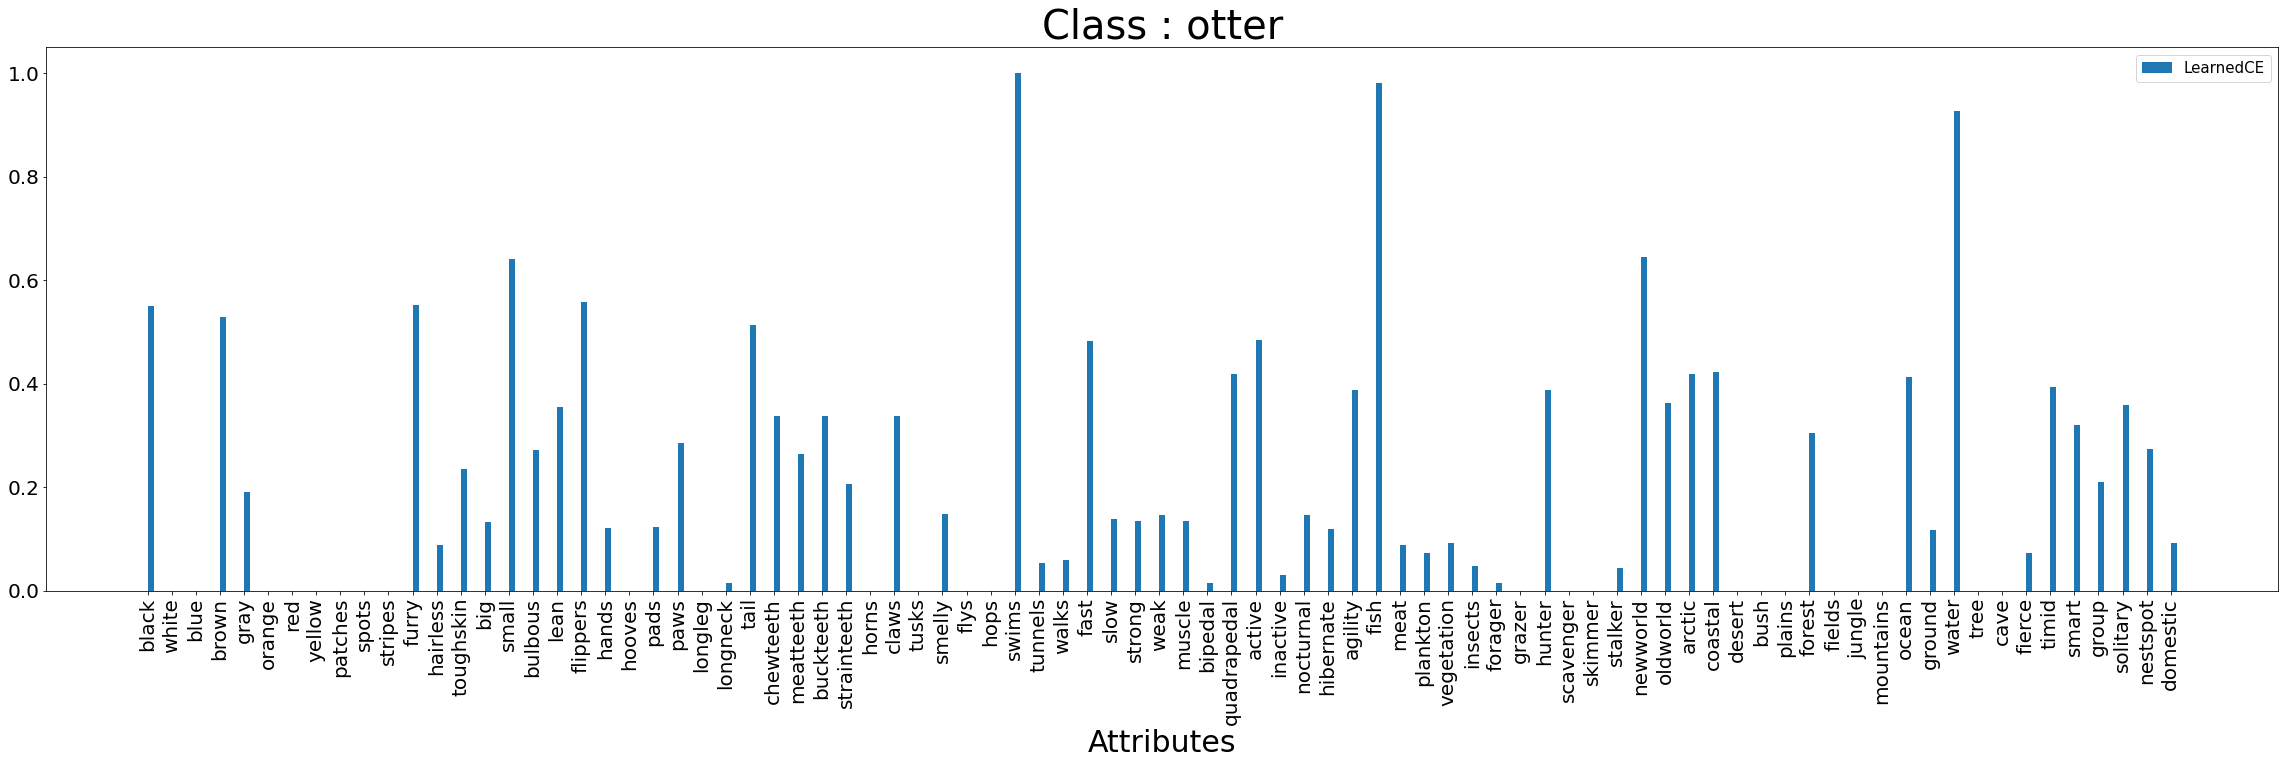

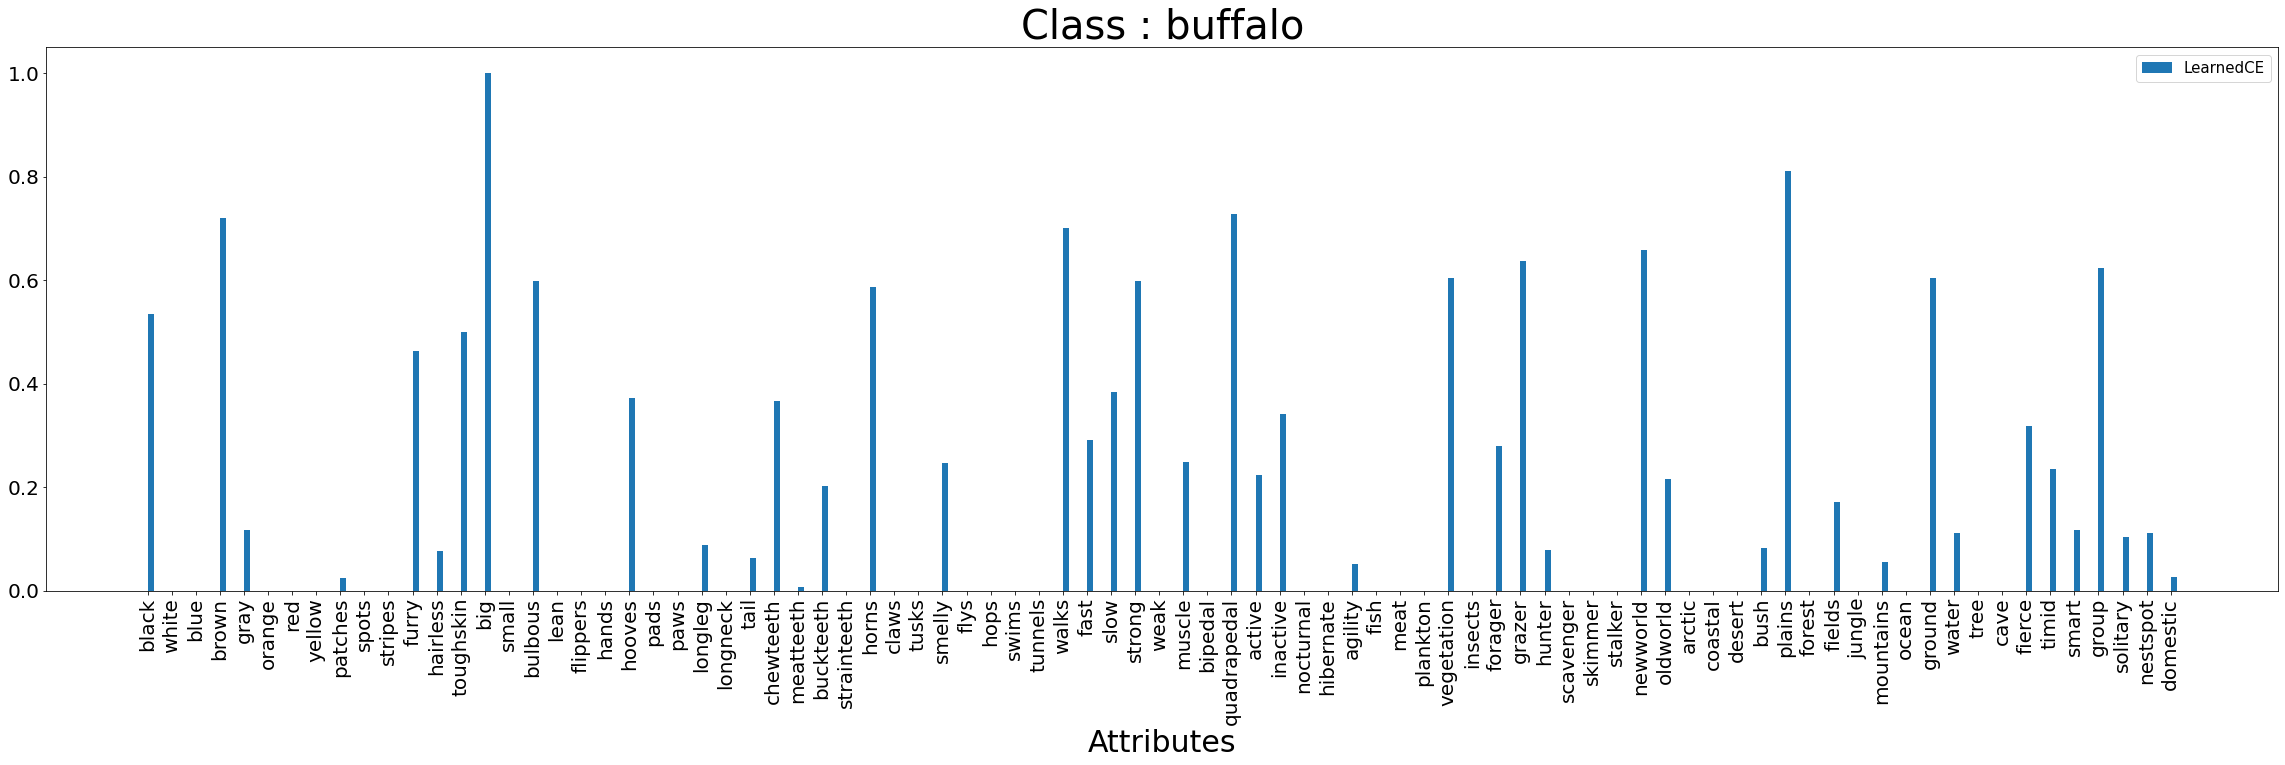

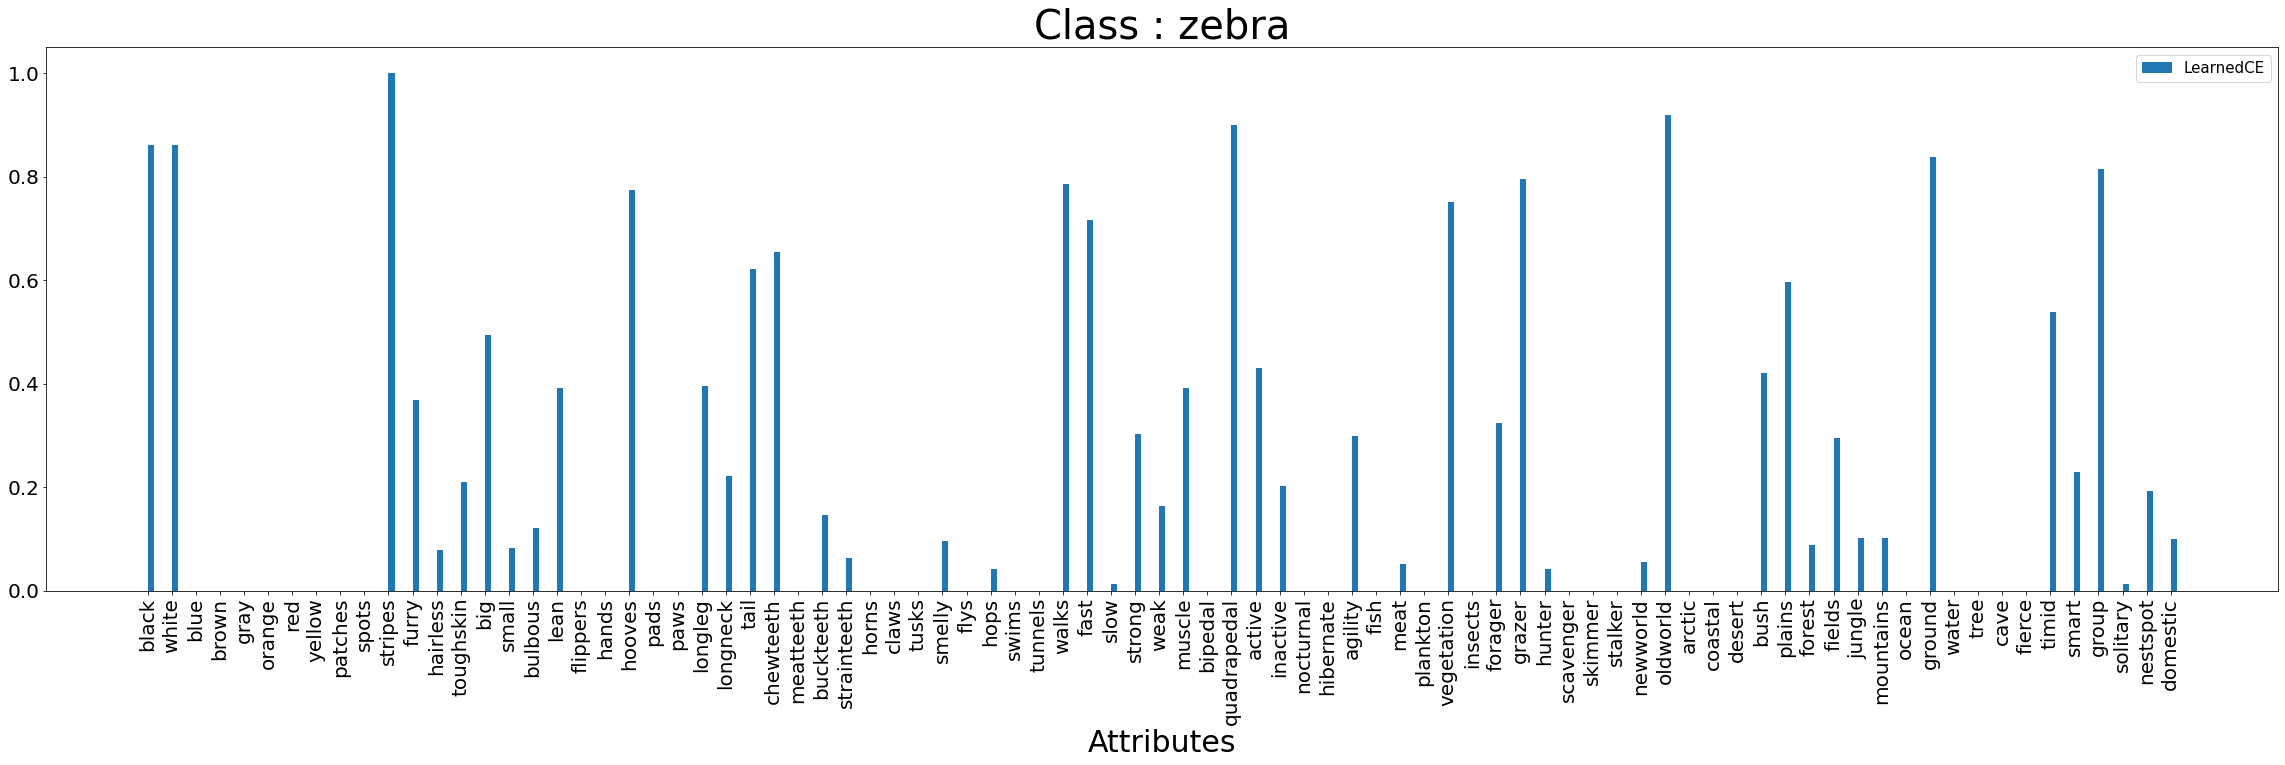

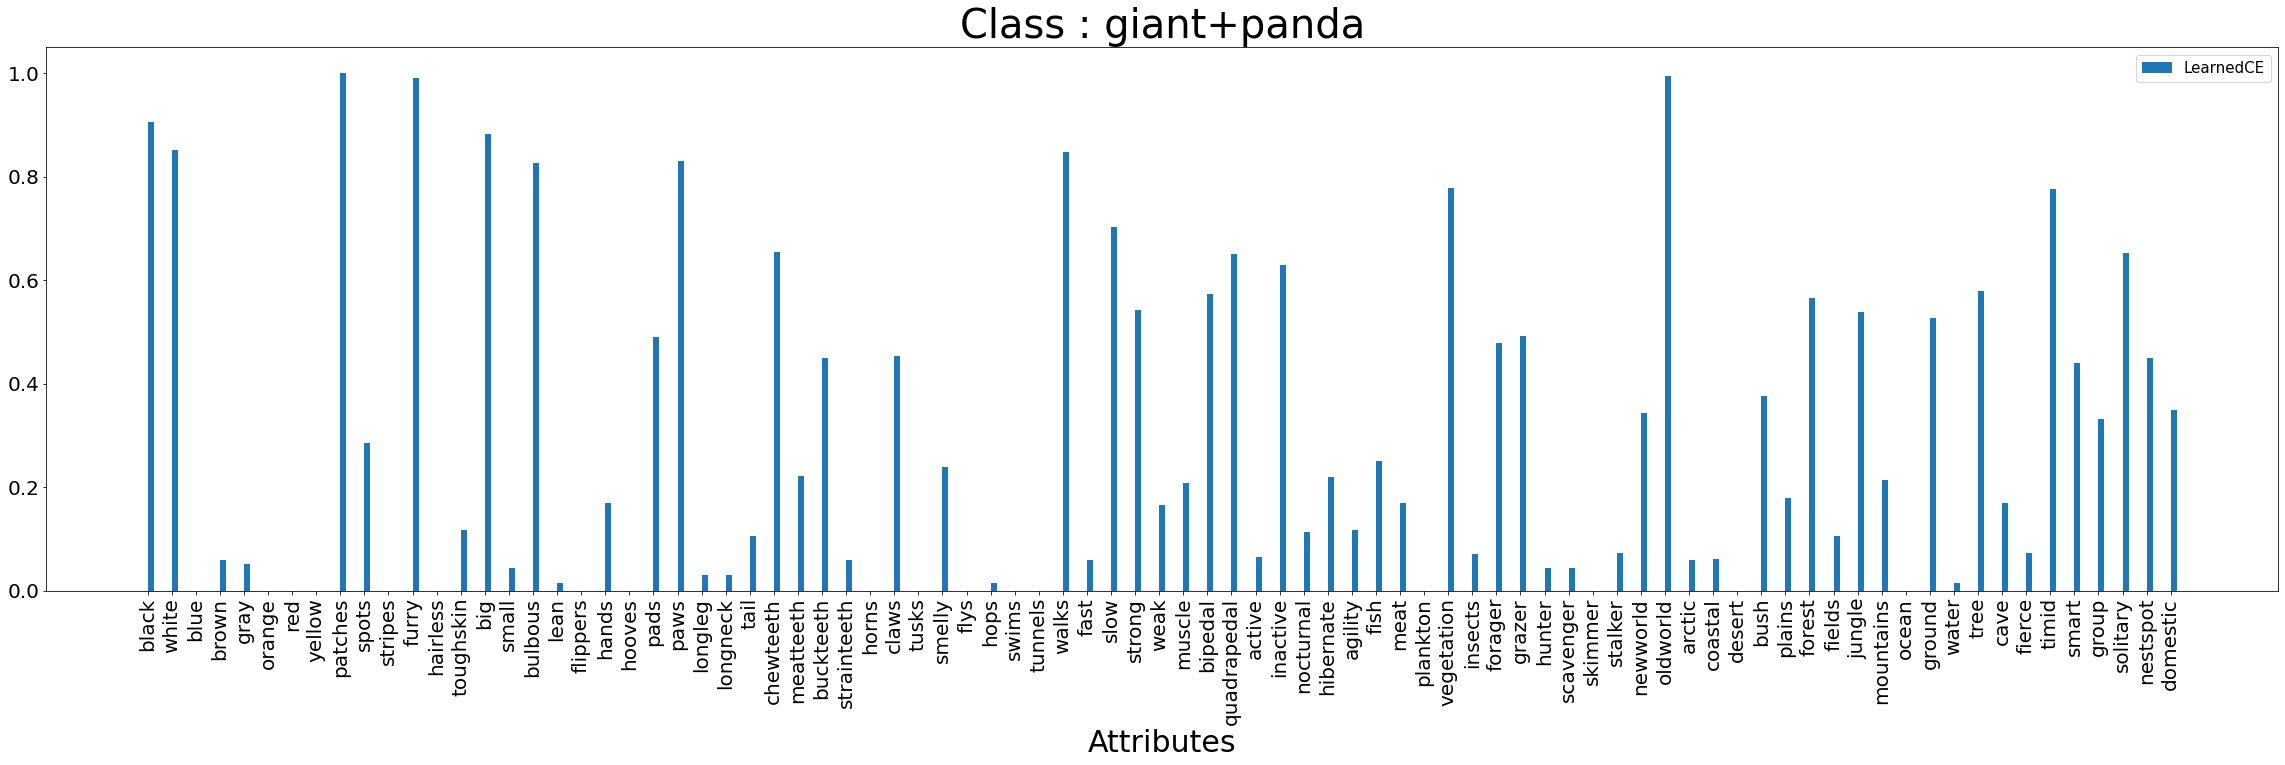

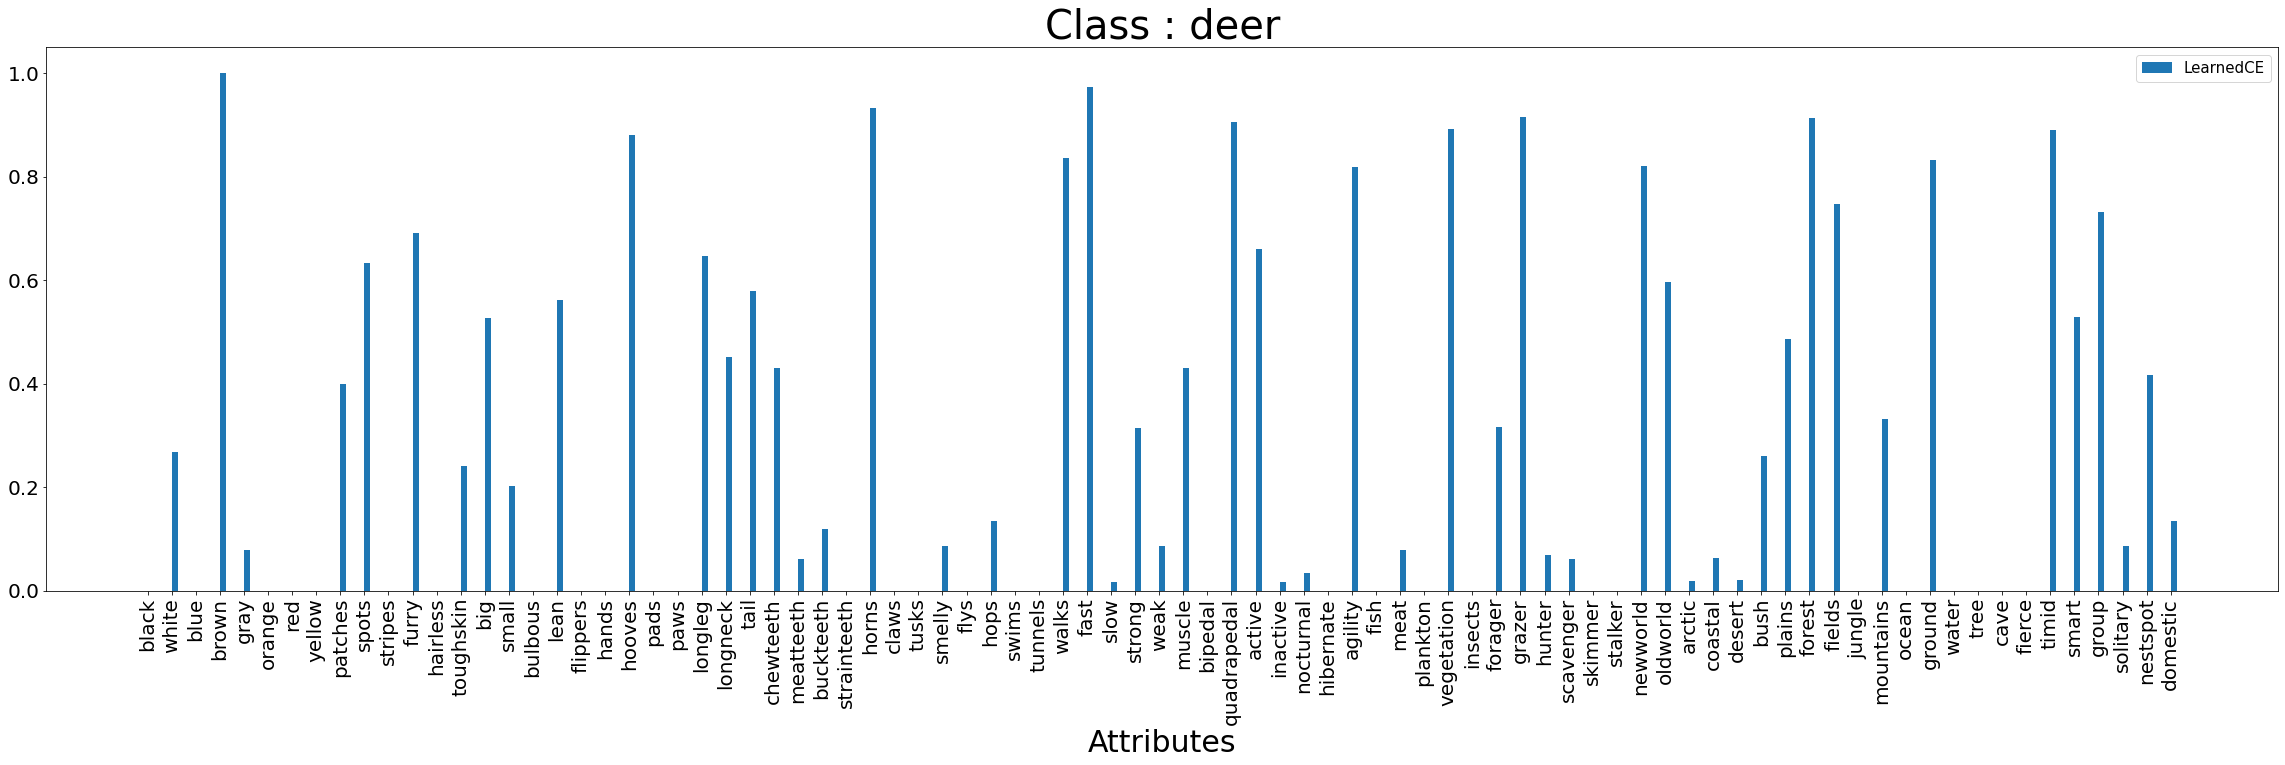

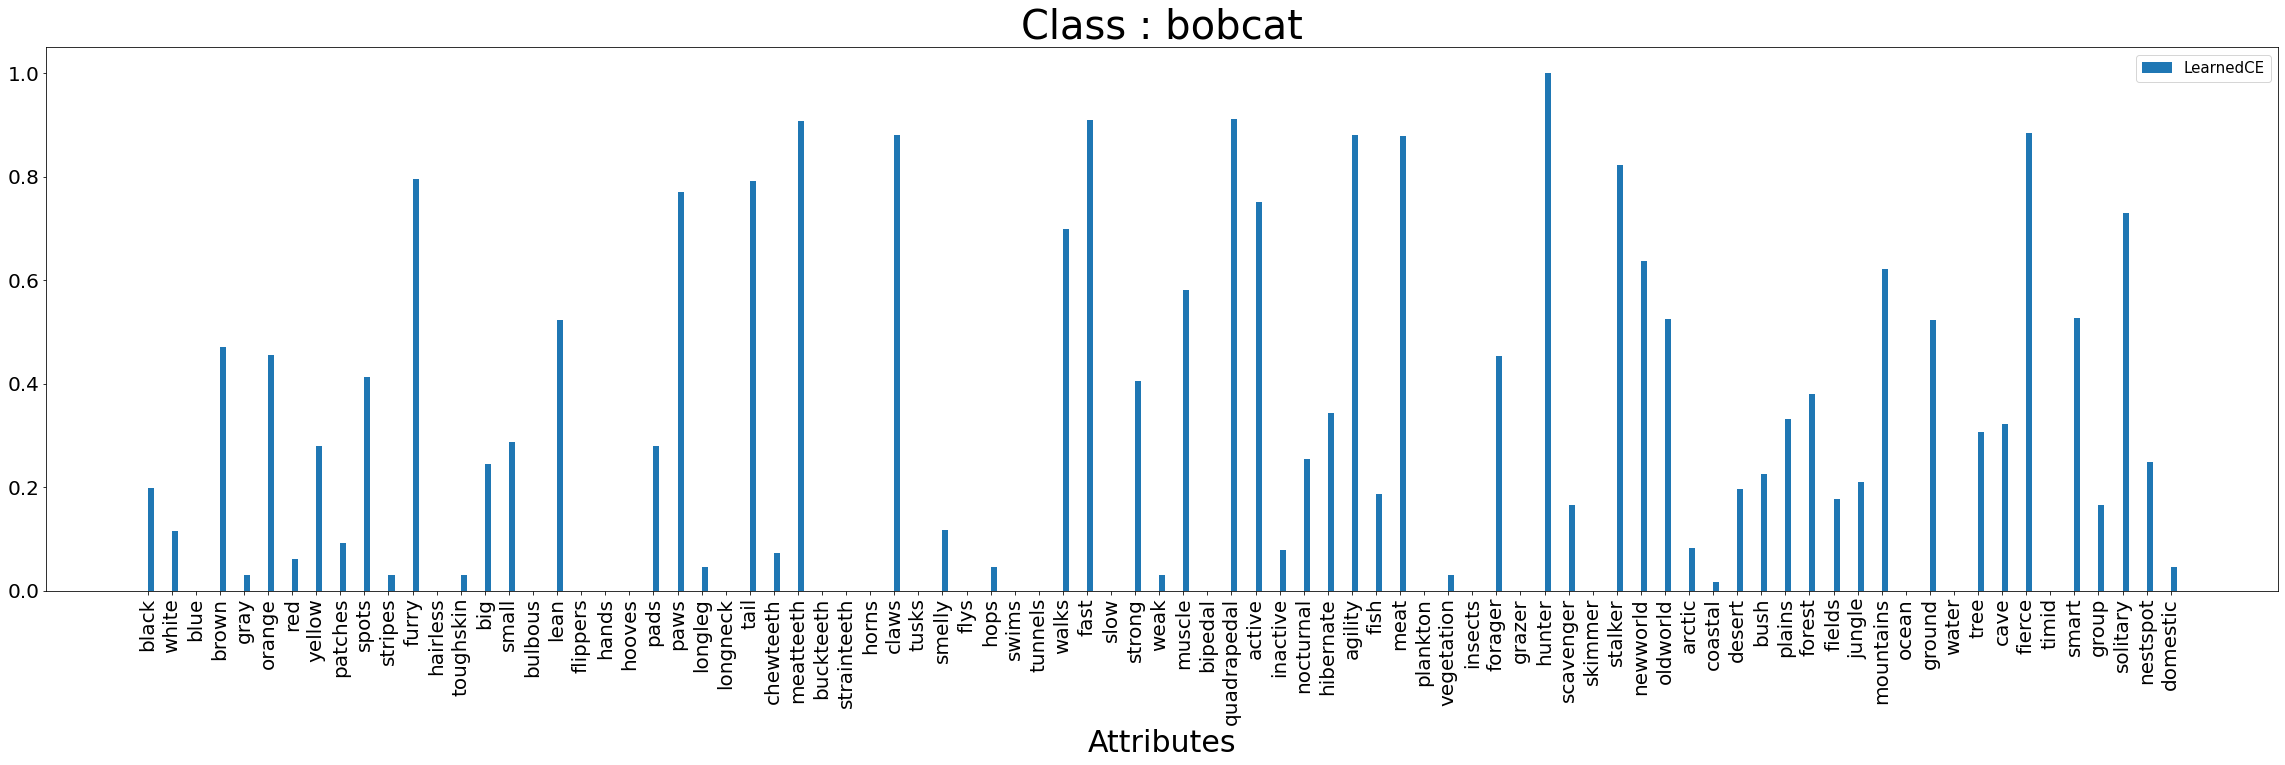

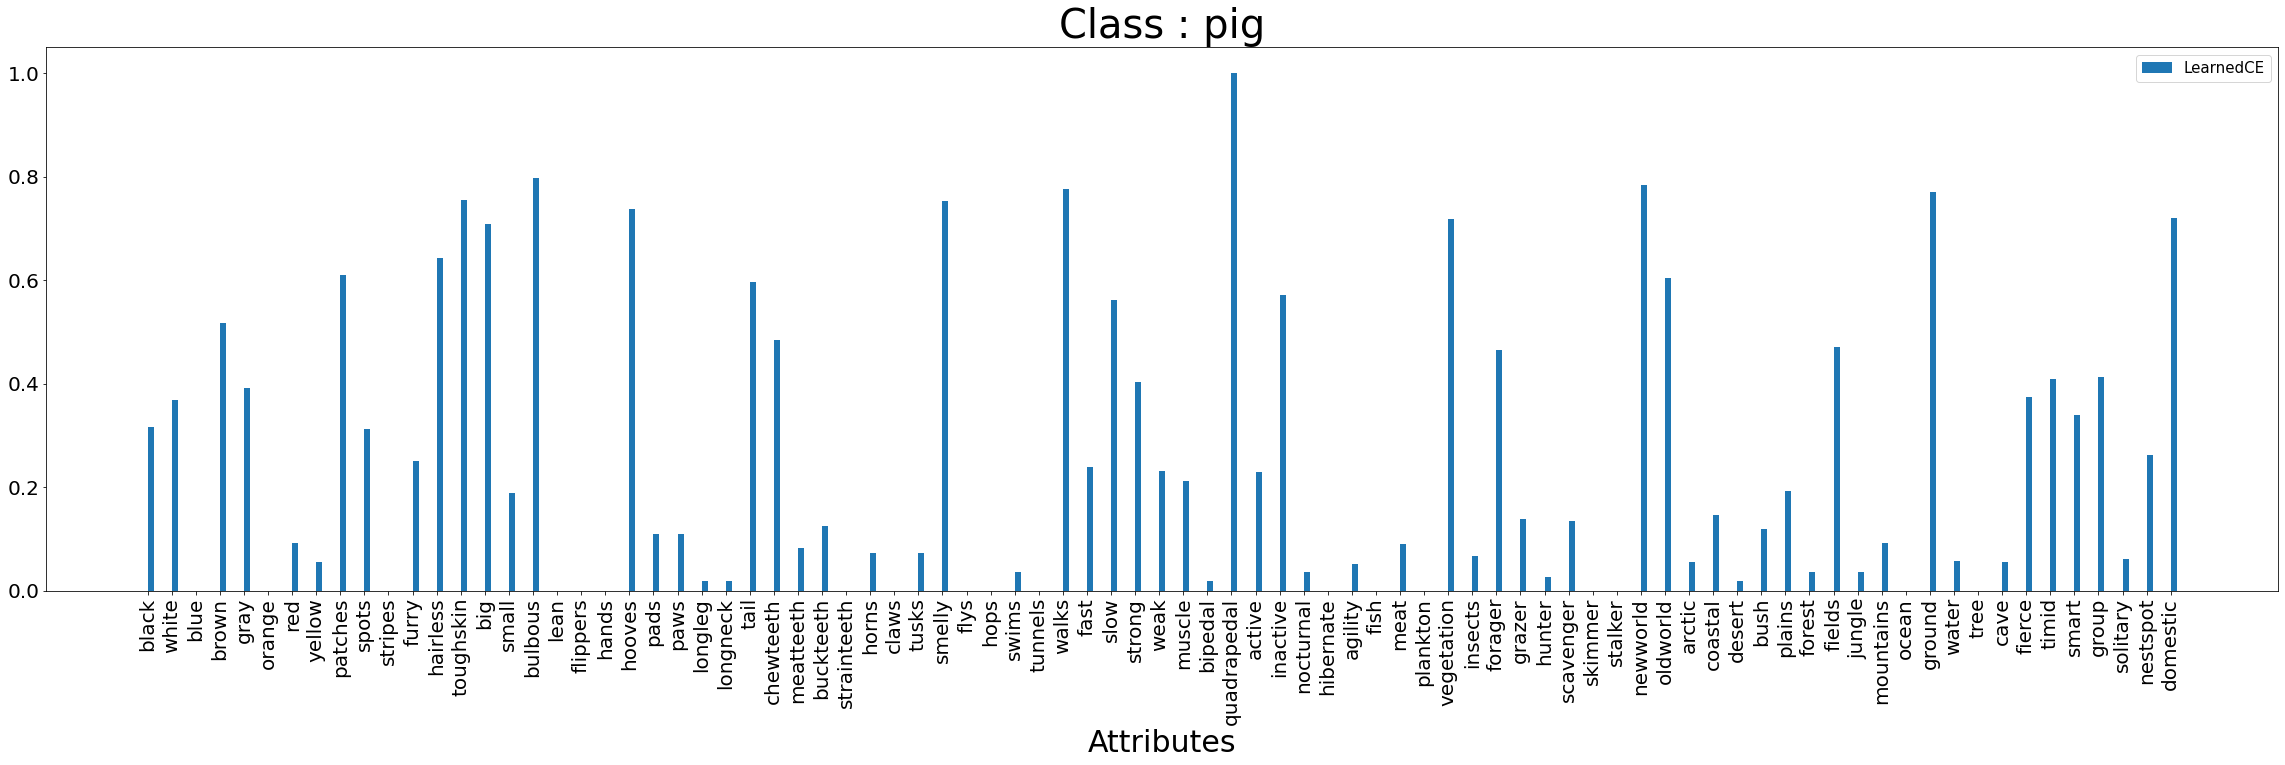

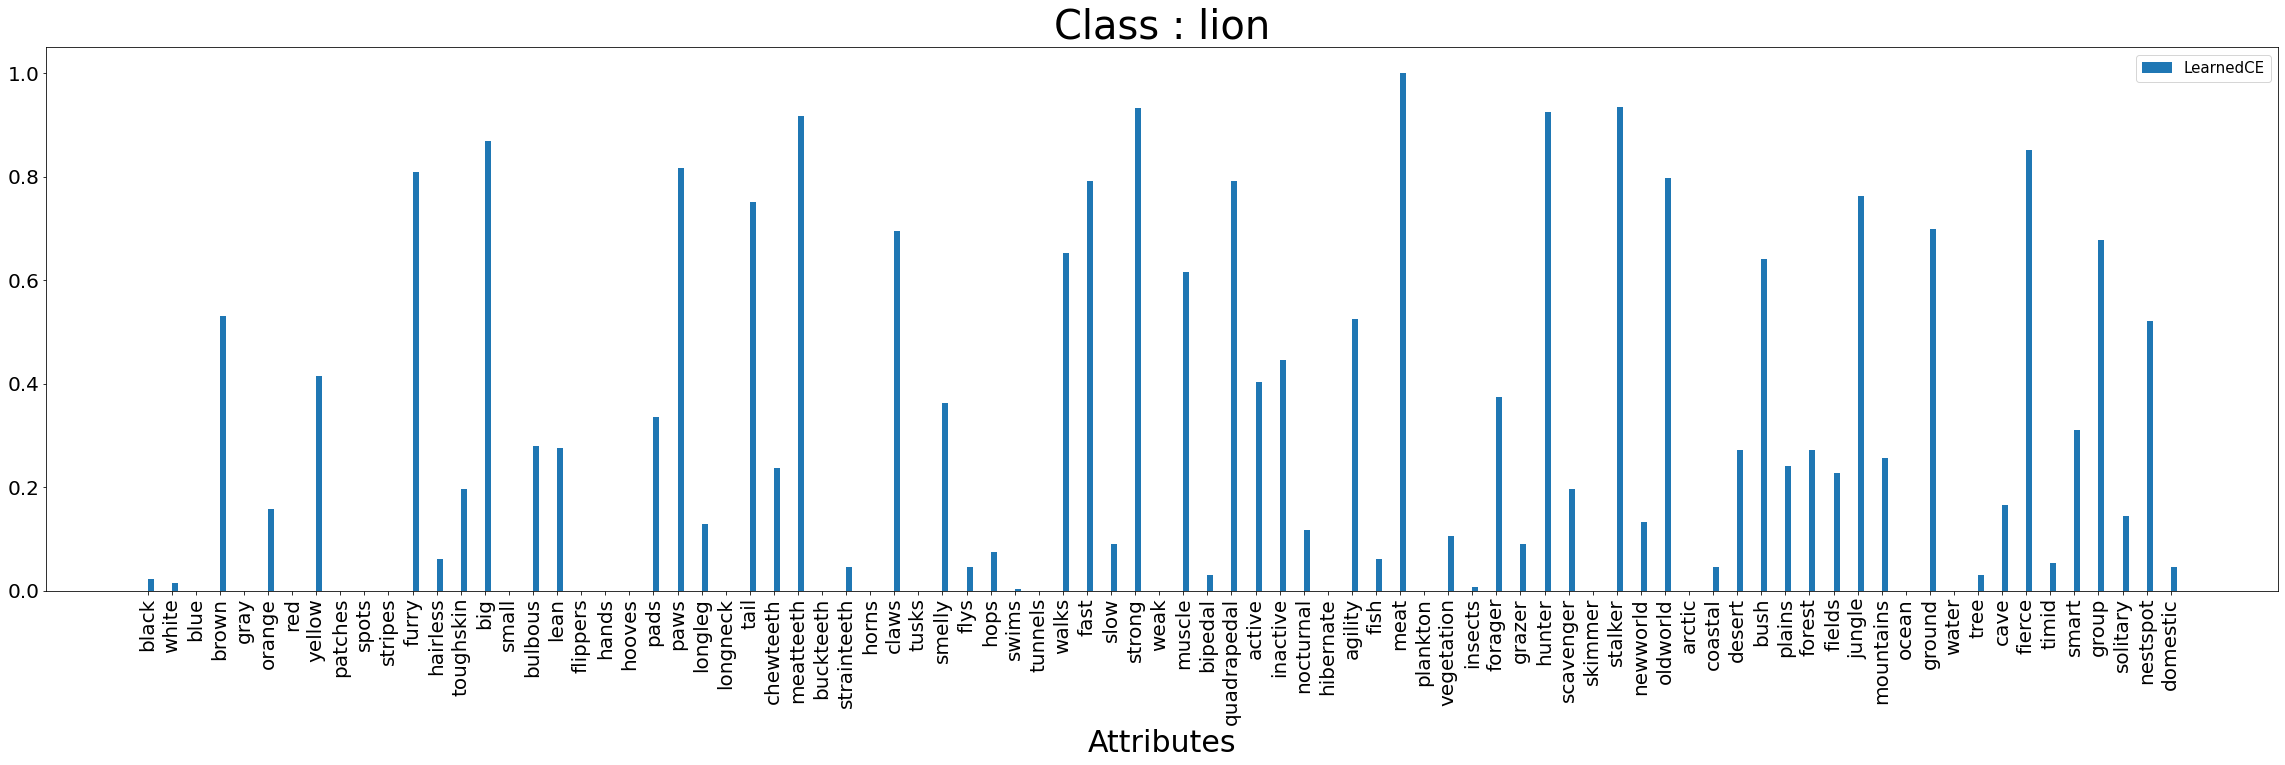

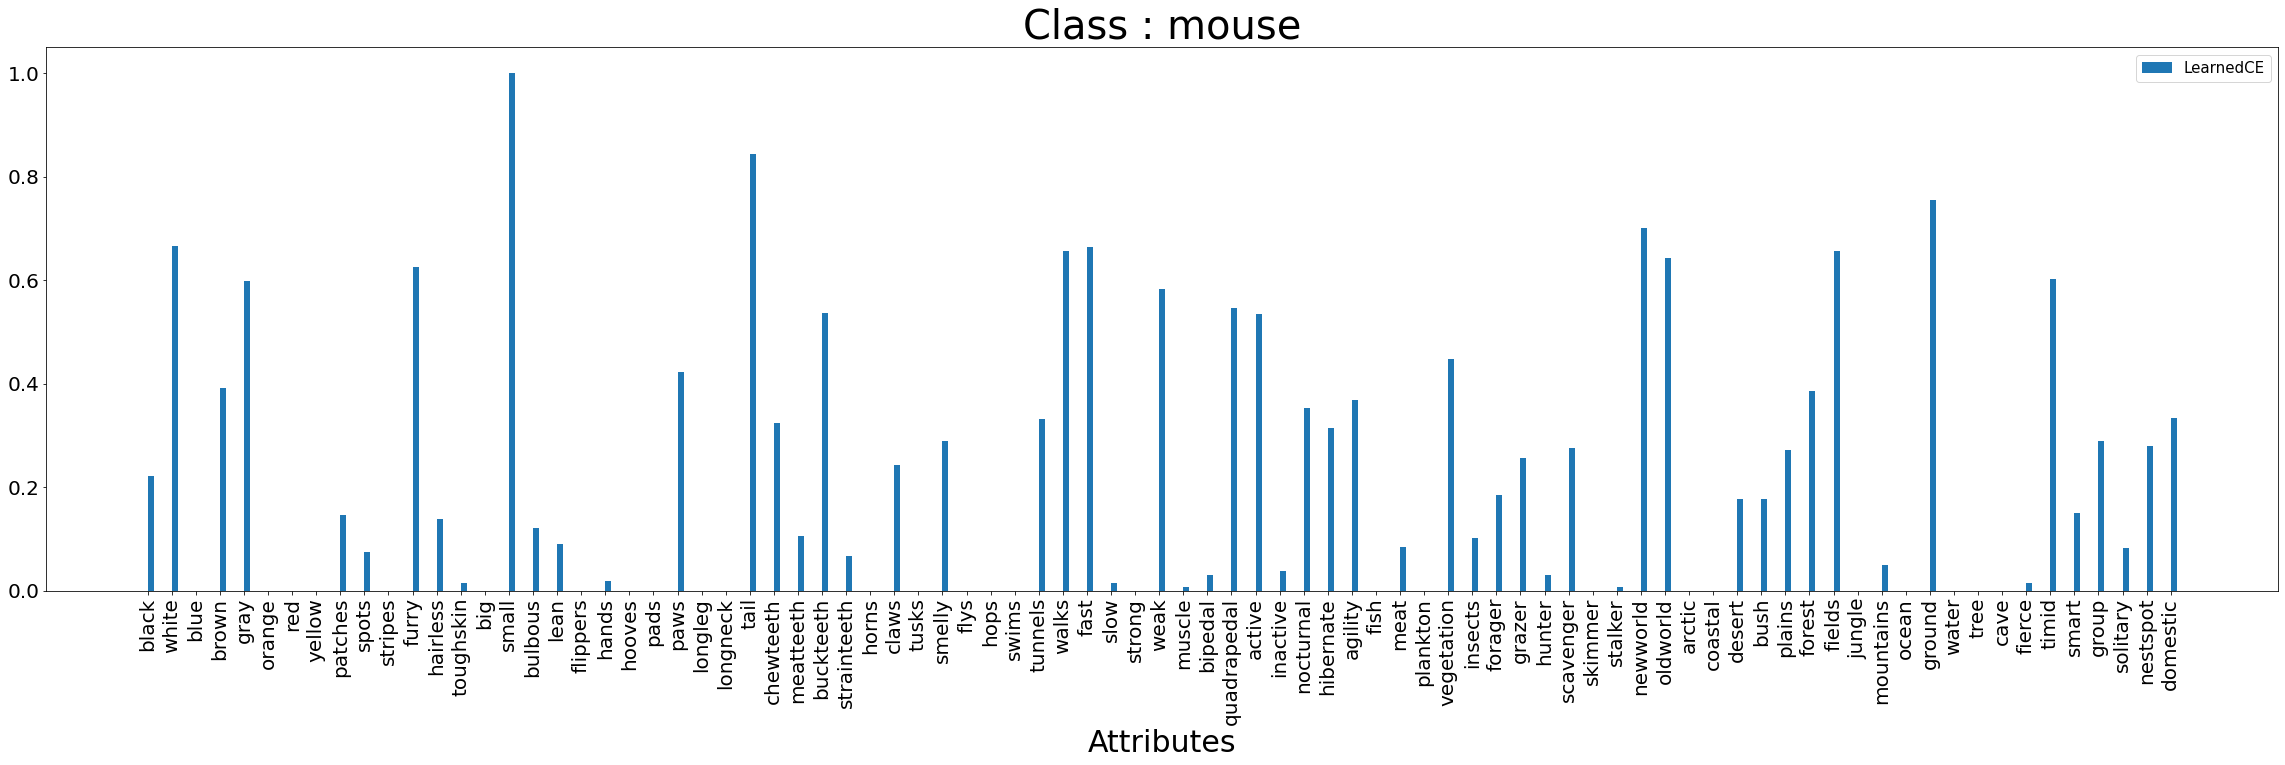

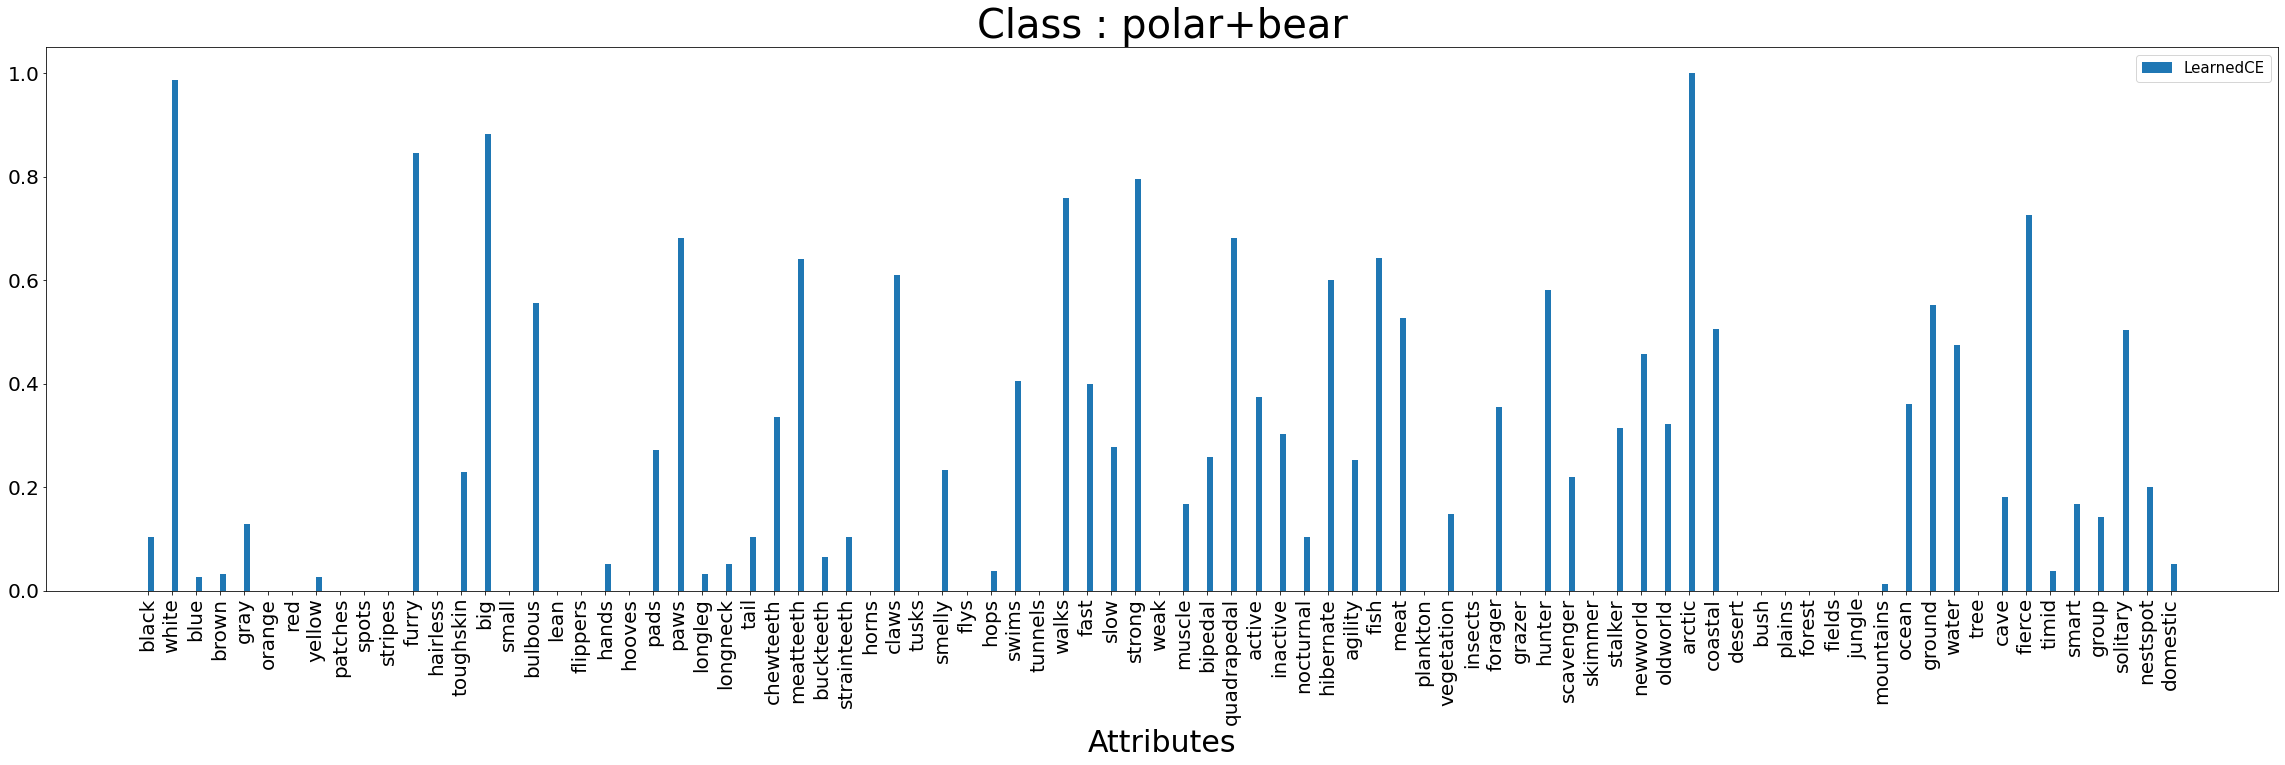

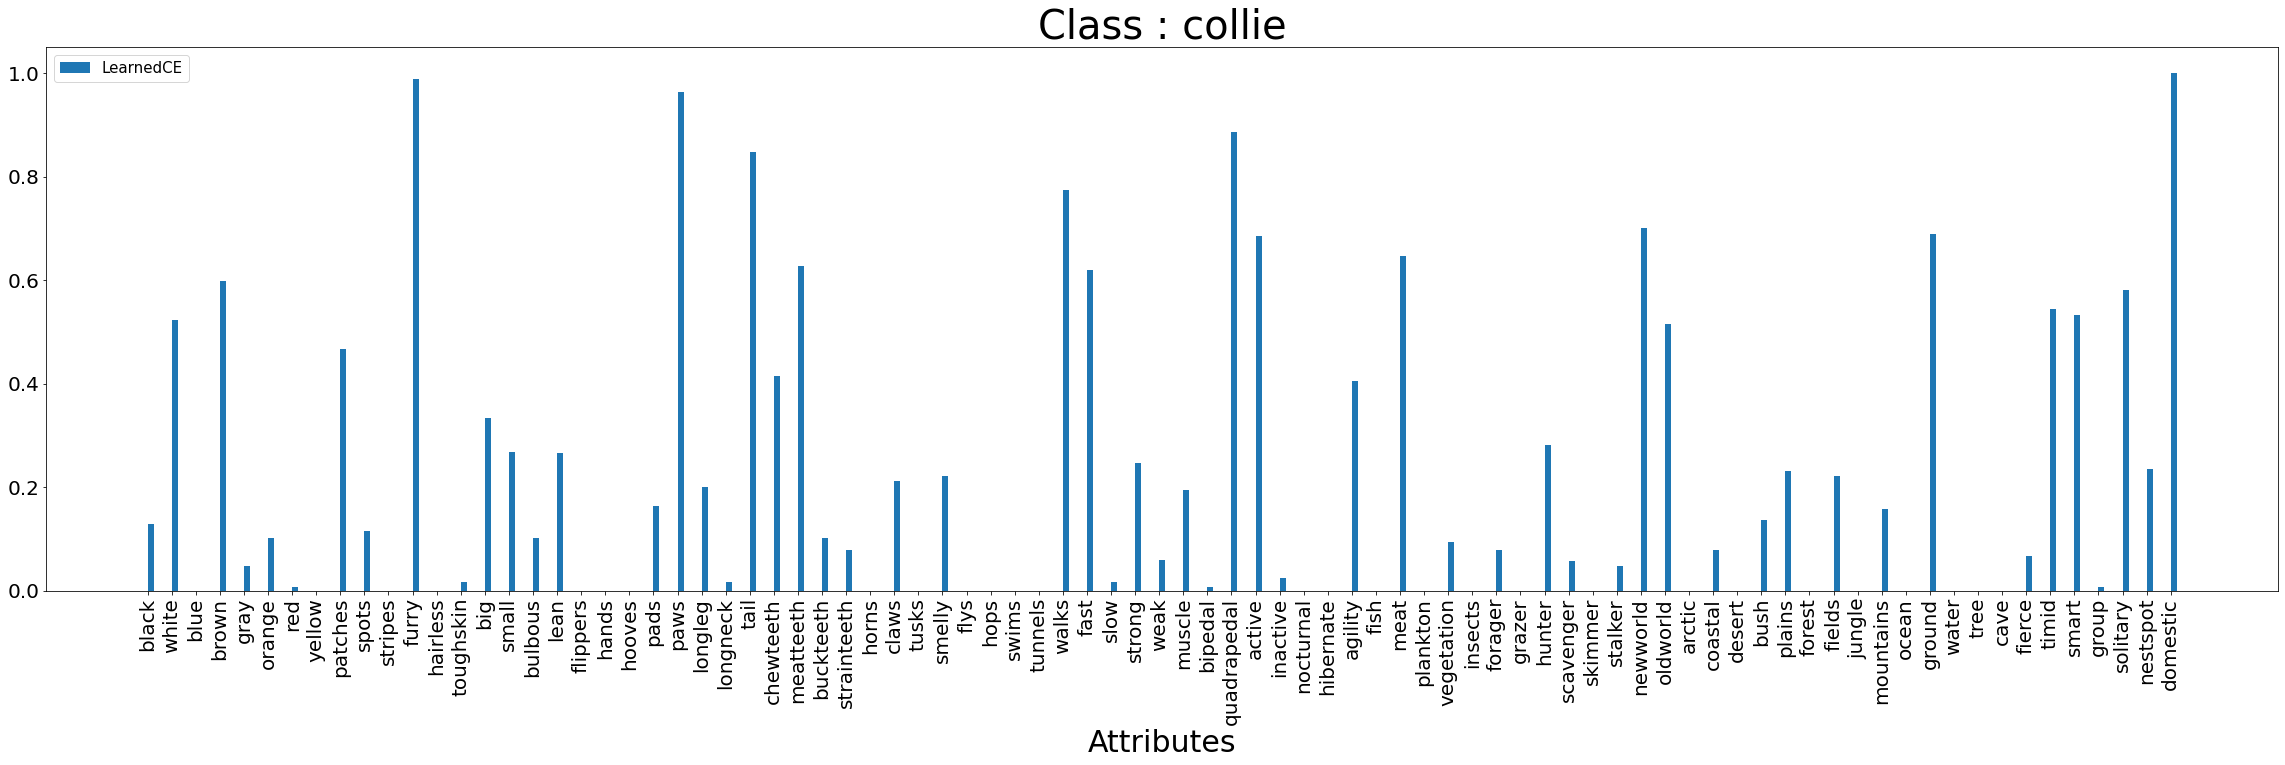

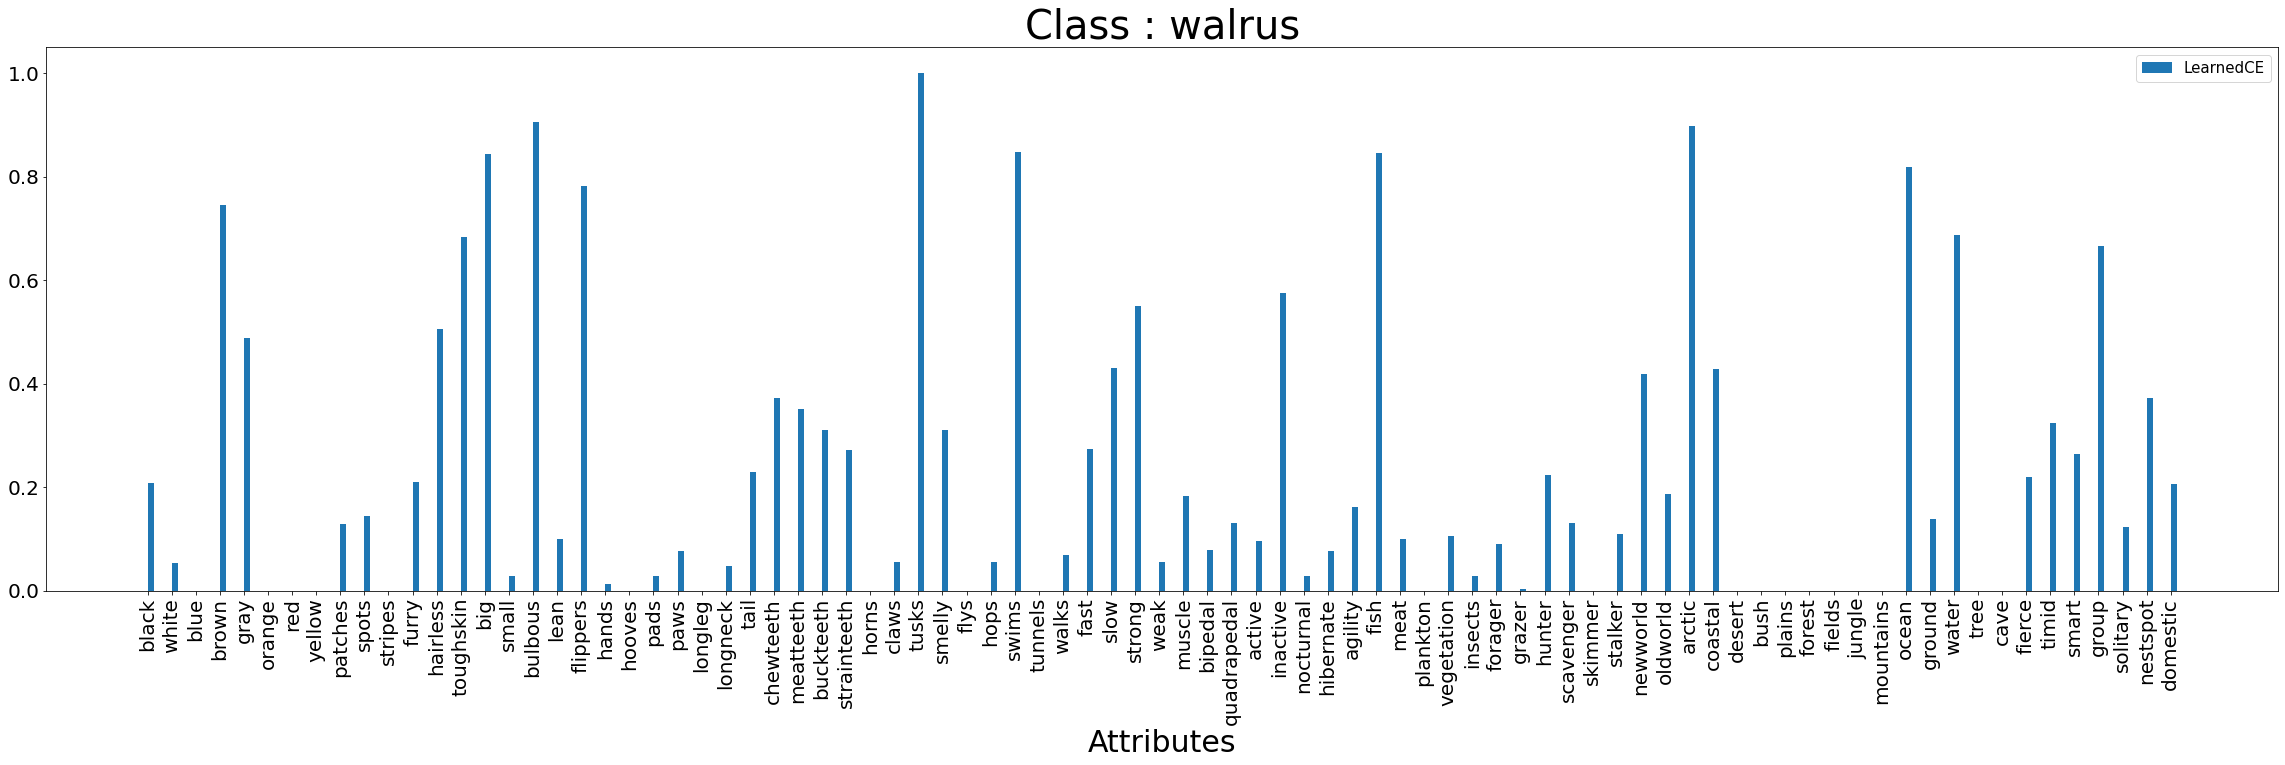

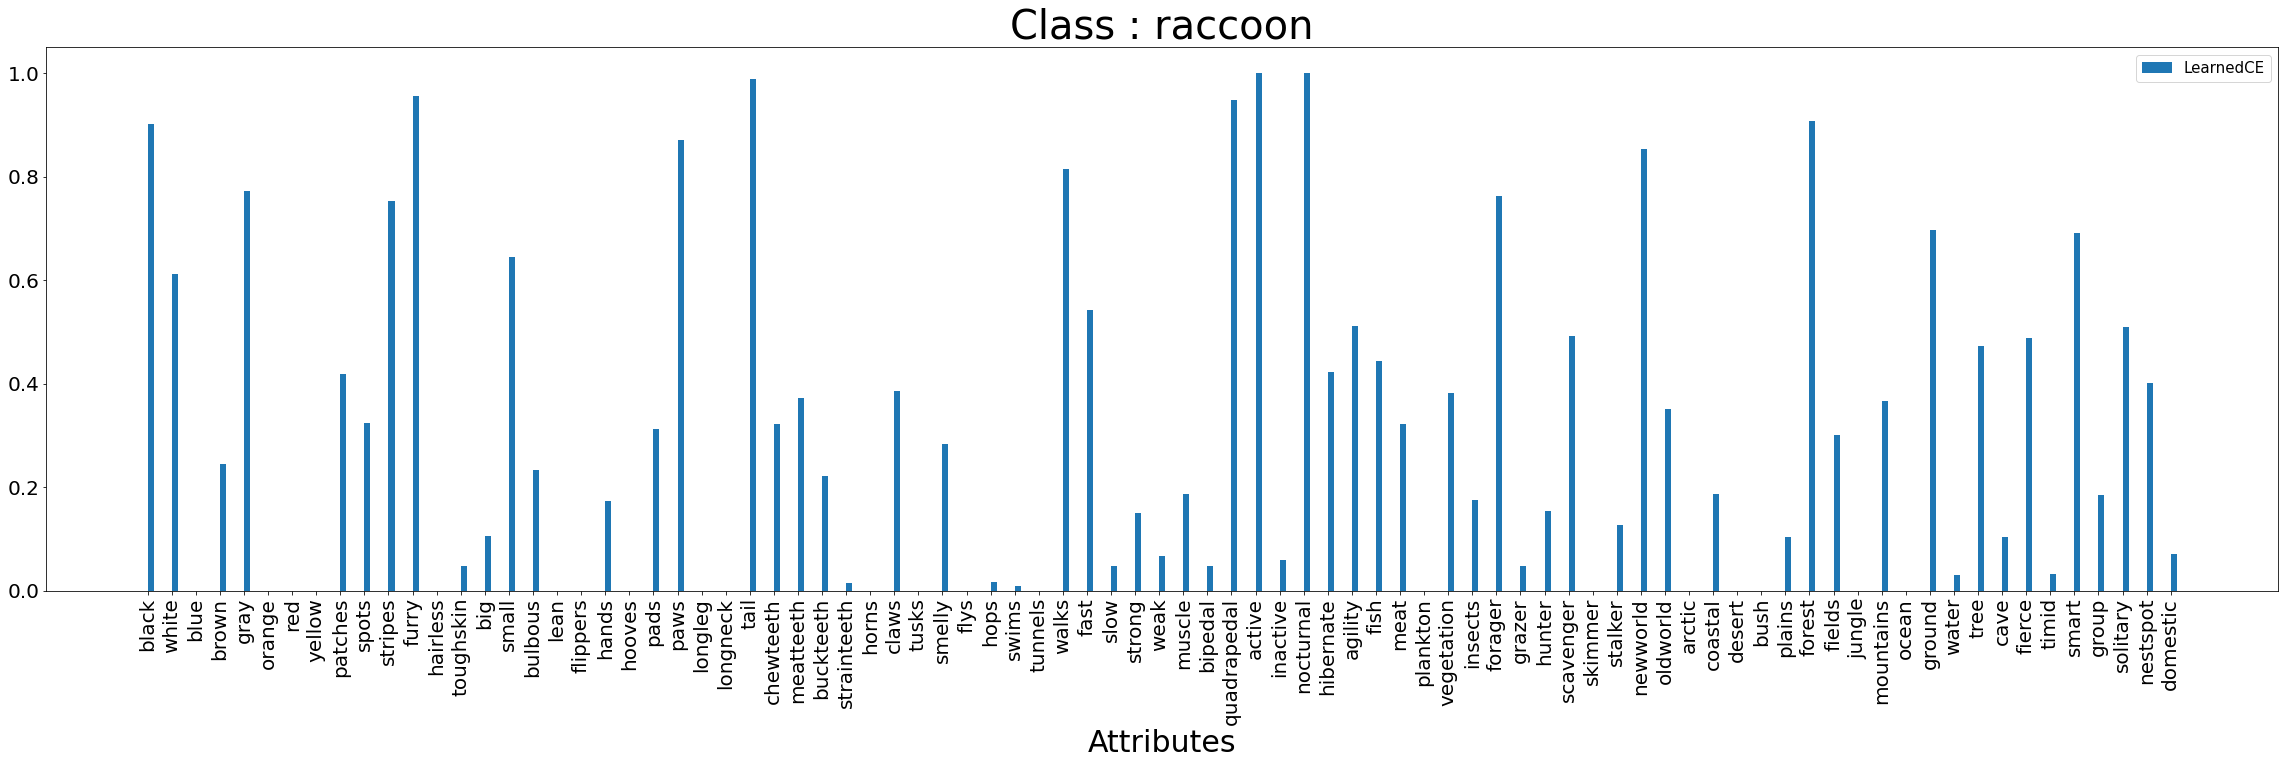

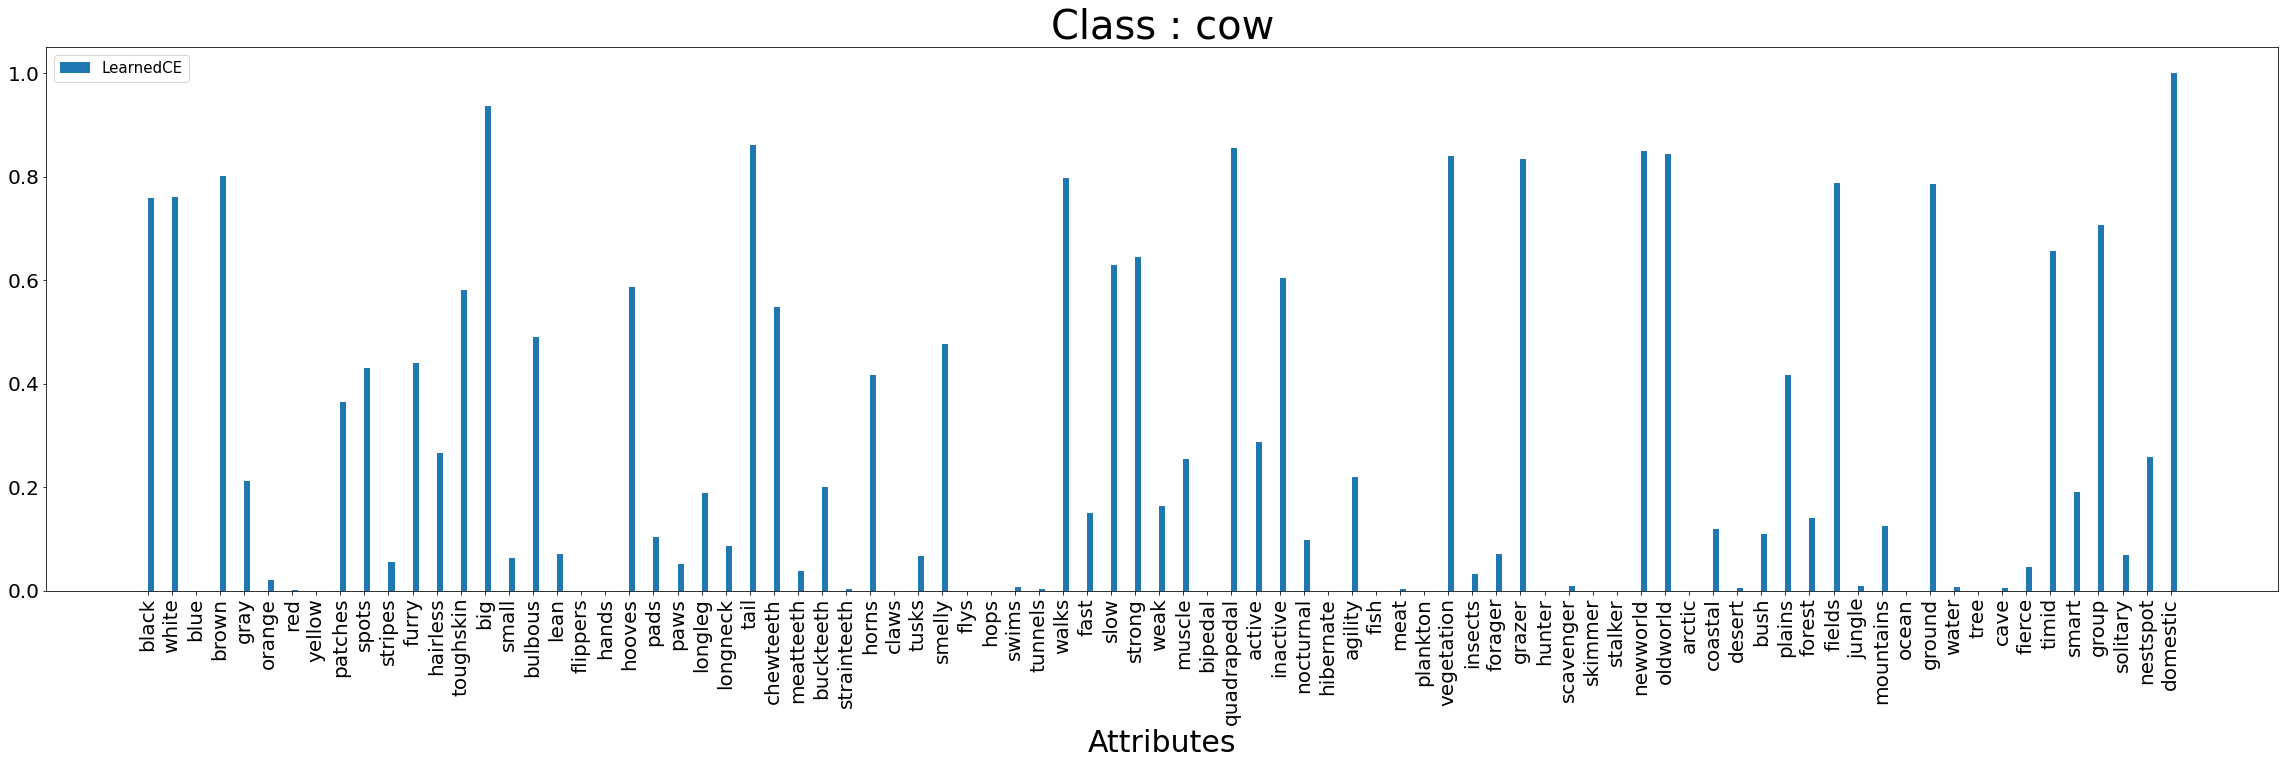

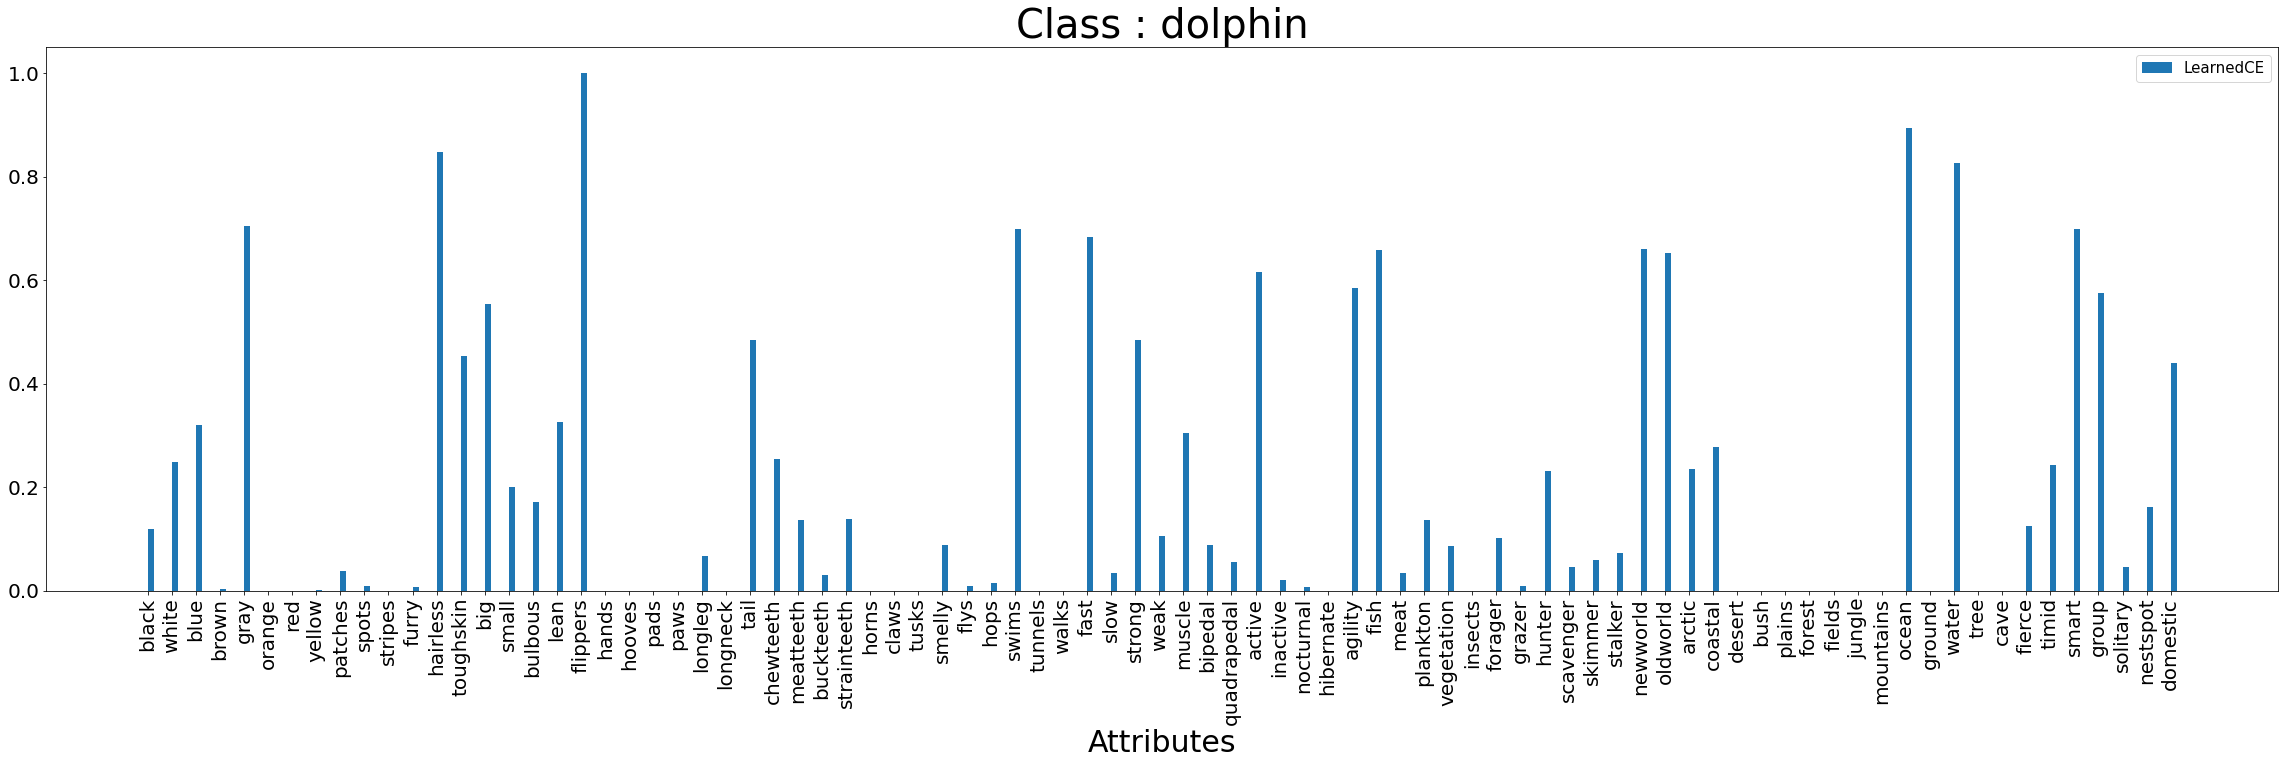

In [73]:
dataset = 'AWA2'
attributes_name = pd.read_csv('./data/{}/predicates.txt'.format(dataset),header=None,sep='\t')

for i in range(50):
    plt.figure(figsize=(40,10))
    plt.bar(attributes_name[1],height=attr[i],align='edge',label = 'LearnedCE',width = 0.25)
    plt.legend(fontsize=15) #要使用label要加這行
    plt.xlabel('Attributes',fontsize=30) # 設定x軸標題
    plt.xticks(fontsize=20,rotation='vertical')
    plt.yticks(fontsize=20)
    plt.title('Class : ' + class_name[i][0][0],fontsize=40) # 設定圖表標題
    plt.show()

-----------------------------

In [21]:
original_101 = sio.loadmat('../Downloads/res101.mat')
my_101 =  sio.loadmat('./data/AWA2/mat/ft_cms/res101.mat')

In [26]:
original_101['features'][0].shape

(37322,)

In [25]:
my_101['features'][0].shape

(37318,)

In [131]:
from keras.datasets import imdb

In [132]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

17465344/17464789 [==============================] - 8s 0us/step


In [143]:
x_train[1]

[1,
 194,
 1153,
 194,
 2,
 78,
 228,
 5,
 6,
 1463,
 4369,
 2,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 2,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 2,
 5,
 163,
 11,
 3215,
 2,
 4,
 1153,
 9,
 194,
 775,
 7,
 2,
 2,
 349,
 2637,
 148,
 605,
 2,
 2,
 15,
 123,
 125,
 68,
 2,
 2,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 2,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 2,
 5,
 2,
 656,
 245,
 2350,
 5,
 4,
 2,
 131,
 152,
 491,
 18,
 2,
 32,
 2,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 154,
 462,
 33,
 89,
 78,
 285,
 16,
 145,
 95]